# 统计学习导论第七次作业

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、业务理解
### 数据来源
Kaggle提供的【Online Retail Data Set from UCI ML repo】  
### 数据主题
聚类分析
### 数据网站
https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo
### 数据字典：  
InvoiceNo: 订单号 数值型连续数据
StockCode: 产品号 分类数据
Description: 产品描述 分类数据
Quantity: 每笔交易量 数值型连续数据
InvoiceDate: 交易时间 数值型连续数据
UnitPrice: 产品单价 数值型连续数据
CustomerID: 用户ID 分类数据
Country: 用户所在国家 分类数据

In [22]:
####--------------------------------统计学习导论第七次作业（聚类分析）--------------------------------####

#--------------------------------1、业务理解--------------------------------#
import pandas as pd

## 数据导入
# Kaggle提供的【Online Retail Data Set from UCI ML repo】
# 主题：聚类分析实现RFM客户画像
# 地址：https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo

data = pd.read_excel('/Users/ouyangruizhi/Desktop/python/统计学习导论/聚类/Online Retail.xlsx')

# 展示前五行数据
print('前五行数据：')
print(data.head())

前五行数据：
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


## 二、数据探索与预处理
### 2.1 数据基本情况

In [23]:
#--------------------------------2、数据探索与预处理--------------------------------#
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

## 数据基本情况
print('数据基本情况：')
print(data.describe())

数据基本情况：
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


### 2.2 异常值检测与处理
#### 2.2.1 异常值检测

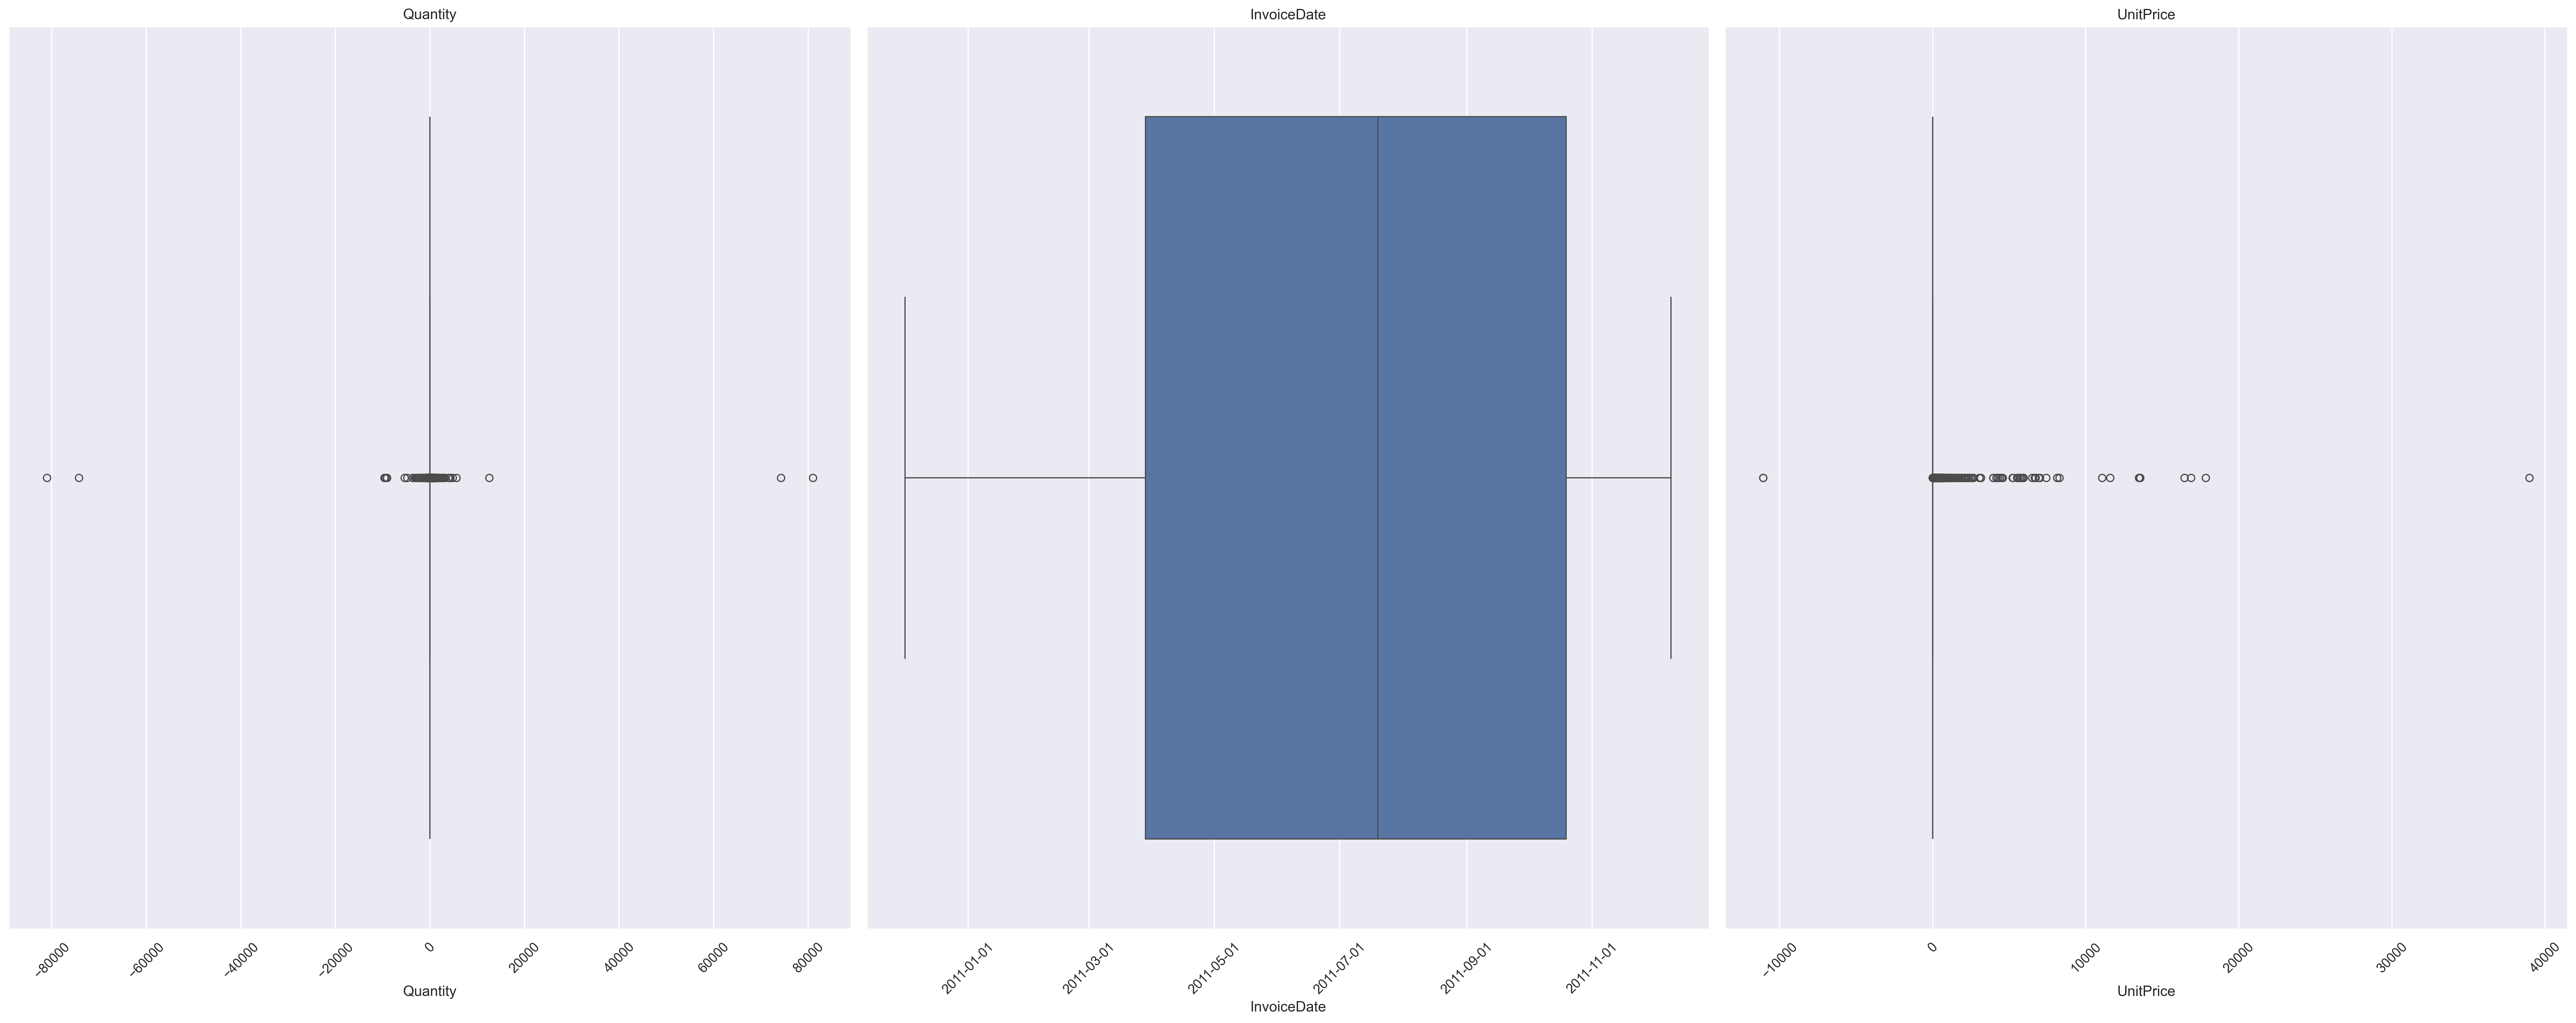

In [24]:
## 异常值检测与处理
# 箱线图
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 12), dpi = 300)
axes = axes.flatten()

box_columns = ['Quantity', 'InvoiceDate', 'UnitPrice']

# 循环绘制每个子图
for i, column in enumerate(box_columns):
    g_previous_box = sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(column)

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(fname='箱线图.png')

#### 2.2.2 异常值处理
删除异常值--每笔交易量与产品单价不可能为负数或零，异常数据直接删除

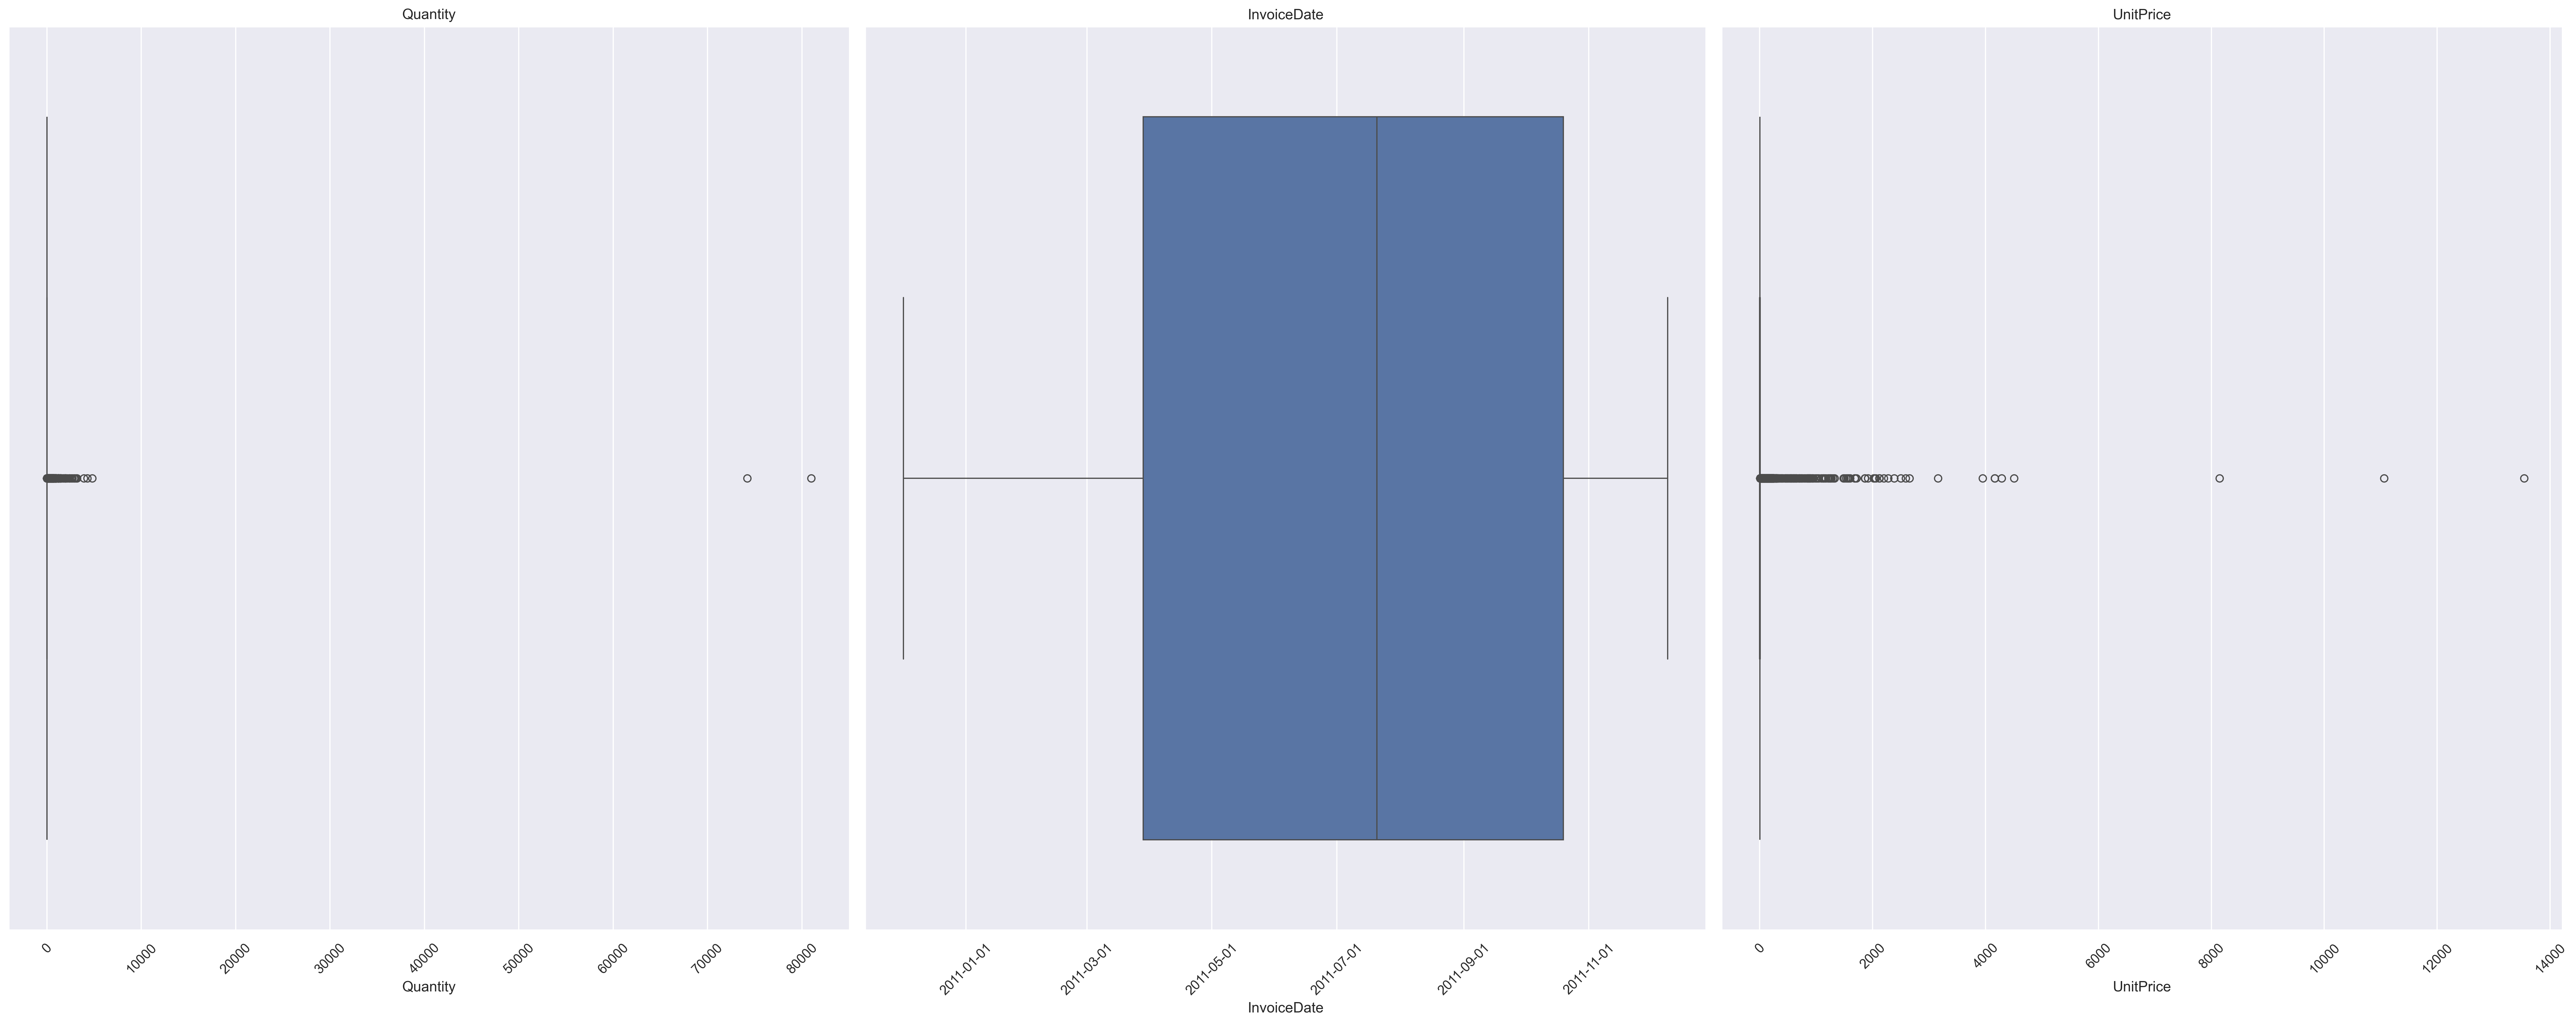

In [25]:
# 异常值处理
# 删除异常值--每笔交易量与产品单价不可能为负数或零，异常数据直接删除
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# 箱线图
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 12), dpi = 300)
axes = axes.flatten()

box_columns = ['Quantity', 'InvoiceDate', 'UnitPrice']

# 循环绘制每个子图
for i, column in enumerate(box_columns):
    g_previous_box = sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(column)

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig(fname='删除异常值后箱线图.png')

### 2.3 缺失值检测与处理
#### 2.3.1 缺失值检测

In [26]:
## 缺失值检测与处理
# 缺失比例
print('缺失值情况及比例：')
total_rows = data.shape[0]
missing_value_sums = data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")

缺失值情况及比例：
InvoiceNo: 缺失值数量为 0，缺失值比例为 0.00%
StockCode: 缺失值数量为 0，缺失值比例为 0.00%
Description: 缺失值数量为 0，缺失值比例为 0.00%
Quantity: 缺失值数量为 0，缺失值比例为 0.00%
InvoiceDate: 缺失值数量为 0，缺失值比例为 0.00%
UnitPrice: 缺失值数量为 0，缺失值比例为 0.00%
CustomerID: 缺失值数量为 132220，缺失值比例为 24.94%
Country: 缺失值数量为 0，缺失值比例为 0.00%


#### 2.3.2 缺失值处理
删除缺失值--观察到仅用户ID存在缺失值，对其插补并不合理，因此直接删除缺失值所在的全部数据

In [28]:
# 缺失值处理
# 删除缺失值--观察到仅用户ID存在缺失值，对其插补并不合理，因此直接删除缺失值所在的全部数据
data = data.dropna()

In [29]:
# 缺失比例
print('缺失值情况及比例：')
total_rows = data.shape[0]
missing_value_sums = data.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")


缺失值情况及比例：
InvoiceNo: 缺失值数量为 0，缺失值比例为 0.00%
StockCode: 缺失值数量为 0，缺失值比例为 0.00%
Description: 缺失值数量为 0，缺失值比例为 0.00%
Quantity: 缺失值数量为 0，缺失值比例为 0.00%
InvoiceDate: 缺失值数量为 0，缺失值比例为 0.00%
UnitPrice: 缺失值数量为 0，缺失值比例为 0.00%
CustomerID: 缺失值数量为 0，缺失值比例为 0.00%
Country: 缺失值数量为 0，缺失值比例为 0.00%


### 2.4 重复值检测与处理
#### 2.4.1 重复值检测

In [30]:
## 重复值检测与处理
# 重复值行数
duplicate_rows = data.duplicated().sum()
print(f'数据中重复值的行数为: {duplicate_rows}')

数据中重复值的行数为: 5192


#### 2.4.2 重复值处理
删除重复值，只保留第一次出现的行

In [31]:
# 删除重复值，只保留第一次出现的行
data = data.drop_duplicates()

In [32]:
# 再次查看重复值情况，确认是否已删除干净
duplicate_rows_after = data.duplicated().sum()
print(f'处理后数据中重复值的行数为: {duplicate_rows_after}')


处理后数据中重复值的行数为: 0


### 2.5 处理后数据情况

In [33]:
print('处理后的数据基本情况：')
print(data.describe())

处理后的数据基本情况：
            Quantity                    InvoiceDate      UnitPrice  \
count  392692.000000                         392692  392692.000000   
mean       13.119702  2011-07-10 19:13:07.771892480       3.125914   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 12:02:00       1.950000   
75%        12.000000            2011-10-20 12:53:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       180.492832                            NaN      22.241836   

          CustomerID  
count  392692.000000  
mean    15287.843865  
min     12346.000000  
25%     13955.000000  
50%     15150.000000  
75%     16791.000000  
max     18287.000000  
std      1713.539549  


### 2.6 计算RFM
#### 2.6.1 计算 R（Recency）
在InvoiceDate中提取日期Date  
在InvoiceDate中提取时间Time  
交易金额 = 交易量 * 交易价格

In [34]:
## 计算RFM
# 准备日期、时间与交易金额数据
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date  # 在InvoiceDate中提取日期
data['Time'] = data['InvoiceDate'].dt.time  # 在InvoiceDate中提取时间
data['Price'] = data['Quantity'] * data['UnitPrice']  # 在交易金额 = 交易量 * 交易价格

# 计算 R（Recency）
data['Date'] = pd.to_datetime(data['Date'])
max_ = data.groupby('CustomerID').Date.max() # 计算最近一次消费日期
max_data = data.Date.max() + dt.timedelta(days=1)
R = max_.map(lambda x: (max_data - x).days)

print('R前五行数据：')
print(R.head())

print('R的基本情况：')
print(R.describe())

R前五行数据：
CustomerID
12346.0    326
12347.0      3
12348.0     76
12349.0     19
12350.0    311
Name: Date, dtype: int64
R的基本情况：
count    4338.000000
mean       93.059474
std       100.012264
min         1.000000
25%        18.000000
50%        51.000000
75%       142.750000
max       374.000000
Name: Date, dtype: float64


#### 2.6.2 计算 F（Frequency）

In [35]:
# 计算 F（Frequency）
unique_f = data.drop_duplicates(subset=['InvoiceNo'])
F = unique_f.groupby('CustomerID').size()

print('F前五行数据：')
print(F.head())

print('F的基本情况：')
print(F.describe())

F前五行数据：
CustomerID
12346.0    1
12347.0    7
12348.0    4
12349.0    1
12350.0    1
dtype: int64
F的基本情况：
count    4338.000000
mean        4.272015
std         7.697998
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       209.000000
dtype: float64


#### 2.6.3 M（Monetary）

In [36]:
# 计算 M（Monetary）
M = data.groupby('CustomerID').Price.sum()

print('M前五行数据：')
print(M.head())

print('M的基本情况：')
print(M.describe())

M前五行数据：
CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Price, dtype: float64
M的基本情况：
count      4338.000000
mean       2048.688081
std        8985.230220
min           3.750000
25%         306.482500
50%         668.570000
75%        1660.597500
max      280206.020000
Name: Price, dtype: float64


#### 2.6.4 整合RFM

In [37]:
# 整合
RFM = pd.DataFrame([R,F,M]).T
RFM.columns = ['R','F','M']

print('RFM前五行数据：')
print(RFM.head())

print('RFM的基本情况：')
print(RFM.describe())

RFM前五行数据：
                R    F         M
CustomerID                      
12346.0     326.0  1.0  77183.60
12347.0       3.0  7.0   4310.00
12348.0      76.0  4.0   1797.24
12349.0      19.0  1.0   1757.55
12350.0     311.0  1.0    334.40
RFM的基本情况：
                 R            F              M
count  4338.000000  4338.000000    4338.000000
mean     93.059474     4.272015    2048.688081
std     100.012264     7.697998    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.750000     5.000000    1660.597500
max     374.000000   209.000000  280206.020000


### 2.7 RFM数据概览

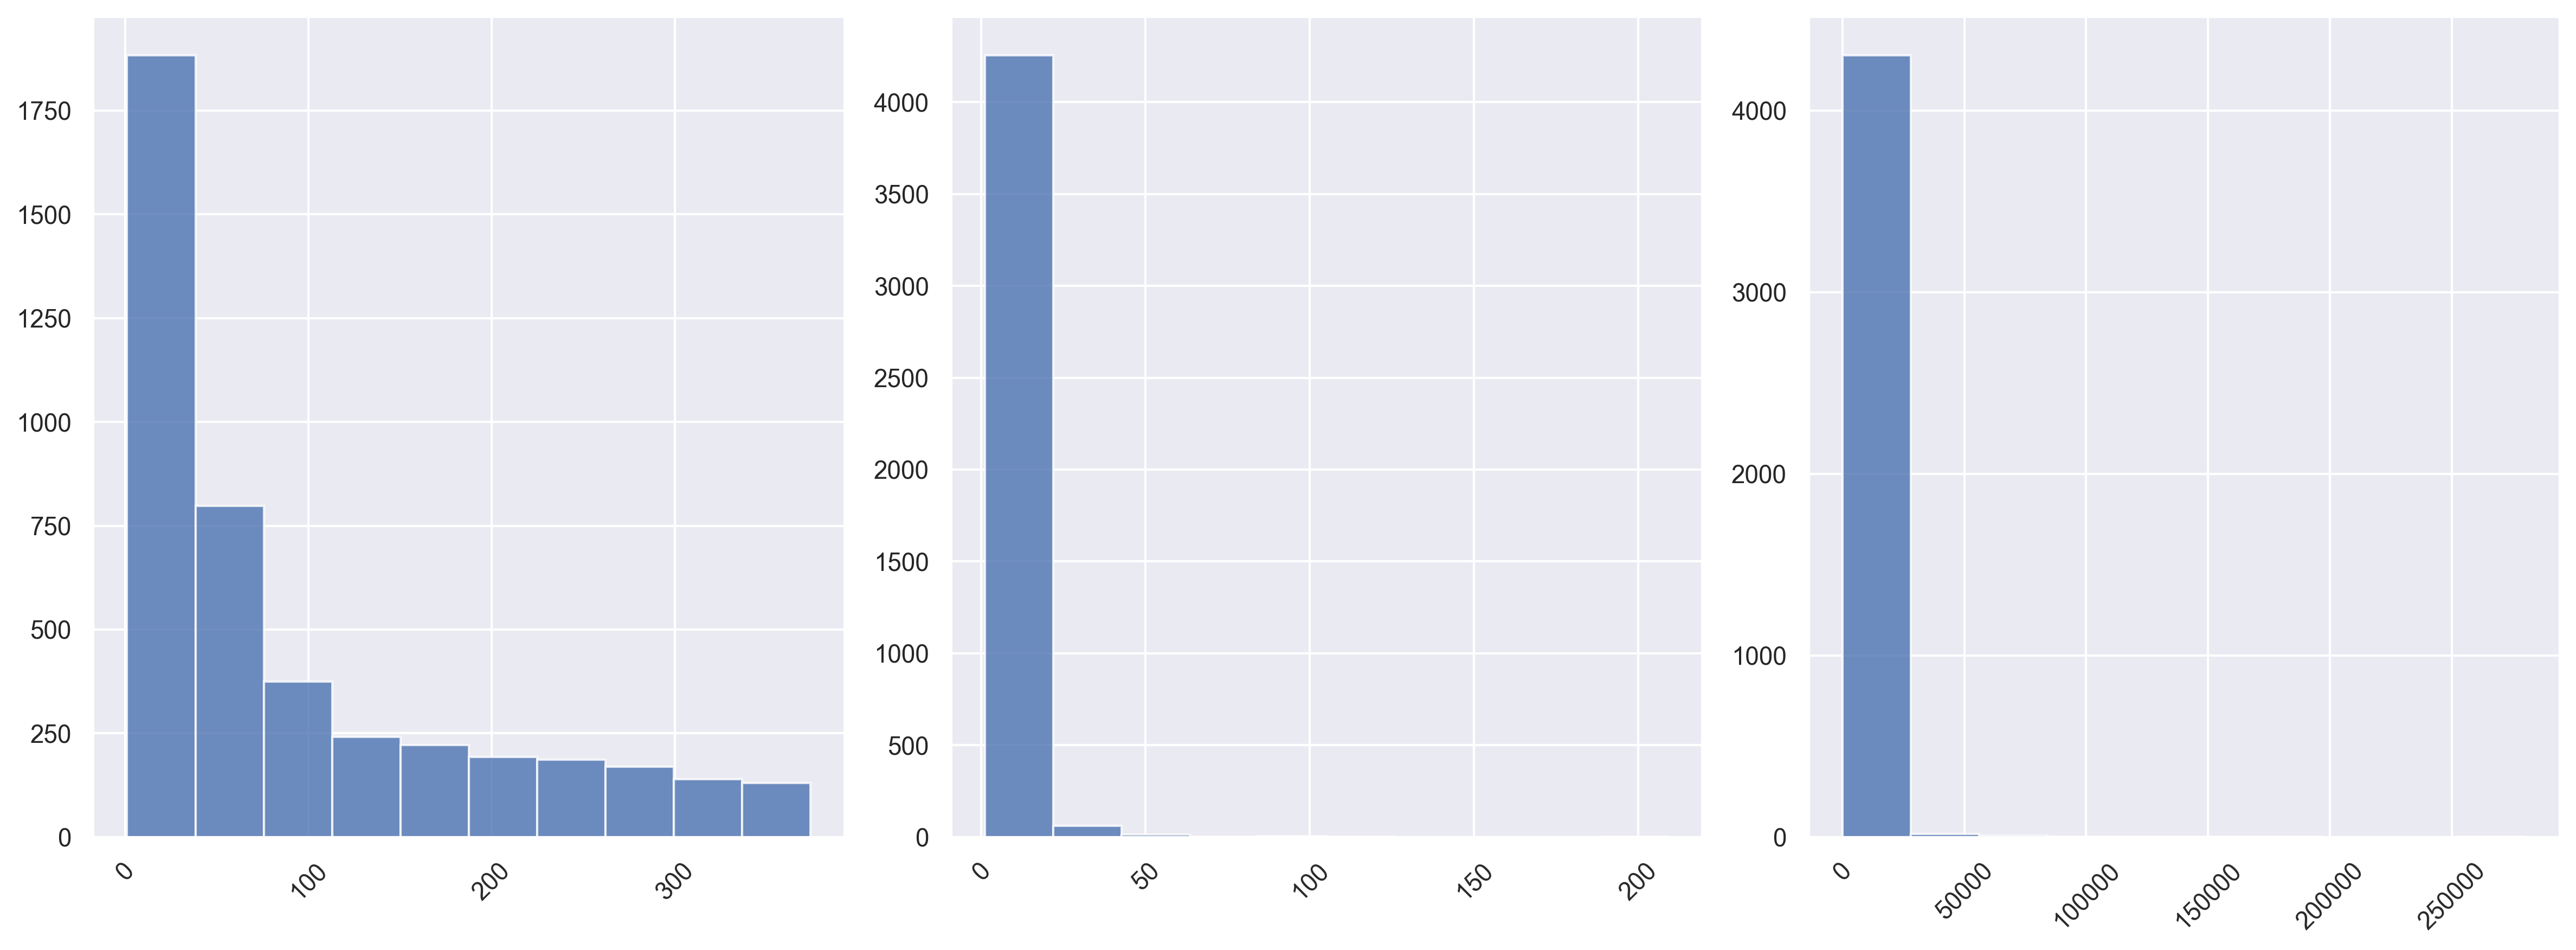

In [38]:
## 数据概览
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), dpi = 300)
axes = axes.flatten()
for i, column in enumerate(RFM.columns):
    g = axes[i].hist(data=RFM, x=column, color='b', alpha=0.8)
    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig(fname="RFM数据概览.png")

### 2.8 RFM密度函数

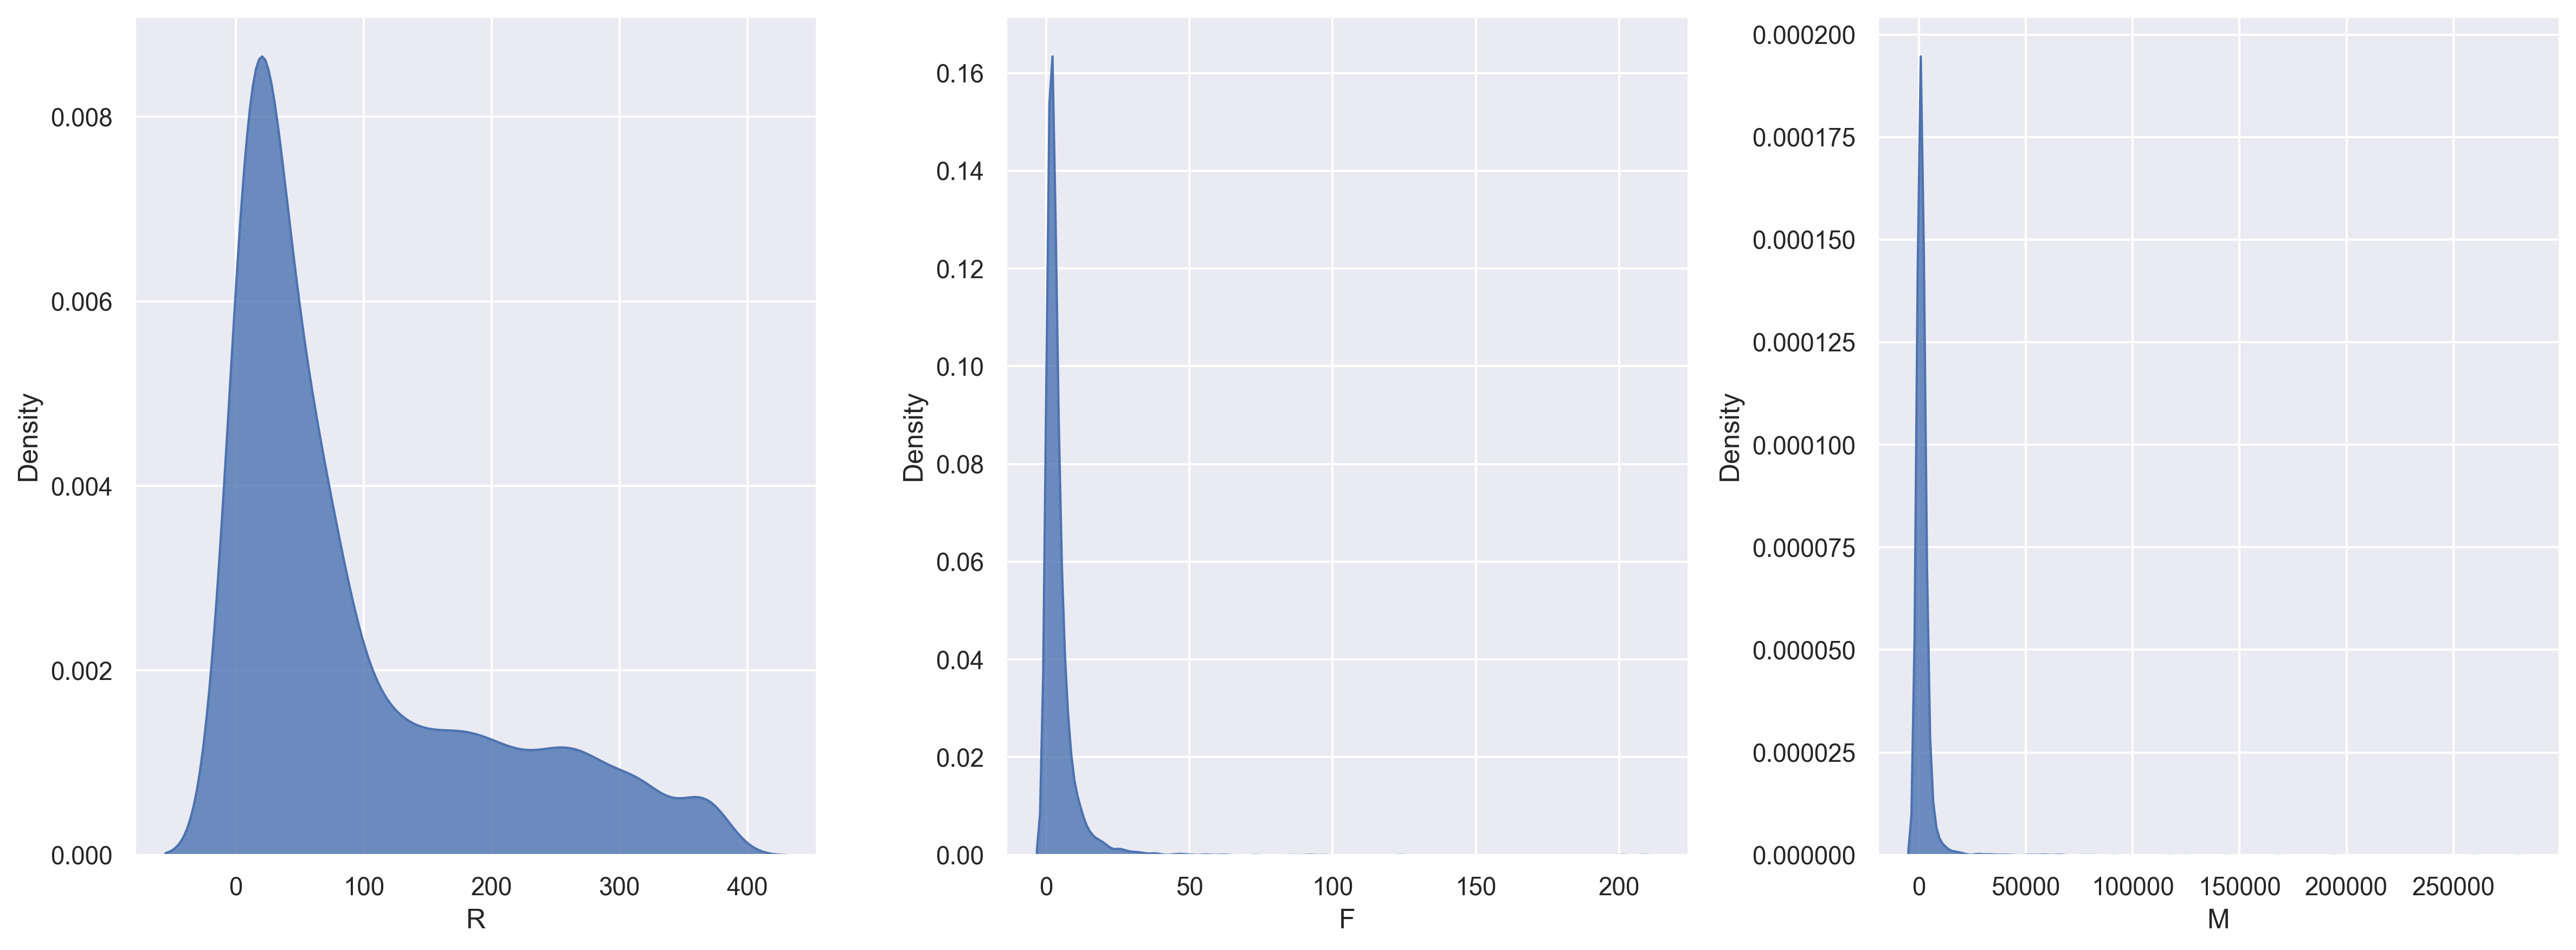

In [39]:
## 密度函数
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), dpi = 300)
axes = axes.flatten()
for i, column in enumerate(RFM.columns):
    g = sns.kdeplot(data=RFM, x=column, fill=True, color='b', alpha=0.8, ax=axes[i])
    axes[i].set_xlabel(RFM.columns[i])
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.savefig(fname="RFM密度函数图.png")

### 2.9 Box-Cox变换
#### 2.9.1 求解最佳$\lambda$并变换
Box-Cox变换公式：
$$
y^{(\lambda)} = \left\{\begin{matrix} \frac{y^{\lambda}-1}{\lambda} &\lambda \neq 0 \\ ln(y) &\lambda = 0 \end{matrix}\right.
$$
变换需要满足：
$$
\frac{y_{max}}{y_{min}} > 2
$$

In [40]:
## BOX-COX变换
transformed_data = {}
lambda_values = {}
for col in RFM.columns:
    col_data = RFM[col].values
    transformed_col_data, lambda_value = boxcox(col_data)
    transformed_data[col] = transformed_col_data
    lambda_values[col] = lambda_value
RFM_BC = pd.DataFrame(transformed_data)

print('变换后的前五行数据：')
print(RFM_BC.head())

print("估计的lambda参数:")
for col, lambda_val in lambda_values.items():
    print(f"{col}: {lambda_val}")

变换后的前五行数据：
          R         F         M
0  9.481099  0.000000  7.252373
1  1.200122  1.339109  5.993348
2  6.225829  1.056519  5.546730
3  3.752632  0.000000  5.534888
4  9.363610  0.000000  4.589198
估计的lambda参数:
R: 0.15858430799296988
F: -0.41141581487240475
M: -0.08477614913364412


#### 2.9.2 变换后的密度函数

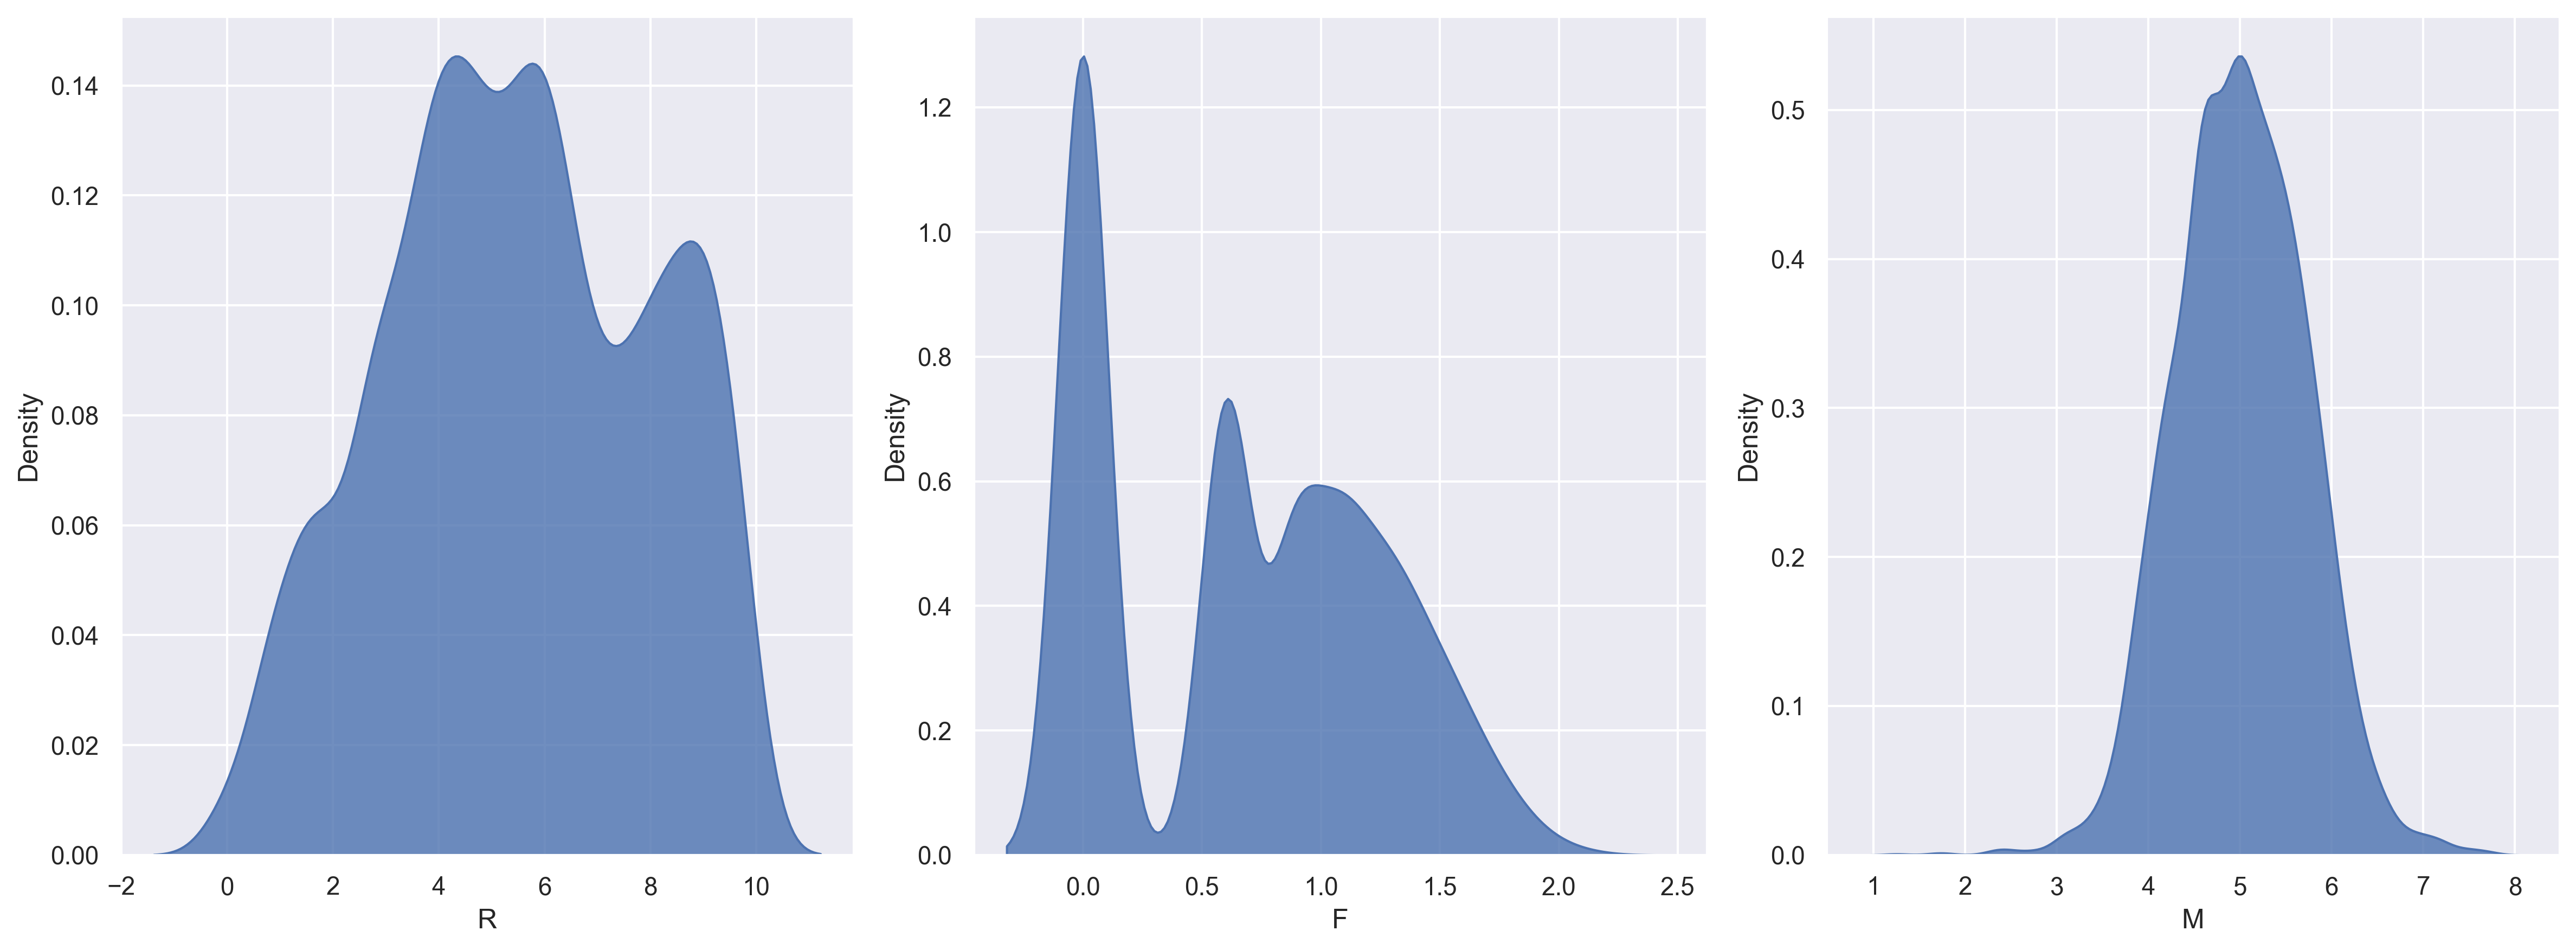

In [41]:
## 变换后的密度函数
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), dpi = 300)
axes = axes.flatten()
for i, column in enumerate(RFM_BC.columns):
    g = sns.kdeplot(data=RFM_BC, x=column, fill=True, color='b', alpha=0.8, ax=axes[i])
    axes[i].set_xlabel(RFM_BC.columns[i])
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.savefig(fname="RFM_BC密度函数图.png")

### 2.10 归一化

In [42]:
## 归一化
# 去除量纲的影响
scaler = MinMaxScaler()
RFM_BC_normalized = scaler.fit_transform(RFM_BC)
RFM_BC_normalized = pd.DataFrame(RFM_BC_normalized, columns=RFM_BC.columns)

print('归一化后的前五行数据：')
print(RFM_BC_normalized.head())

归一化后的前五行数据：
          R         F         M
0  0.964629  0.000000  0.927317
1  0.122103  0.619743  0.732795
2  0.633430  0.488960  0.663792
3  0.381801  0.000000  0.661962
4  0.952675  0.000000  0.515851


## 三、聚类分析
### 3.1 Hierarchical clustering
层次聚类（分层聚类、谱系聚类）
#### 3.1.1 谱系图

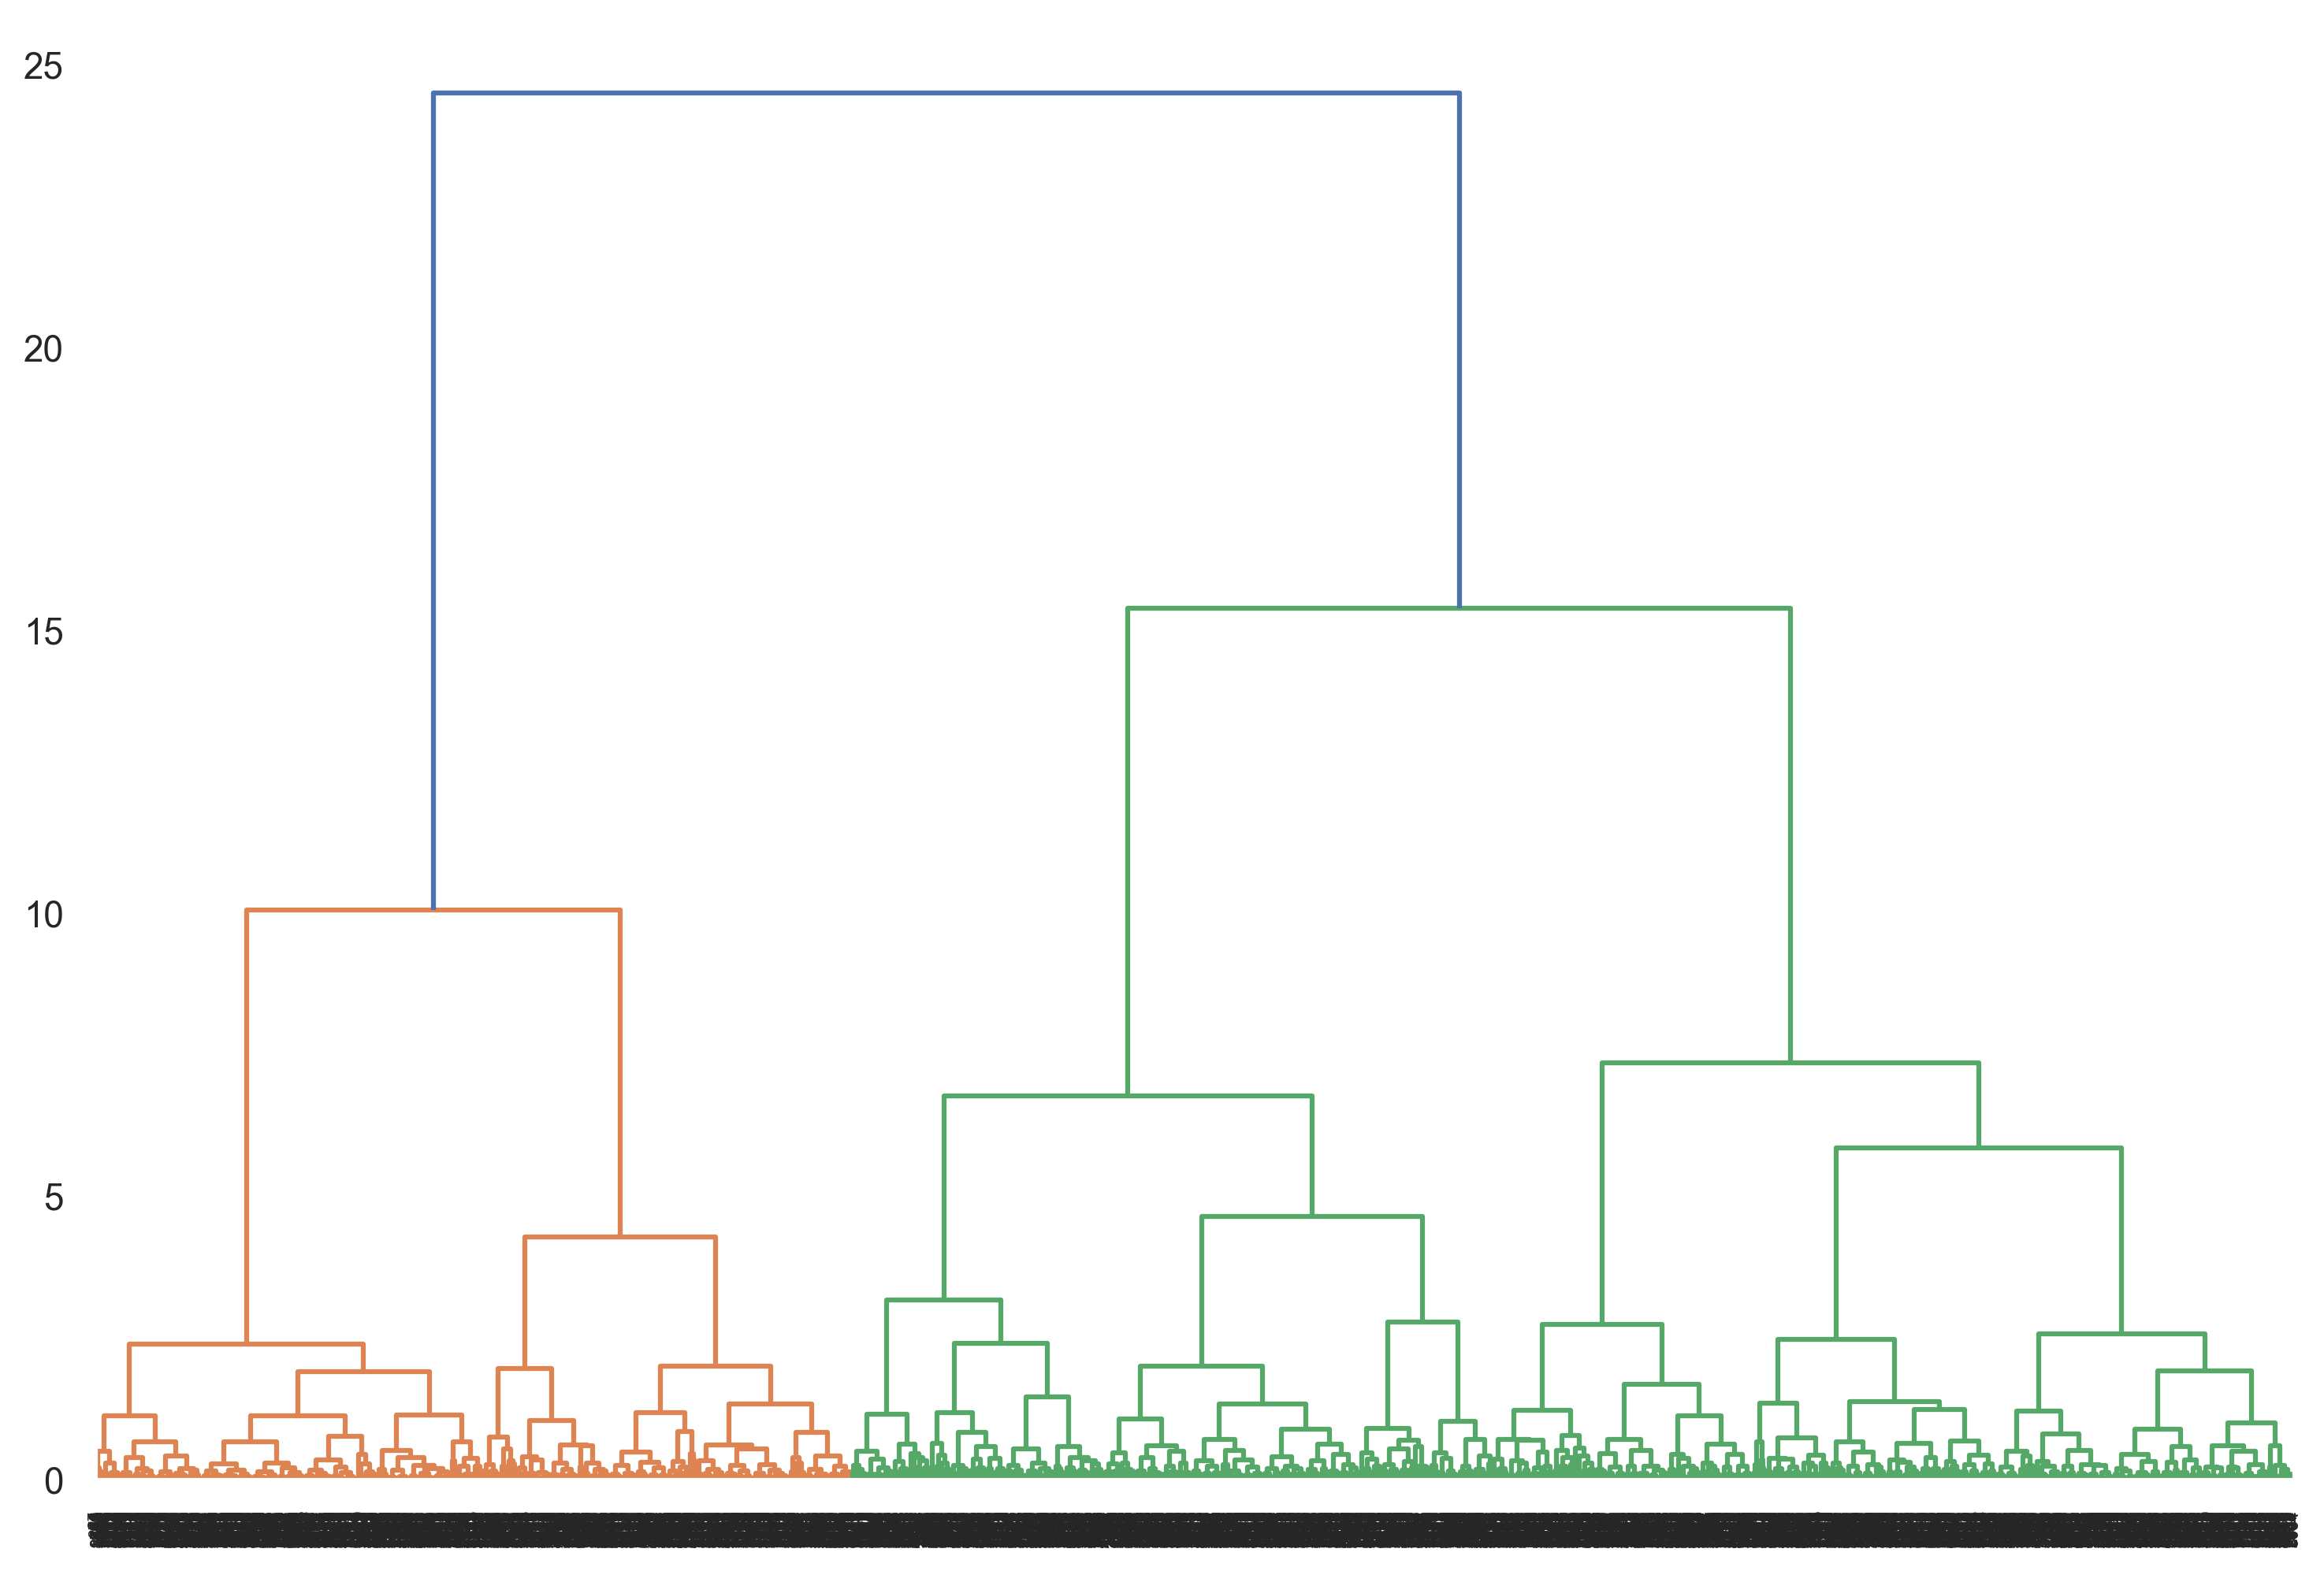

In [43]:
#--------------------------------3、聚类分析--------------------------------#
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation, SpectralClustering, DBSCAN

## 3.1 Hierarchical clustering
# 层次聚类
linkage_matrix = linkage(RFM_BC_normalized, method='ward')  #'complete'、'average'

# 绘制聚类树（树状图）
plt.figure(figsize=(12, 8), dpi=300)
dendrogram(linkage_matrix)
plt.savefig(fname='聚类树.png')

#### 3.1.2 确定聚类数并聚类
根据谱系图讲结果聚成7类，也可以根据业务要求聚成8类

In [44]:
## 确定聚类数量并进行聚类
n_clusters = 7
cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
RDM_hierarchical = RFM.assign(cluster=cluster_labels)

print(RDM_hierarchical.groupby('cluster').agg({'R': ['mean'], 'F': ['mean'], 'M': ['mean','sum', 'count']}).round(2))

              R      F        M                  
           mean   mean     mean         sum count
cluster                                          
1        255.49   1.00   437.07   335672.00   768
2         53.12   1.00   383.37   278324.46   726
3         10.07  16.79  9820.60  4871019.57   496
4         14.63   4.48  1831.29  1408258.34   769
5        183.85   2.61   919.60   472672.27   514
6         71.18   5.35  2237.54  1071780.53   479
7         41.06   2.31   767.03   449481.72   586


#### 3.1.3 聚类结果可视化

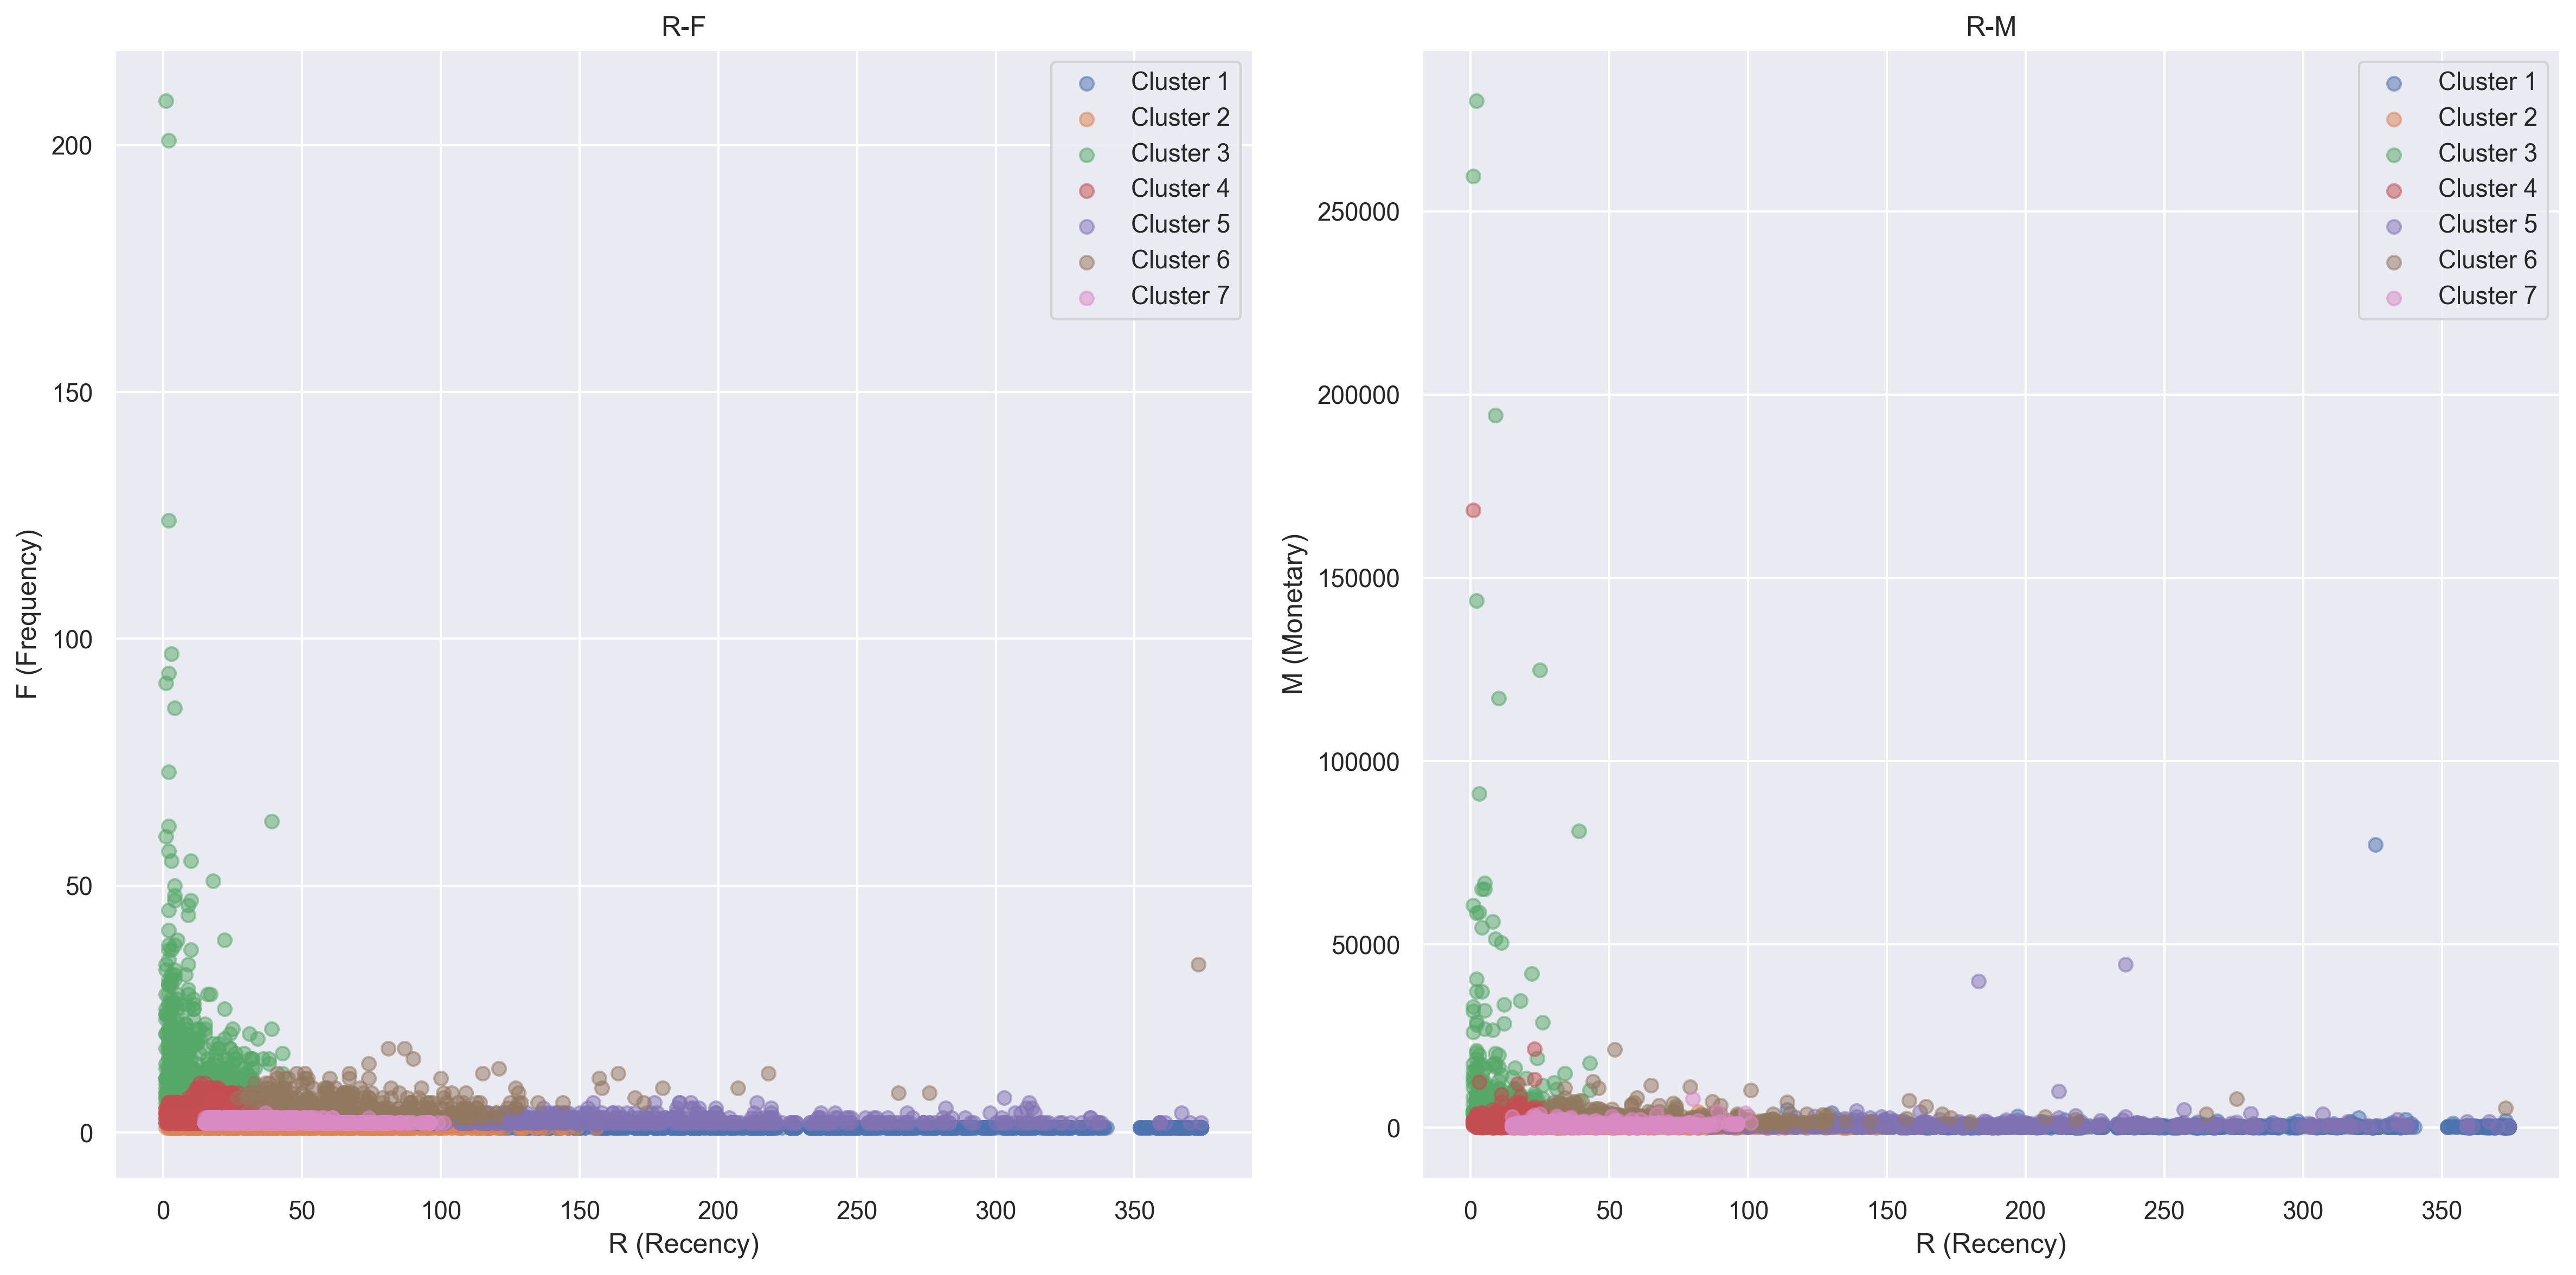

In [45]:
R_hierarchical = RDM_hierarchical['R']
F_hierarchical = RDM_hierarchical['F']
M_hierarchical = RDM_hierarchical['M']
clusters_hierarchical = RDM_hierarchical['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()

# 绘制 R-F 图
for cluster in set(clusters_hierarchical):
    mask = (clusters_hierarchical == cluster)
    axes[0].scatter(R_hierarchical[mask], F_hierarchical[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters_hierarchical):
    mask = (clusters_hierarchical == cluster)
    axes[1].scatter(R_hierarchical[mask], M_hierarchical[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='HierarchicalClustering聚类结果.png')

### 3.2 K-means
#### 3.2.1 K值选择
##### 肘部法则

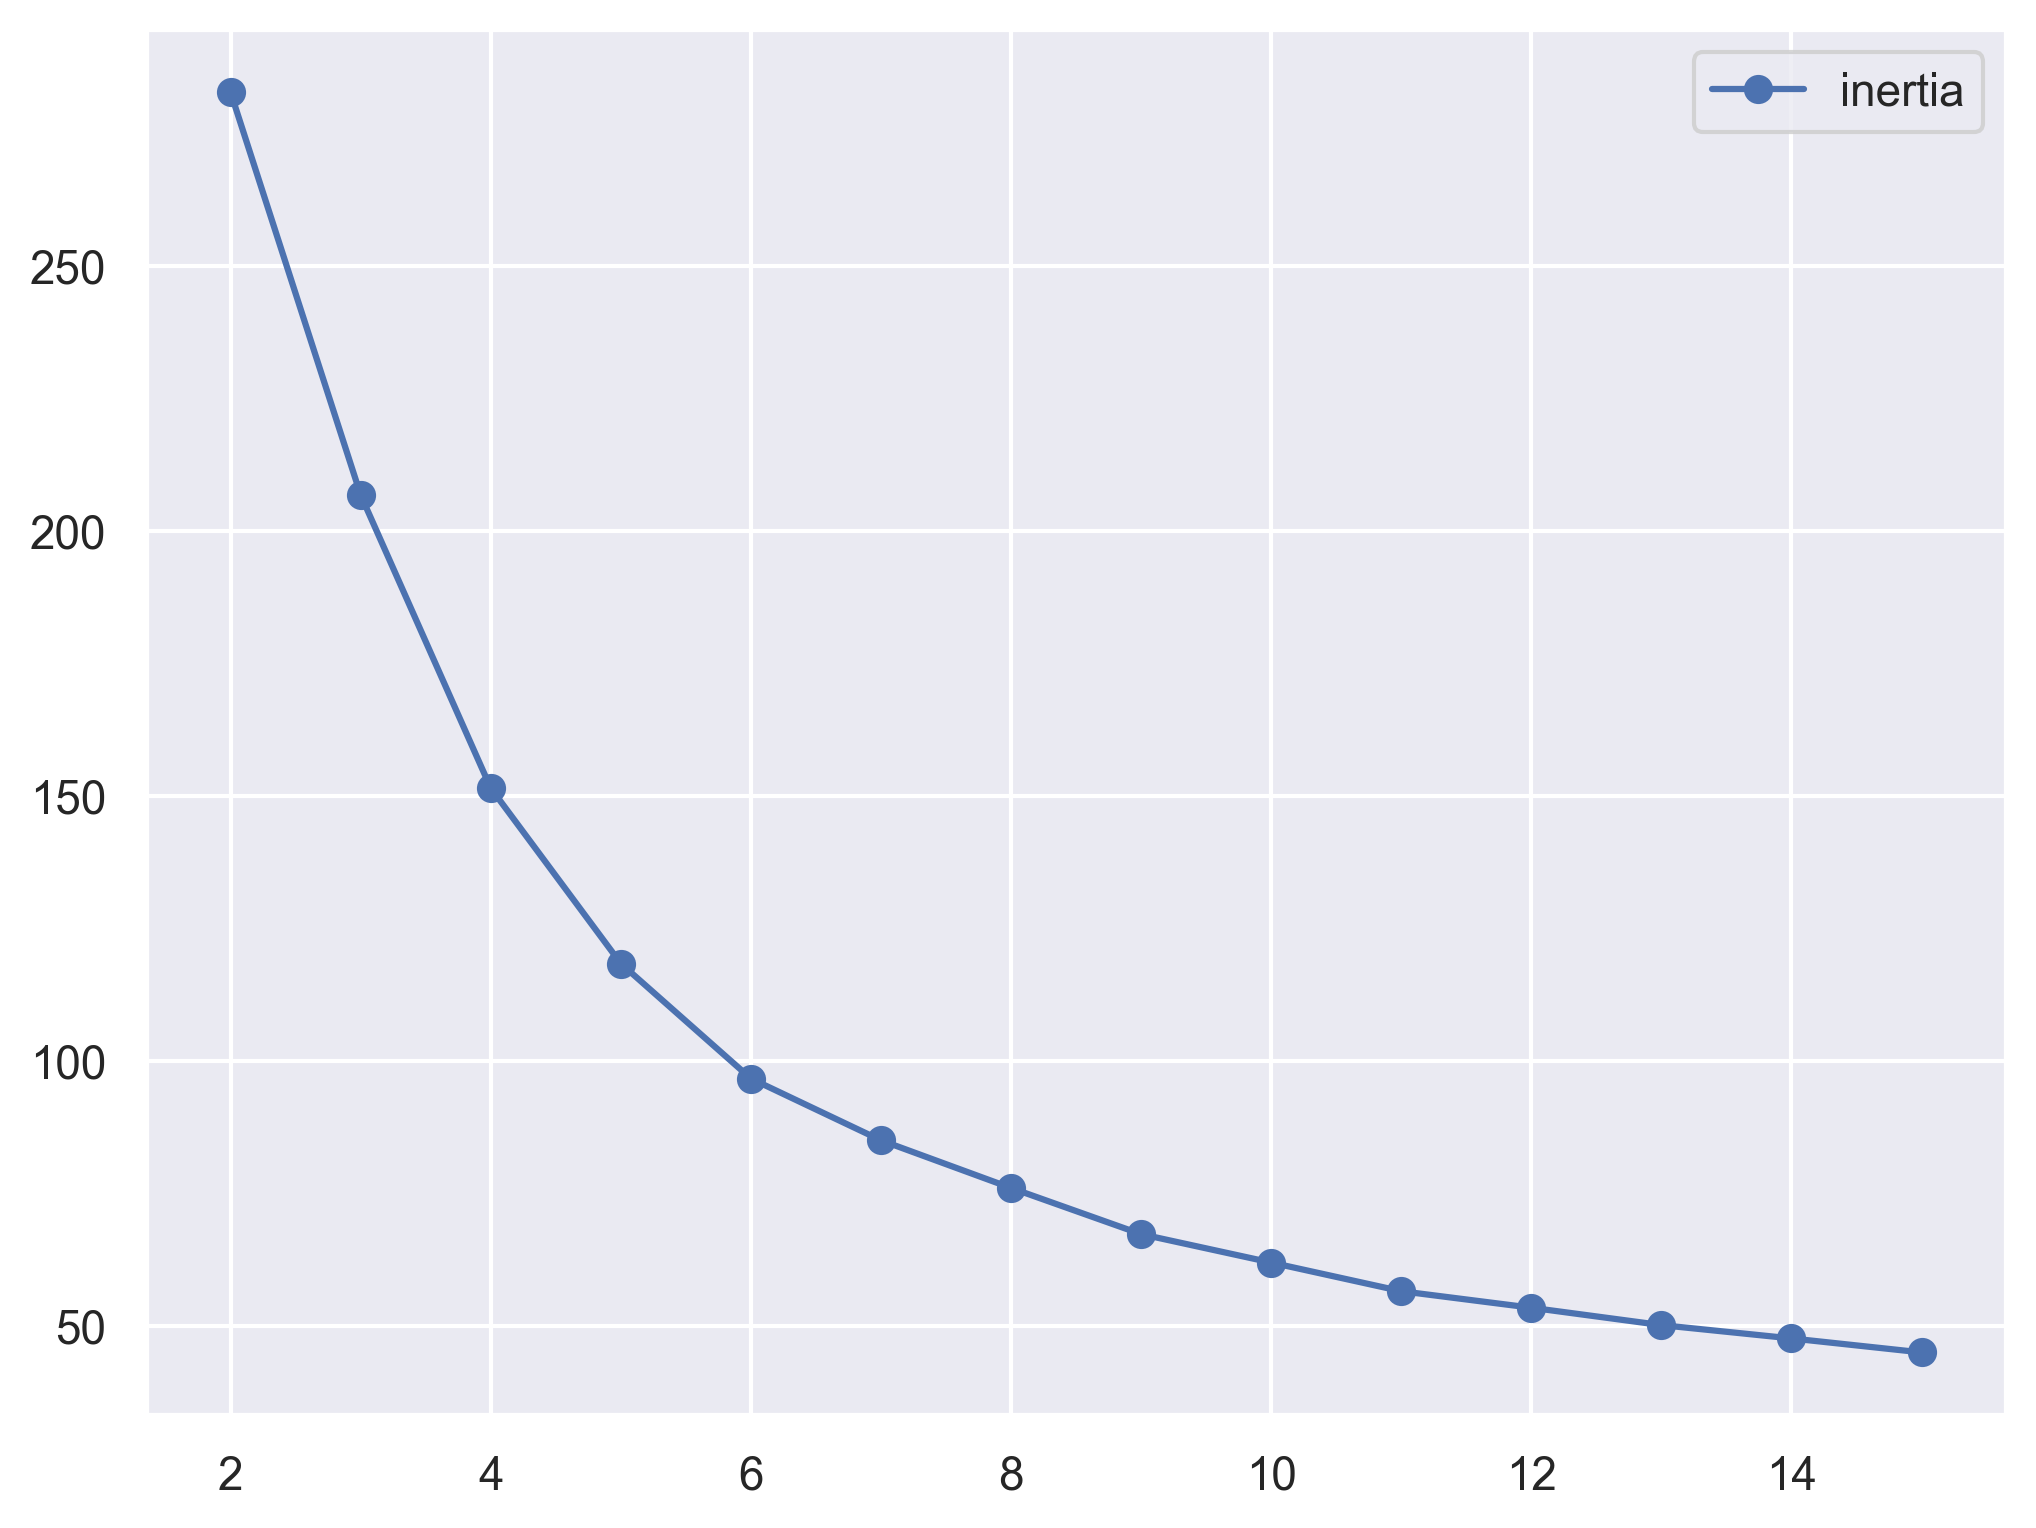

In [46]:
## 3.2 K-means
# K值选择
# 肘部法则
em=[]
ks=range (2, 16)
for k in ks:
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(RFM_BC_normalized)
    em.append(kc.inertia_)

plt.figure(figsize=(8, 6), dpi=300)
plt. plot (ks, em, marker='o', label='inertia')
plt.legend(loc='upper right')
plt.savefig(fname='KMeans肘部法则.png')

##### 轮廓系数

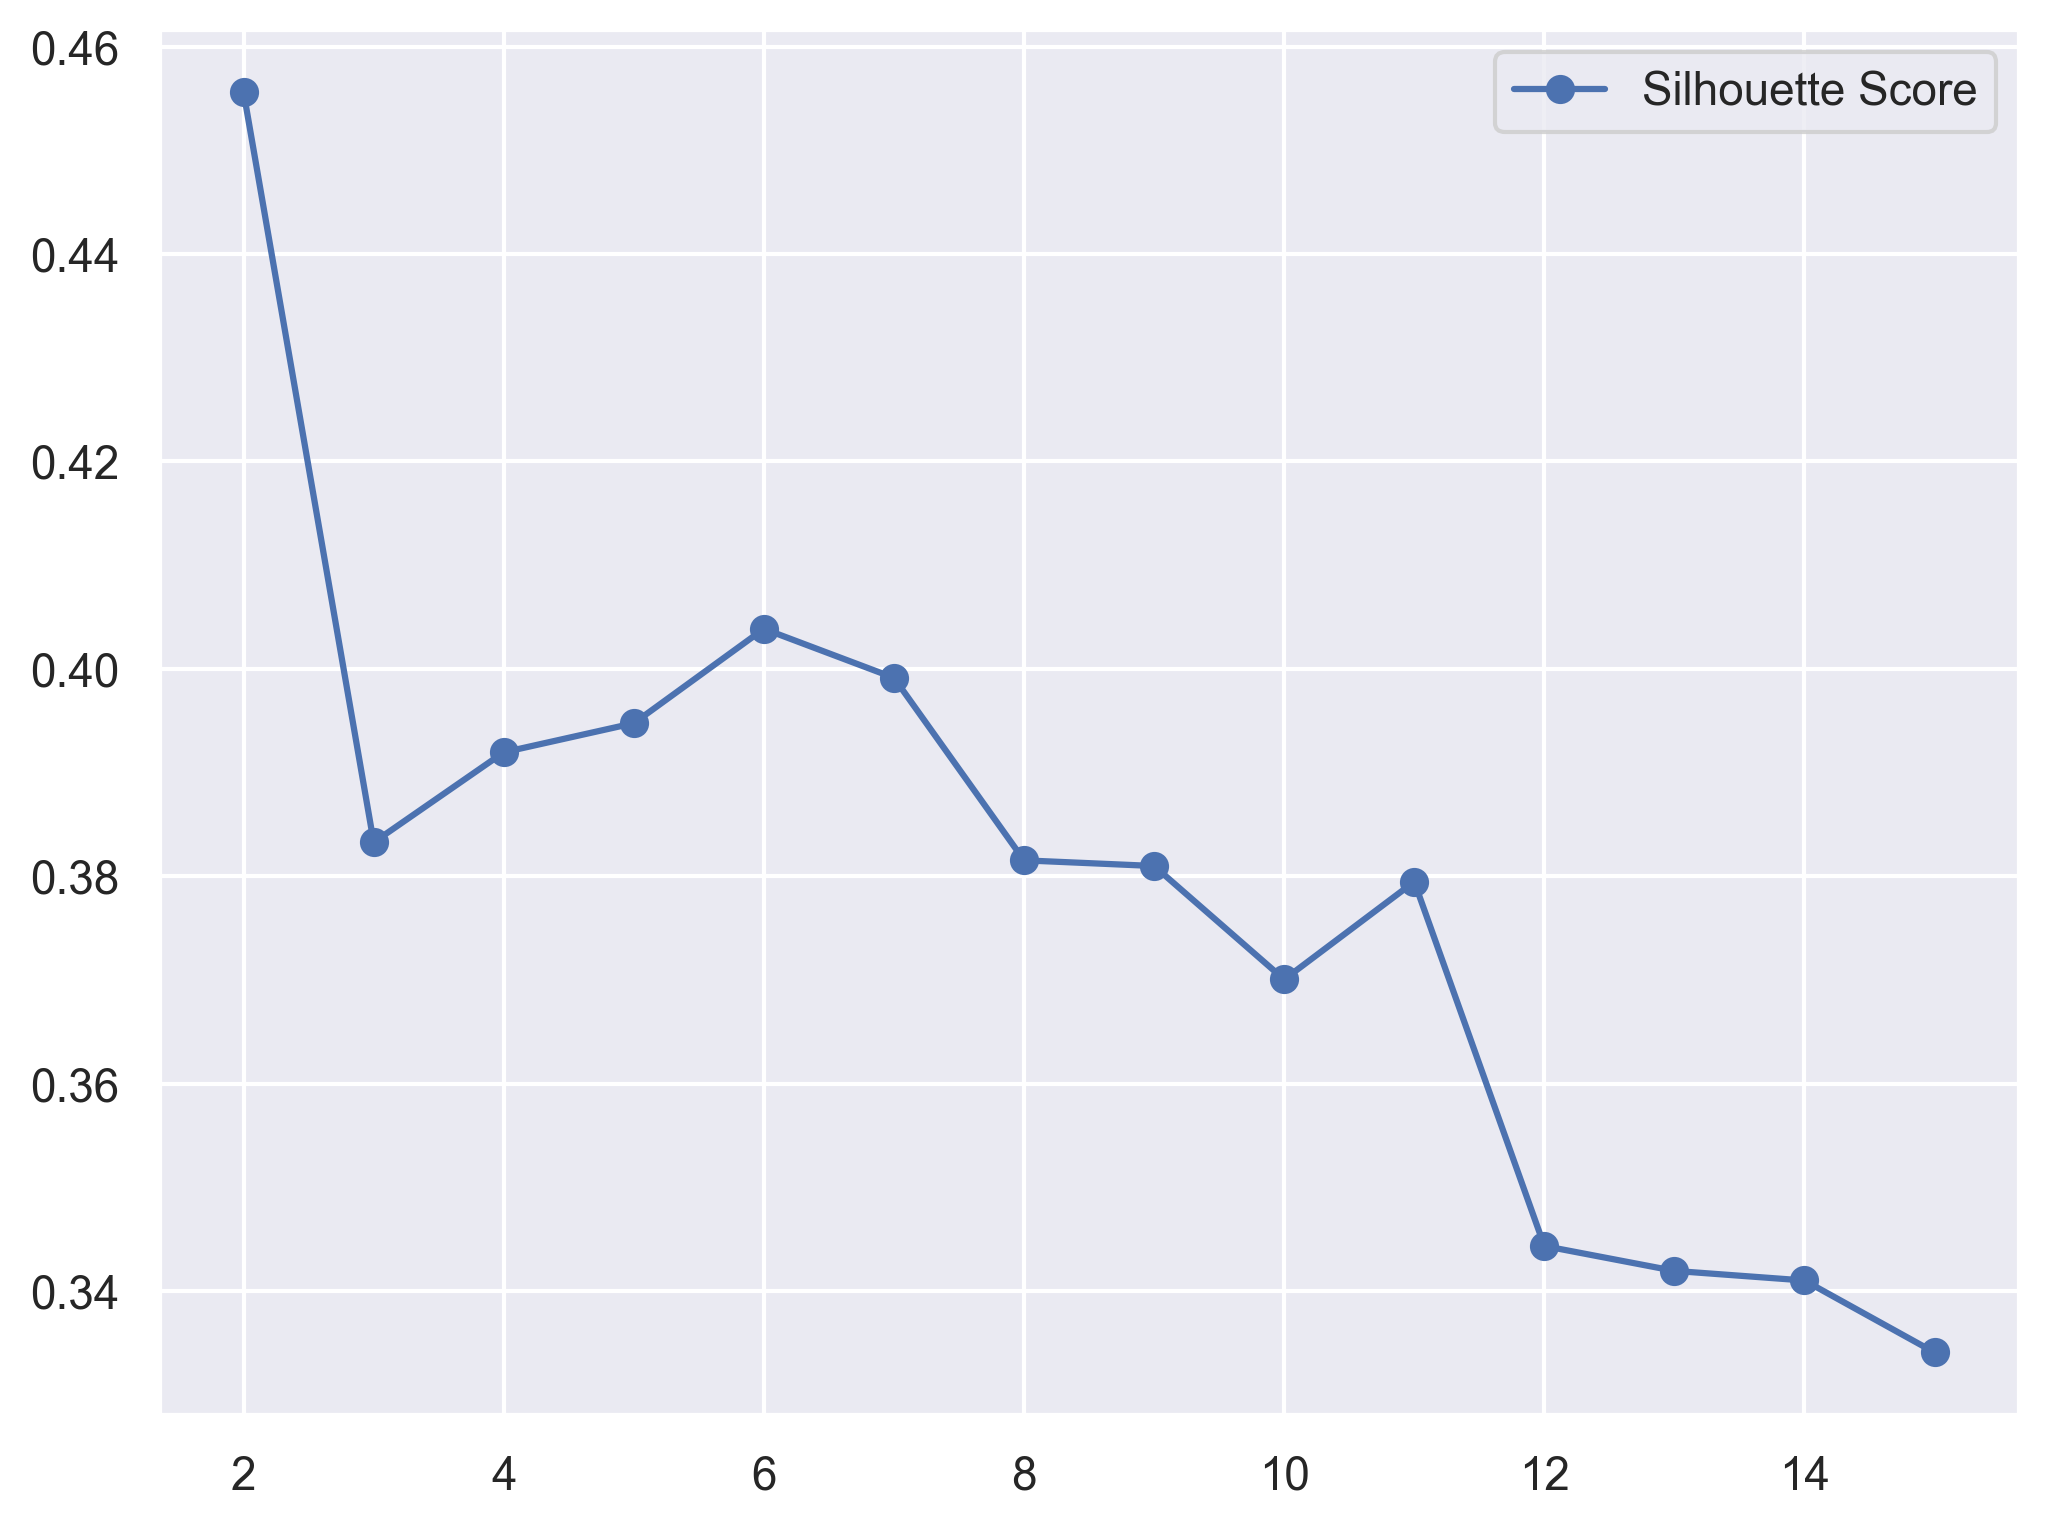

In [47]:
# 轮廓系数
silhouette_scores = []
ks=range (2, 16)
for k in ks:
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(RFM_BC_normalized)
    score = silhouette_score(RFM_BC_normalized, kc.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(ks, silhouette_scores, marker='o', label='Silhouette Score')
plt.legend(loc='upper right')
plt.savefig(fname='KMeans轮廓系数.png')

#### 3.2.2 确定K值并聚类
综合肘部法则和轮廓系数确定K值为6，也可以更具业务需要聚成8类

In [48]:
# 聚类
model_kmeans =  KMeans(n_clusters=6, random_state=1)  ## 肘部法则和轮廓系数确定k为6，实际业务可以确定为8
model_kmeans.fit(RFM_BC_normalized)
cluster_labels = model_kmeans.labels_
RDM_kmeans = RFM.assign(cluster=cluster_labels)
print(RDM_kmeans.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R      F        M                  
           mean   mean     mean         sum count
cluster                                          
0         21.92   2.63   837.18   611979.76   731
1         45.68   6.56  2777.85  1975051.50   711
2         47.92   1.00   392.85   263604.21   671
3        147.31   2.61   951.51   749786.70   788
4          7.04  13.66  8028.04  4937243.02   615
5        246.51   1.00   425.24   349543.70   822


#### 3.2.3 聚类结果可视化

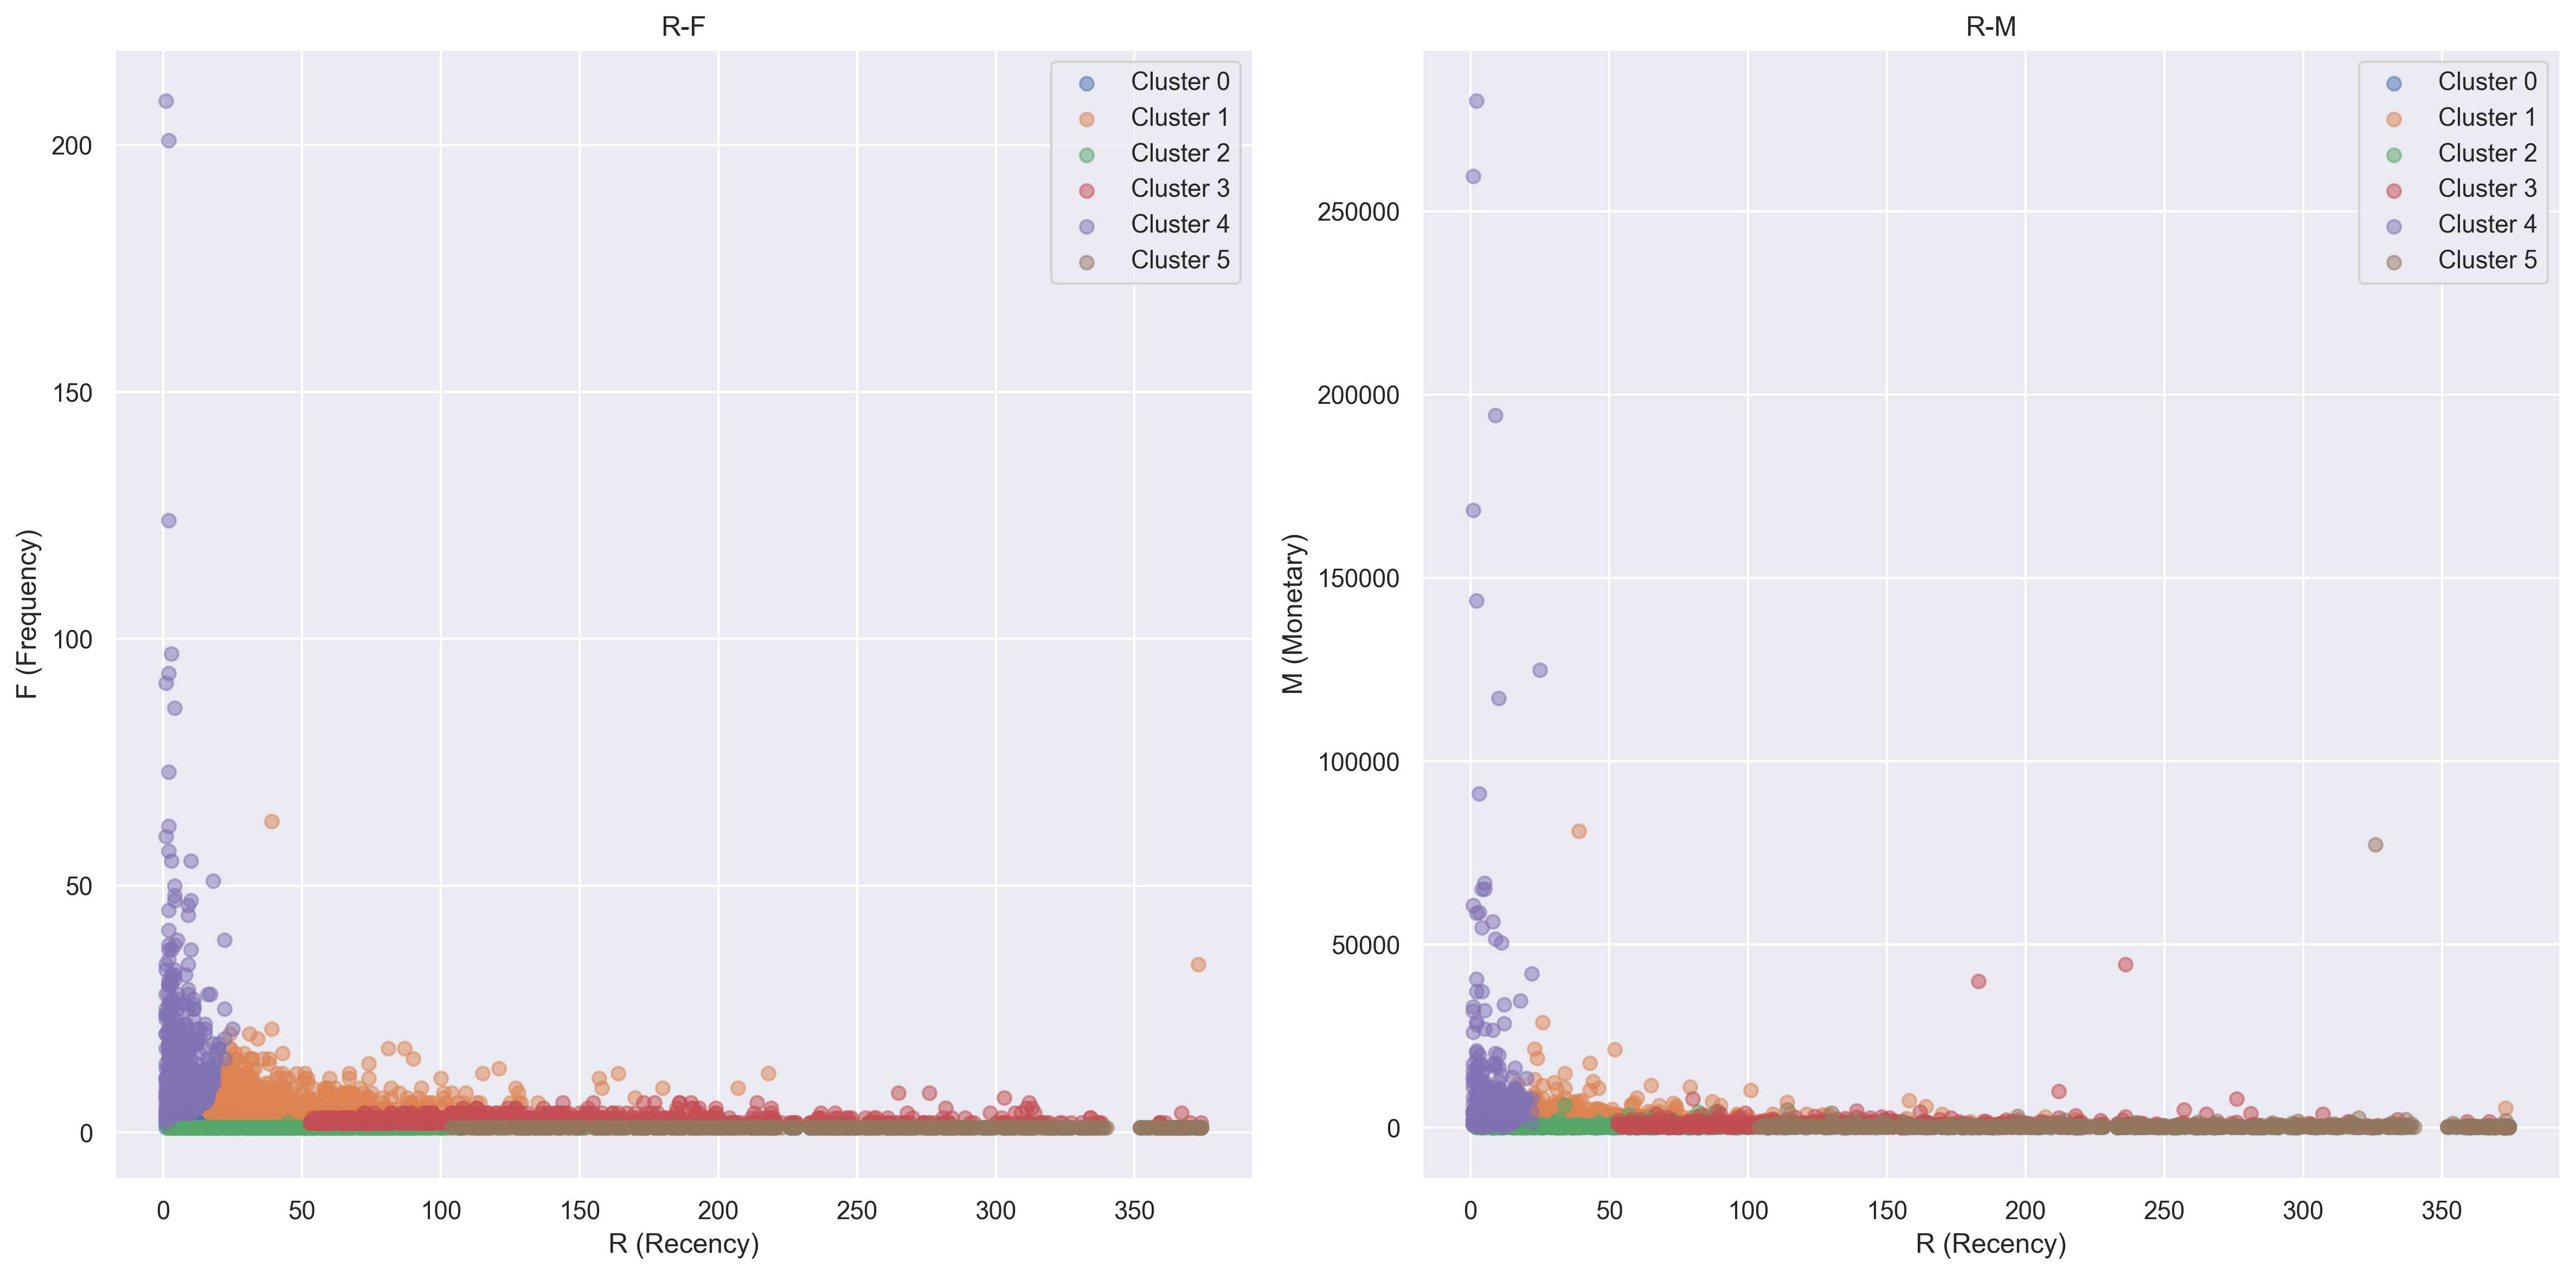

In [49]:
# 聚类结果可视化
R = RDM_kmeans['R']
F = RDM_kmeans['F']
M = RDM_kmeans['M']
clusters = RDM_kmeans['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()
# 绘制 R-F 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[0].scatter(R[mask], F[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[1].scatter(R[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='KMeans聚类结果.png')

### 3.3 MiniBatchKMeans
#### 3.3.1 K值选择
##### 肘部法则

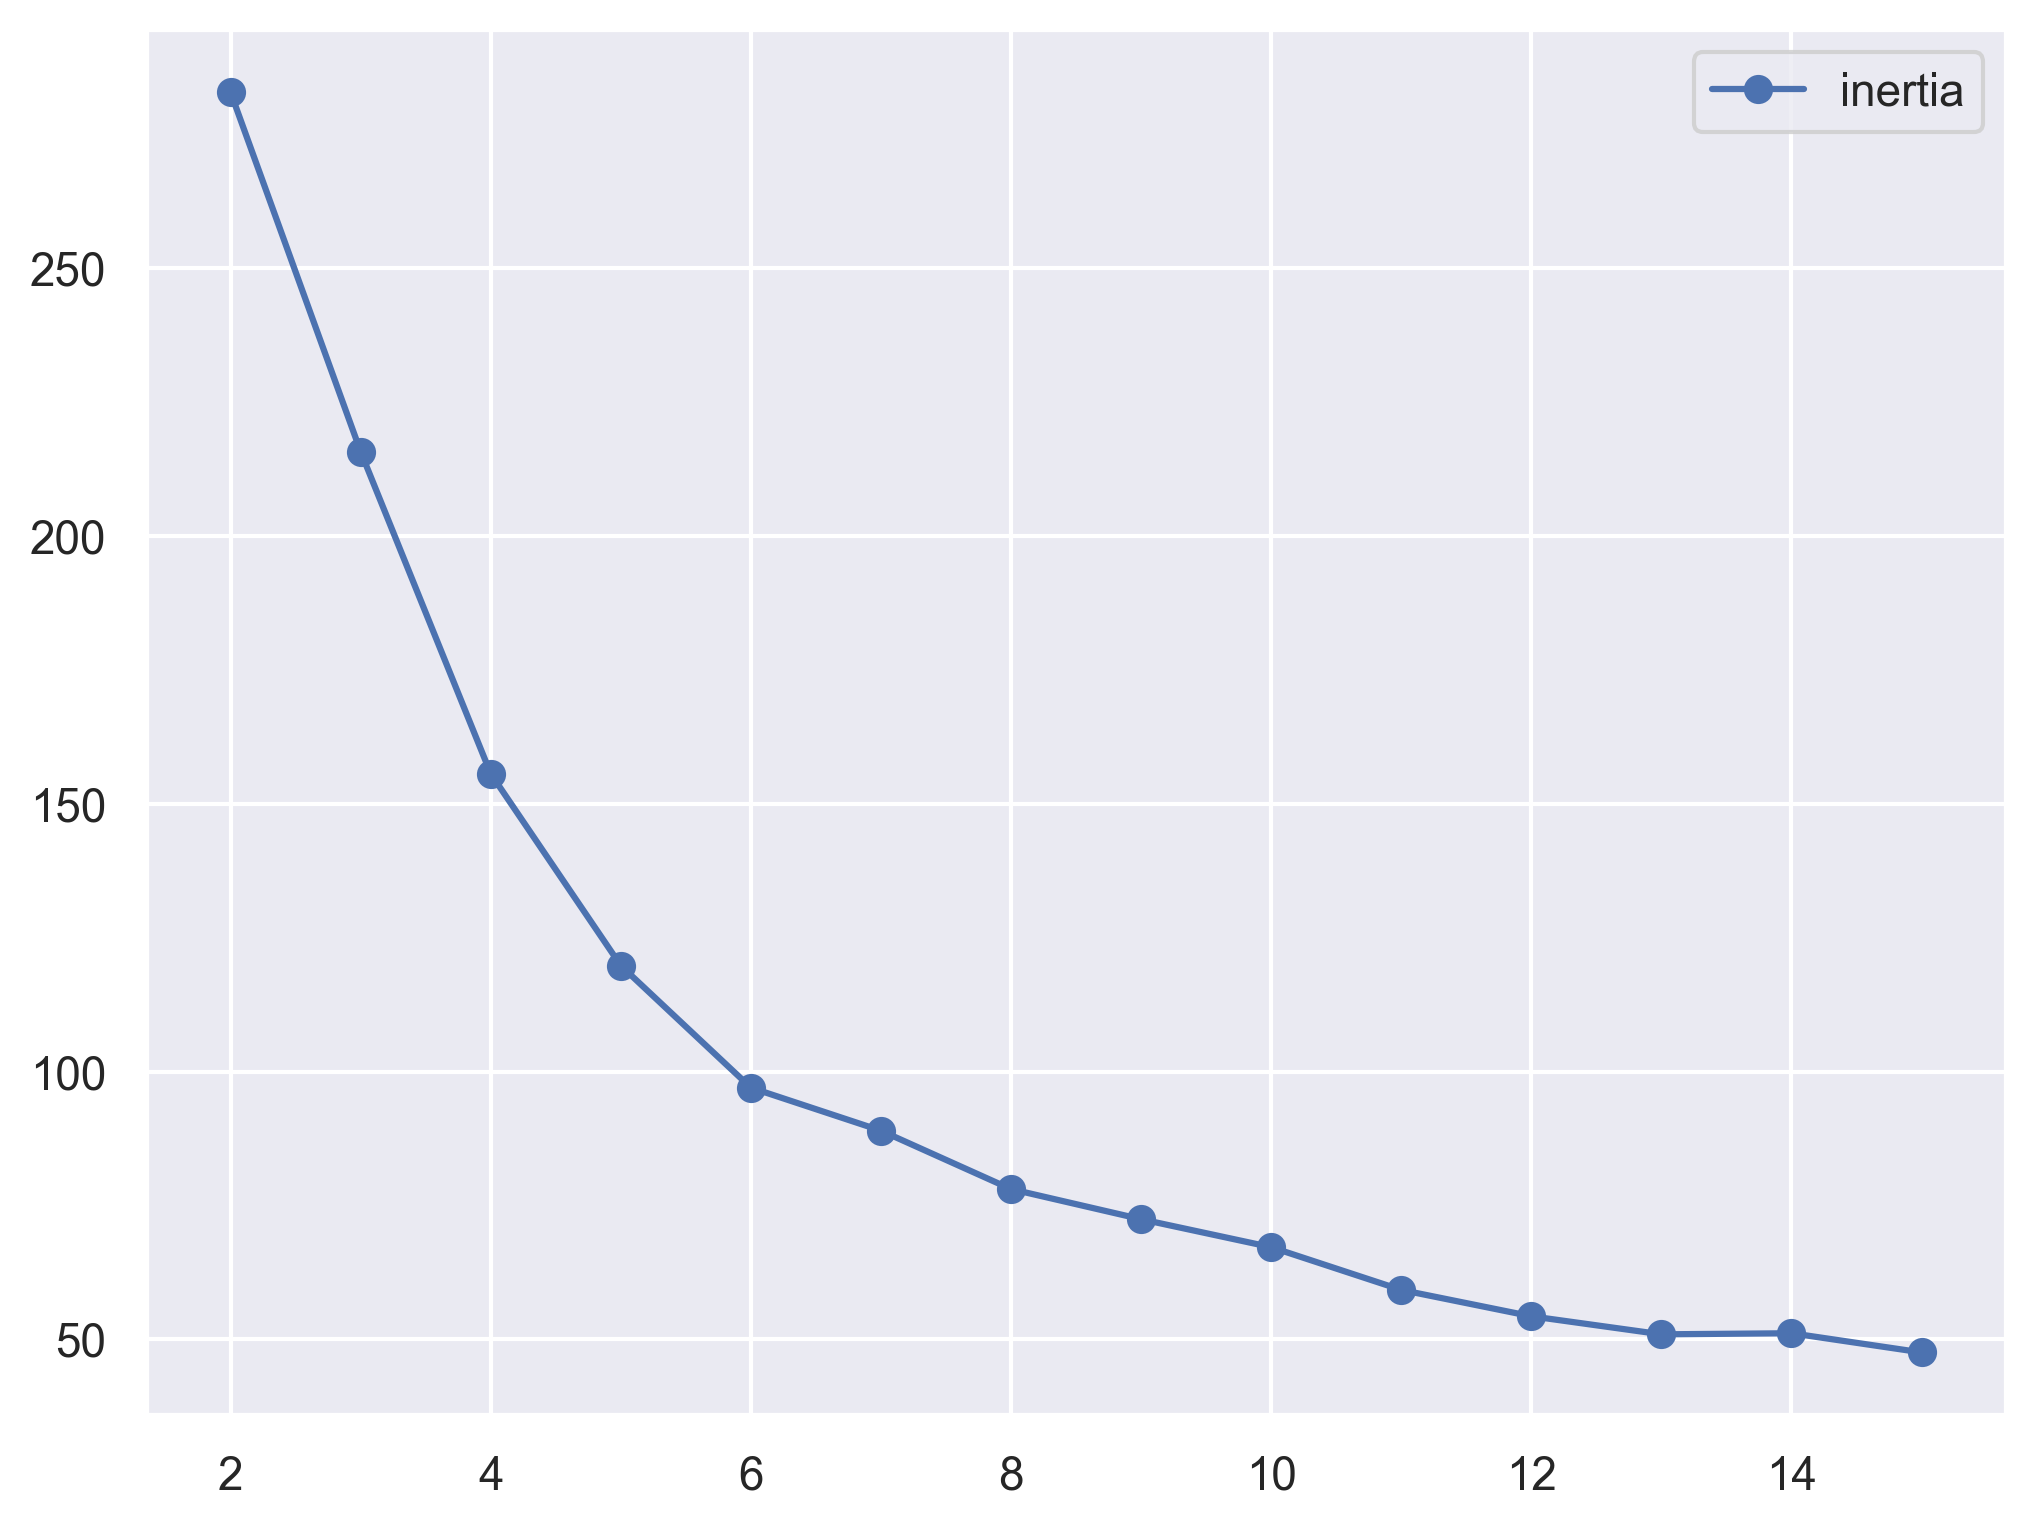

In [50]:
## 3.3 MiniBatchKMeans
# K值选择
# 肘部法则
em=[]
ks=range (2, 16)
for k in ks:
    kc = MiniBatchKMeans(n_clusters=k, random_state=1, batch_size = 300)
    kc.fit(RFM_BC_normalized)
    em.append(kc.inertia_)

plt.figure(figsize=(8, 6), dpi=300)
plt. plot (ks, em, marker='o', label='inertia')
plt.legend(loc='upper right')
plt.savefig(fname='MiniBatchKMeans肘部法则.png')

##### 轮廓系数

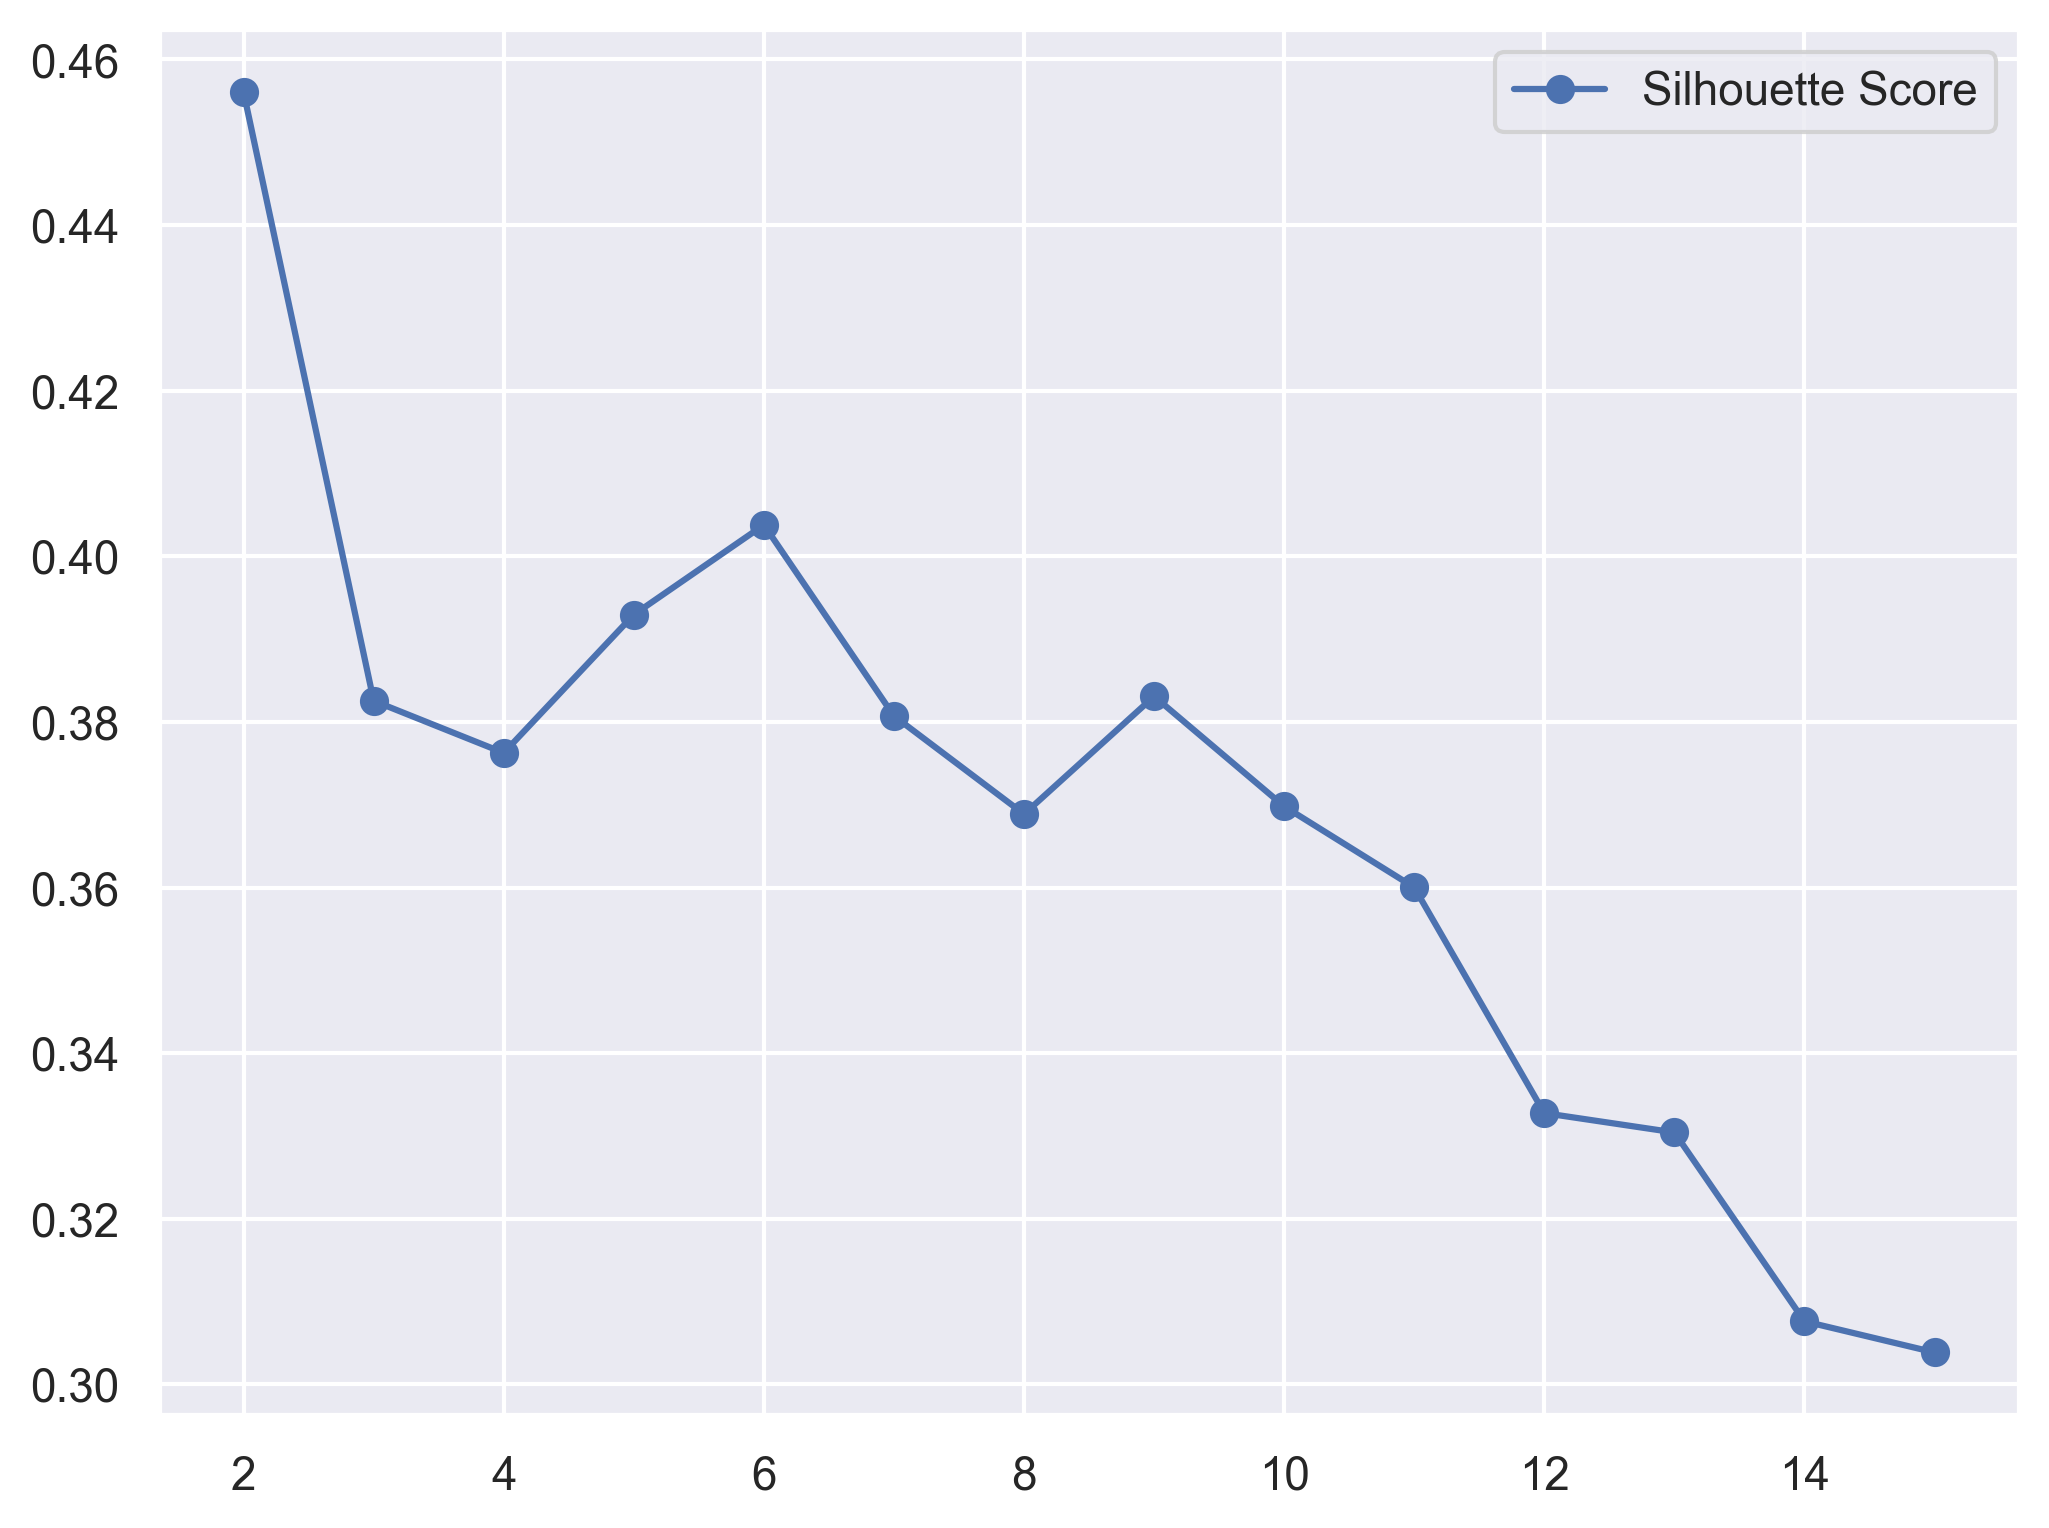

In [51]:
# 轮廓系数
silhouette_scores = []
ks=range (2, 16)
for k in ks:
    kc = MiniBatchKMeans(n_clusters=k, random_state=1, batch_size = 300)
    kc.fit(RFM_BC_normalized)
    score = silhouette_score(RFM_BC_normalized, kc.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(ks, silhouette_scores, marker='o', label='Silhouette Score')
plt.legend(loc='upper right')
plt.savefig(fname='MiniBatchKMeans轮廓系数.png')

#### 3.3.2 确定K值并聚类
综合肘部法则和轮廓系数确定K值为6，也可以更具业务需要聚成8类

In [52]:
# 聚类
model_kmeans =  MiniBatchKMeans(n_clusters=6, random_state=1)  ## 肘部法则和轮廓系数确定k为6，实际业务可以确定为8
model_kmeans.fit(RFM_BC_normalized)
cluster_labels = model_kmeans.labels_
RDM_kmeans = RFM.assign(cluster=cluster_labels)
print(RDM_kmeans.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R      F        M                  
           mean   mean     mean         sum count
cluster                                          
0         22.52   2.59   832.30   601749.61   723
1         10.37  12.34  6982.47  5711657.70   818
2        246.33   1.00   424.87   349669.62   823
3         63.50   5.26  2068.08  1406291.15   680
4         47.84   1.00   393.25   263478.29   670
5        161.81   2.39   888.40   554362.52   624


#### 3.3.3 聚类结果可视化

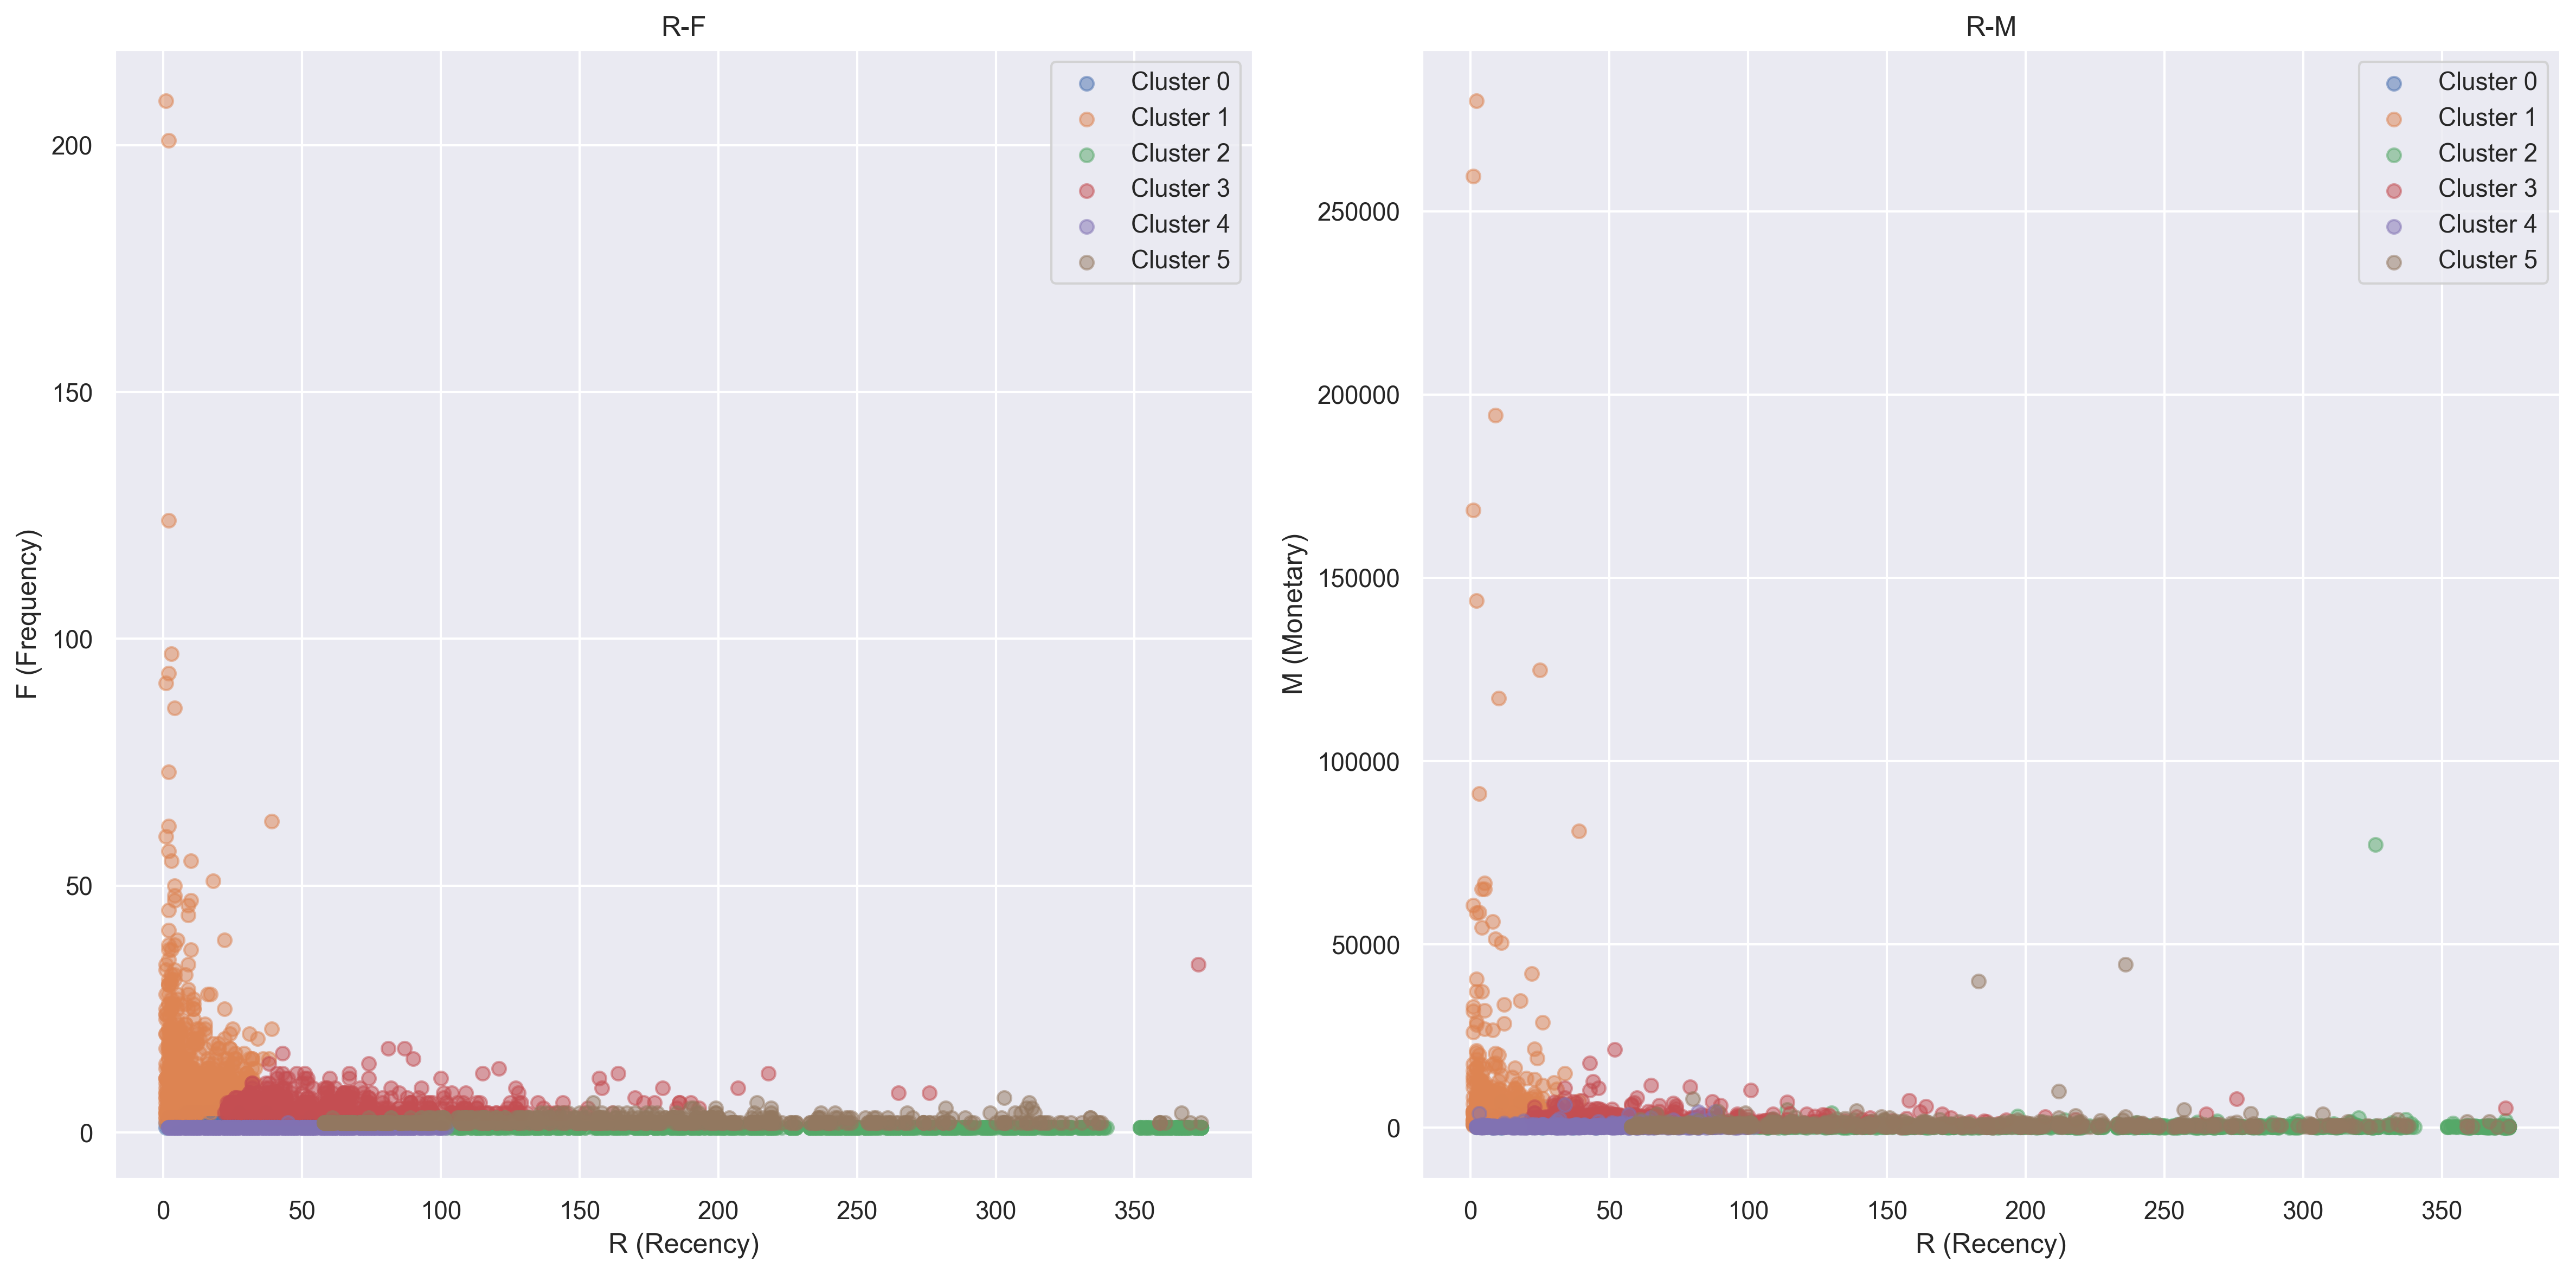

In [53]:
# 聚类结果可视化
R = RDM_kmeans['R']
F = RDM_kmeans['F']
M = RDM_kmeans['M']
clusters = RDM_kmeans['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()
# 绘制 R-F 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[0].scatter(R[mask], F[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[1].scatter(R[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='MiniBatchKMeans聚类结果.png')

### 3.4 Affinity Propagation
#### 3.4.1 确定阻尼系数与偏好度
这个调参有点难，动不动就几千组

In [54]:
## 3.4 Affinity Propagation
# 聚类
model =  AffinityPropagation(damping=0.81, preference=-100) #damping阻尼系数，越大类数越少；preference偏好度，越大类数越多
model.fit(RFM_BC_normalized)
cluster_labels = model.labels_
AP = RFM.assign(cluster=cluster_labels)
print(AP.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R     F        M                  
           mean  mean     mean         sum count
cluster                                         
0        112.63  3.07  1122.43  1426613.82  1271
1        157.88  1.00   408.68   607704.65  1487
2         16.31  8.32  4337.27  6852890.42  1580


#### 3.4.2 聚类结果可视化

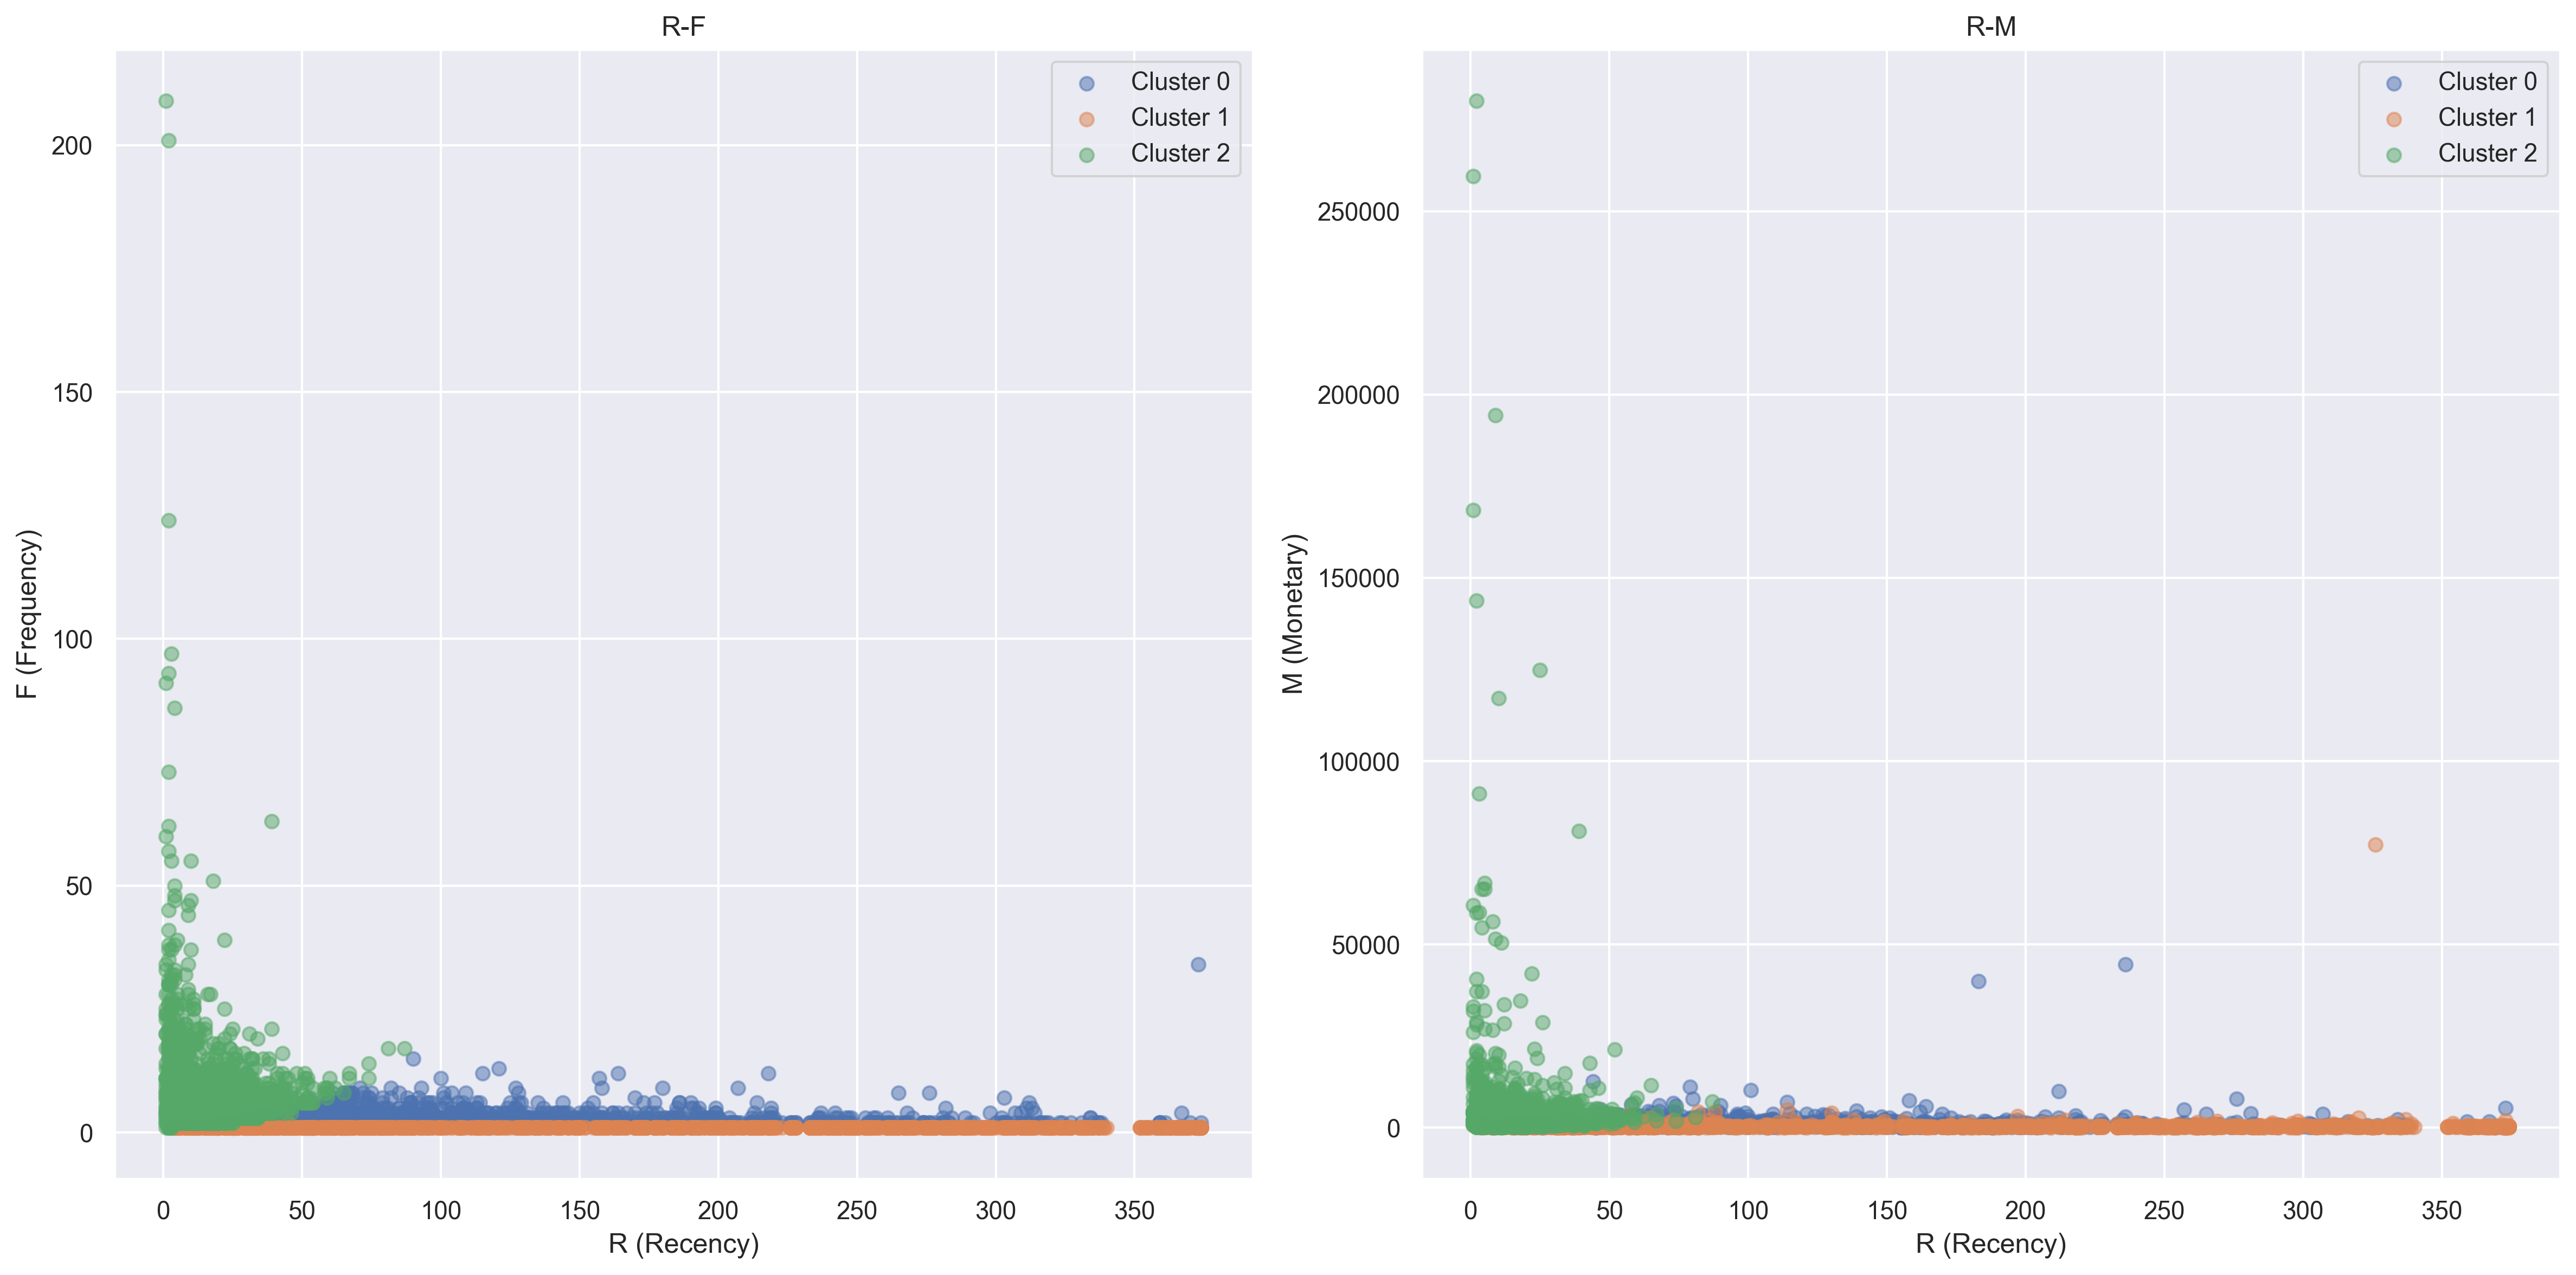

In [55]:
# 聚类结果可视化
R = AP['R']
F = AP['F']
M = AP['M']
clusters = AP['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()
# 绘制 R-F 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[0].scatter(R[mask], F[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[1].scatter(R[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='Affinity Propagation聚类结果.png')

#### 3.4.3 三维可视化

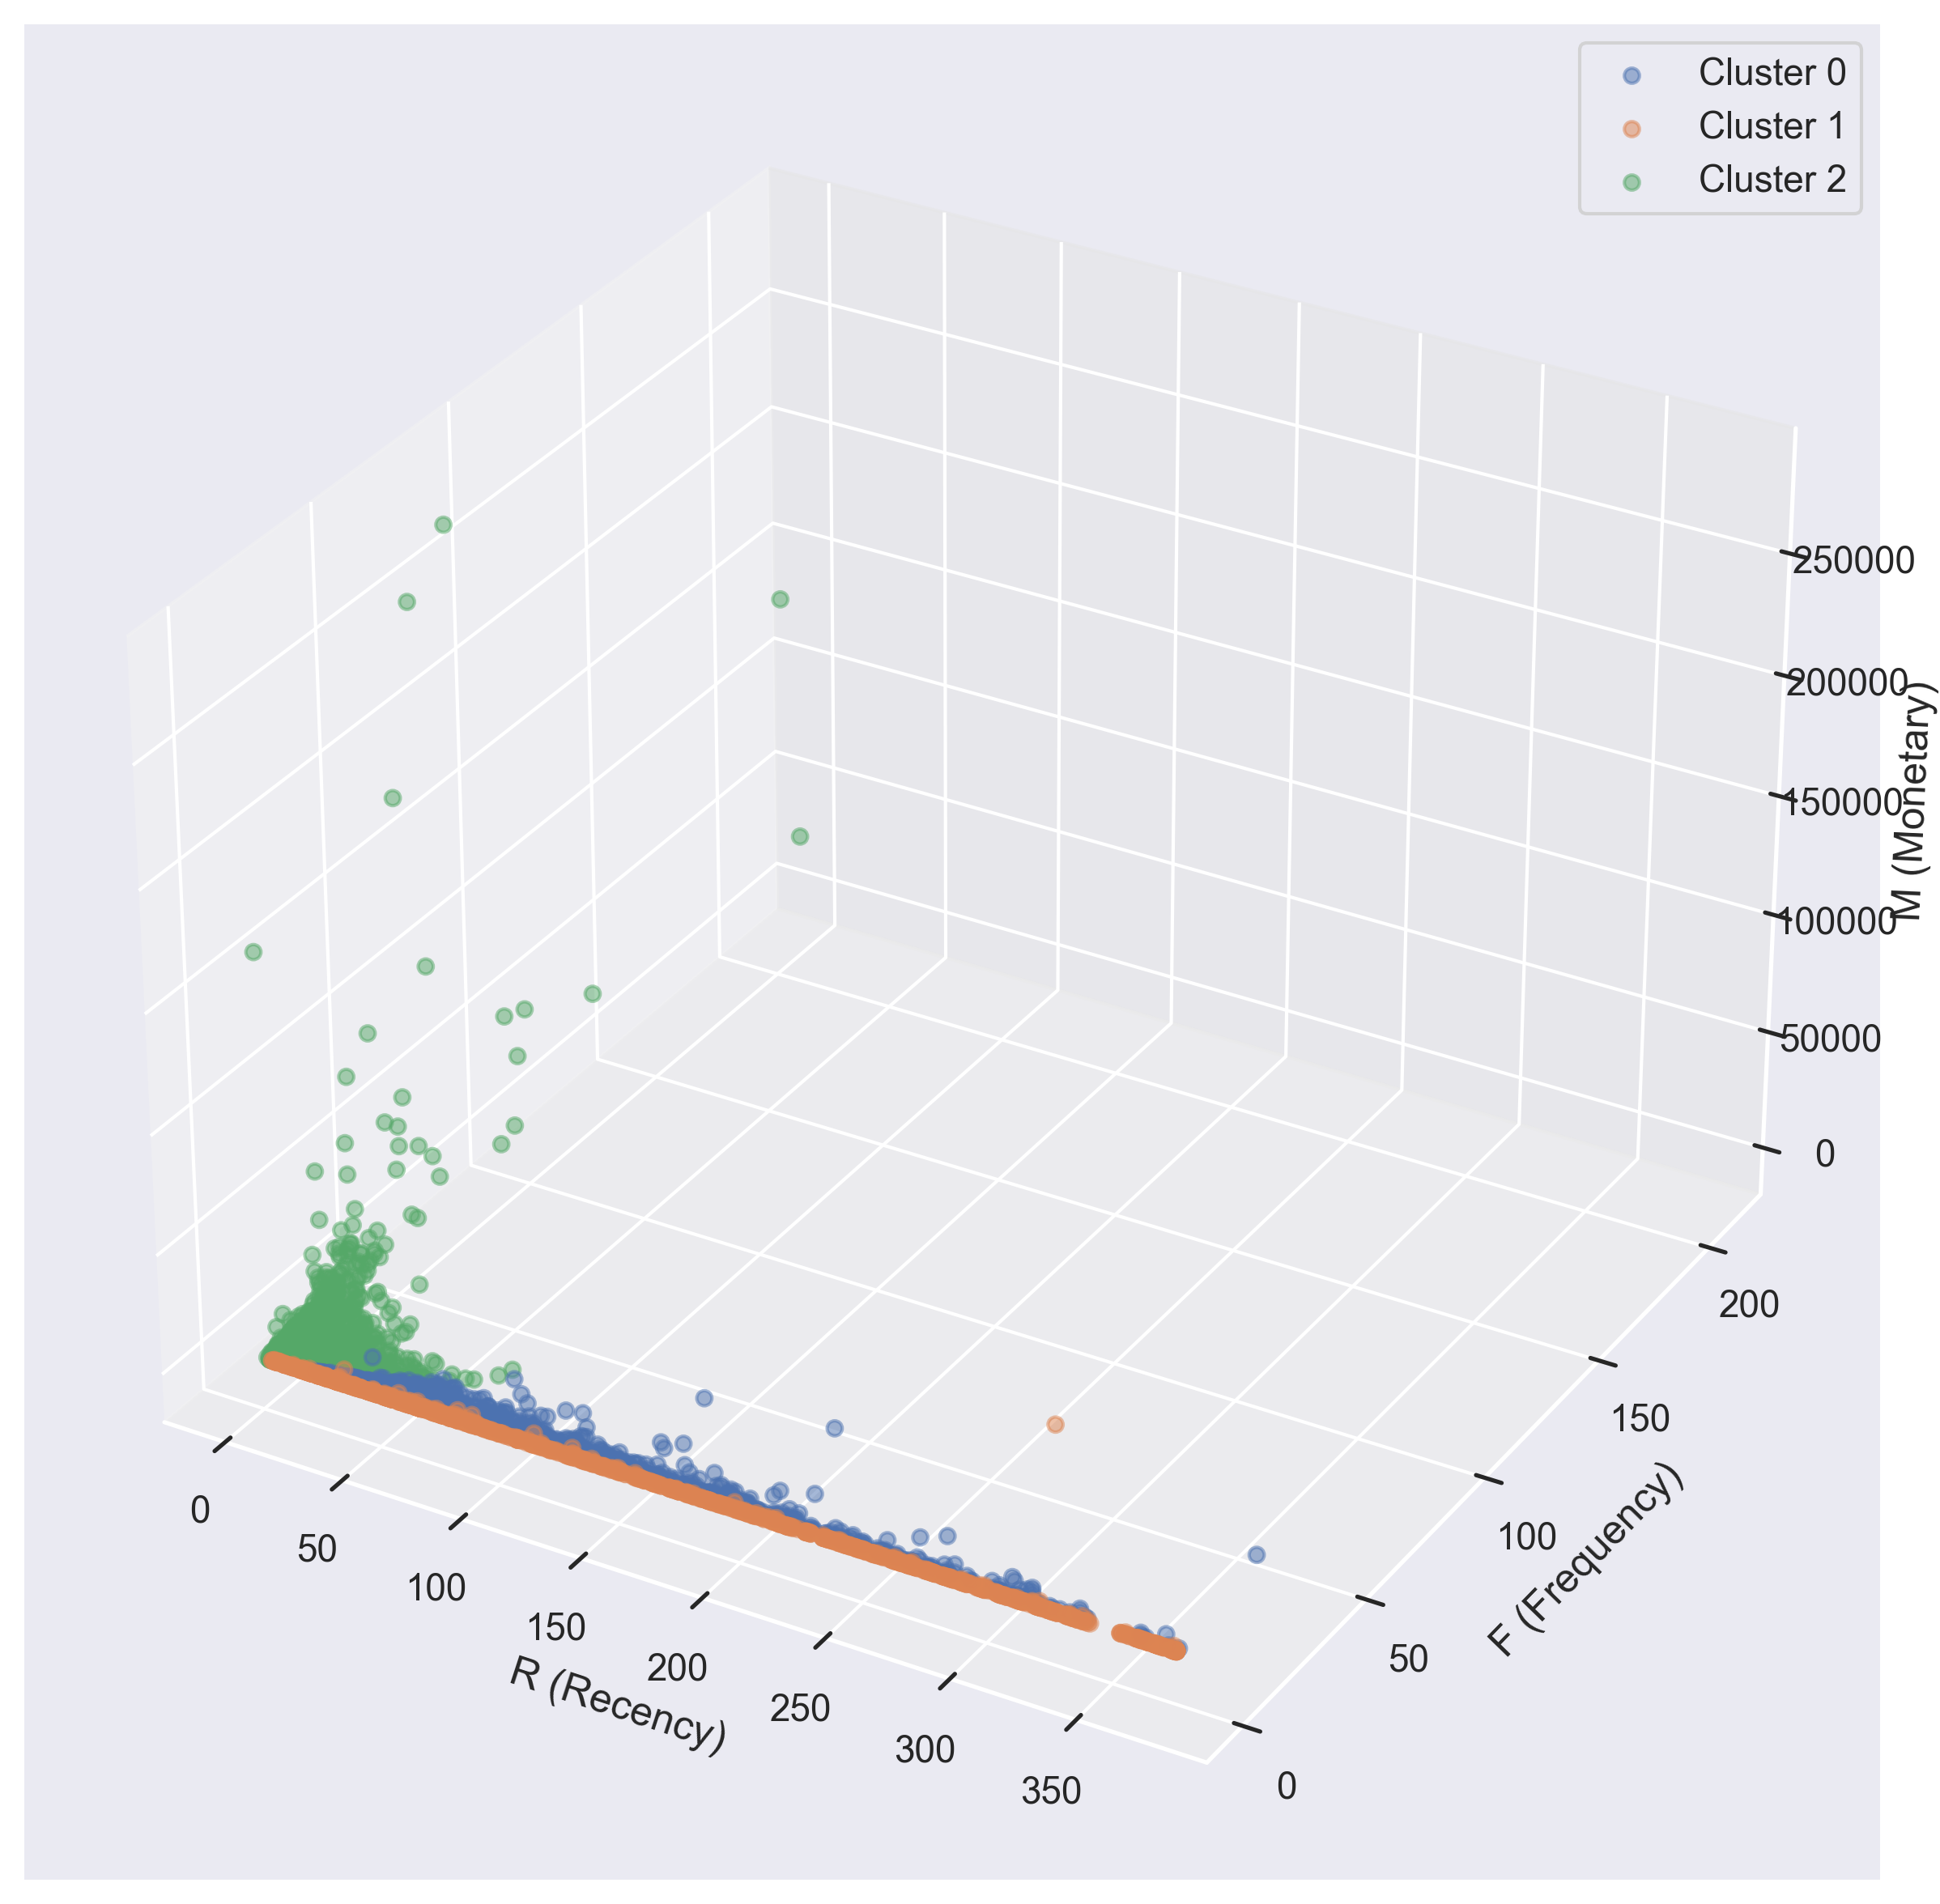

In [56]:
# 三维可视化
fig = plt.figure(figsize=(10, 8), dpi = 300)
ax = fig.add_subplot(111, projection='3d')

for cluster in set(clusters):
    mask = (clusters == cluster)
    ax.scatter(R[mask], F[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)

ax.set_xlabel('R (Recency)')
ax.set_ylabel('F (Frequency)')
ax.set_zlabel('M (Monetary)')
ax.legend()

plt.tight_layout()
plt.savefig(fname='AffinityPropagation聚类三维结果.png')

### 3.5 Spectral clustering
#### 3.5.1 K值选择
##### 轮廓系数

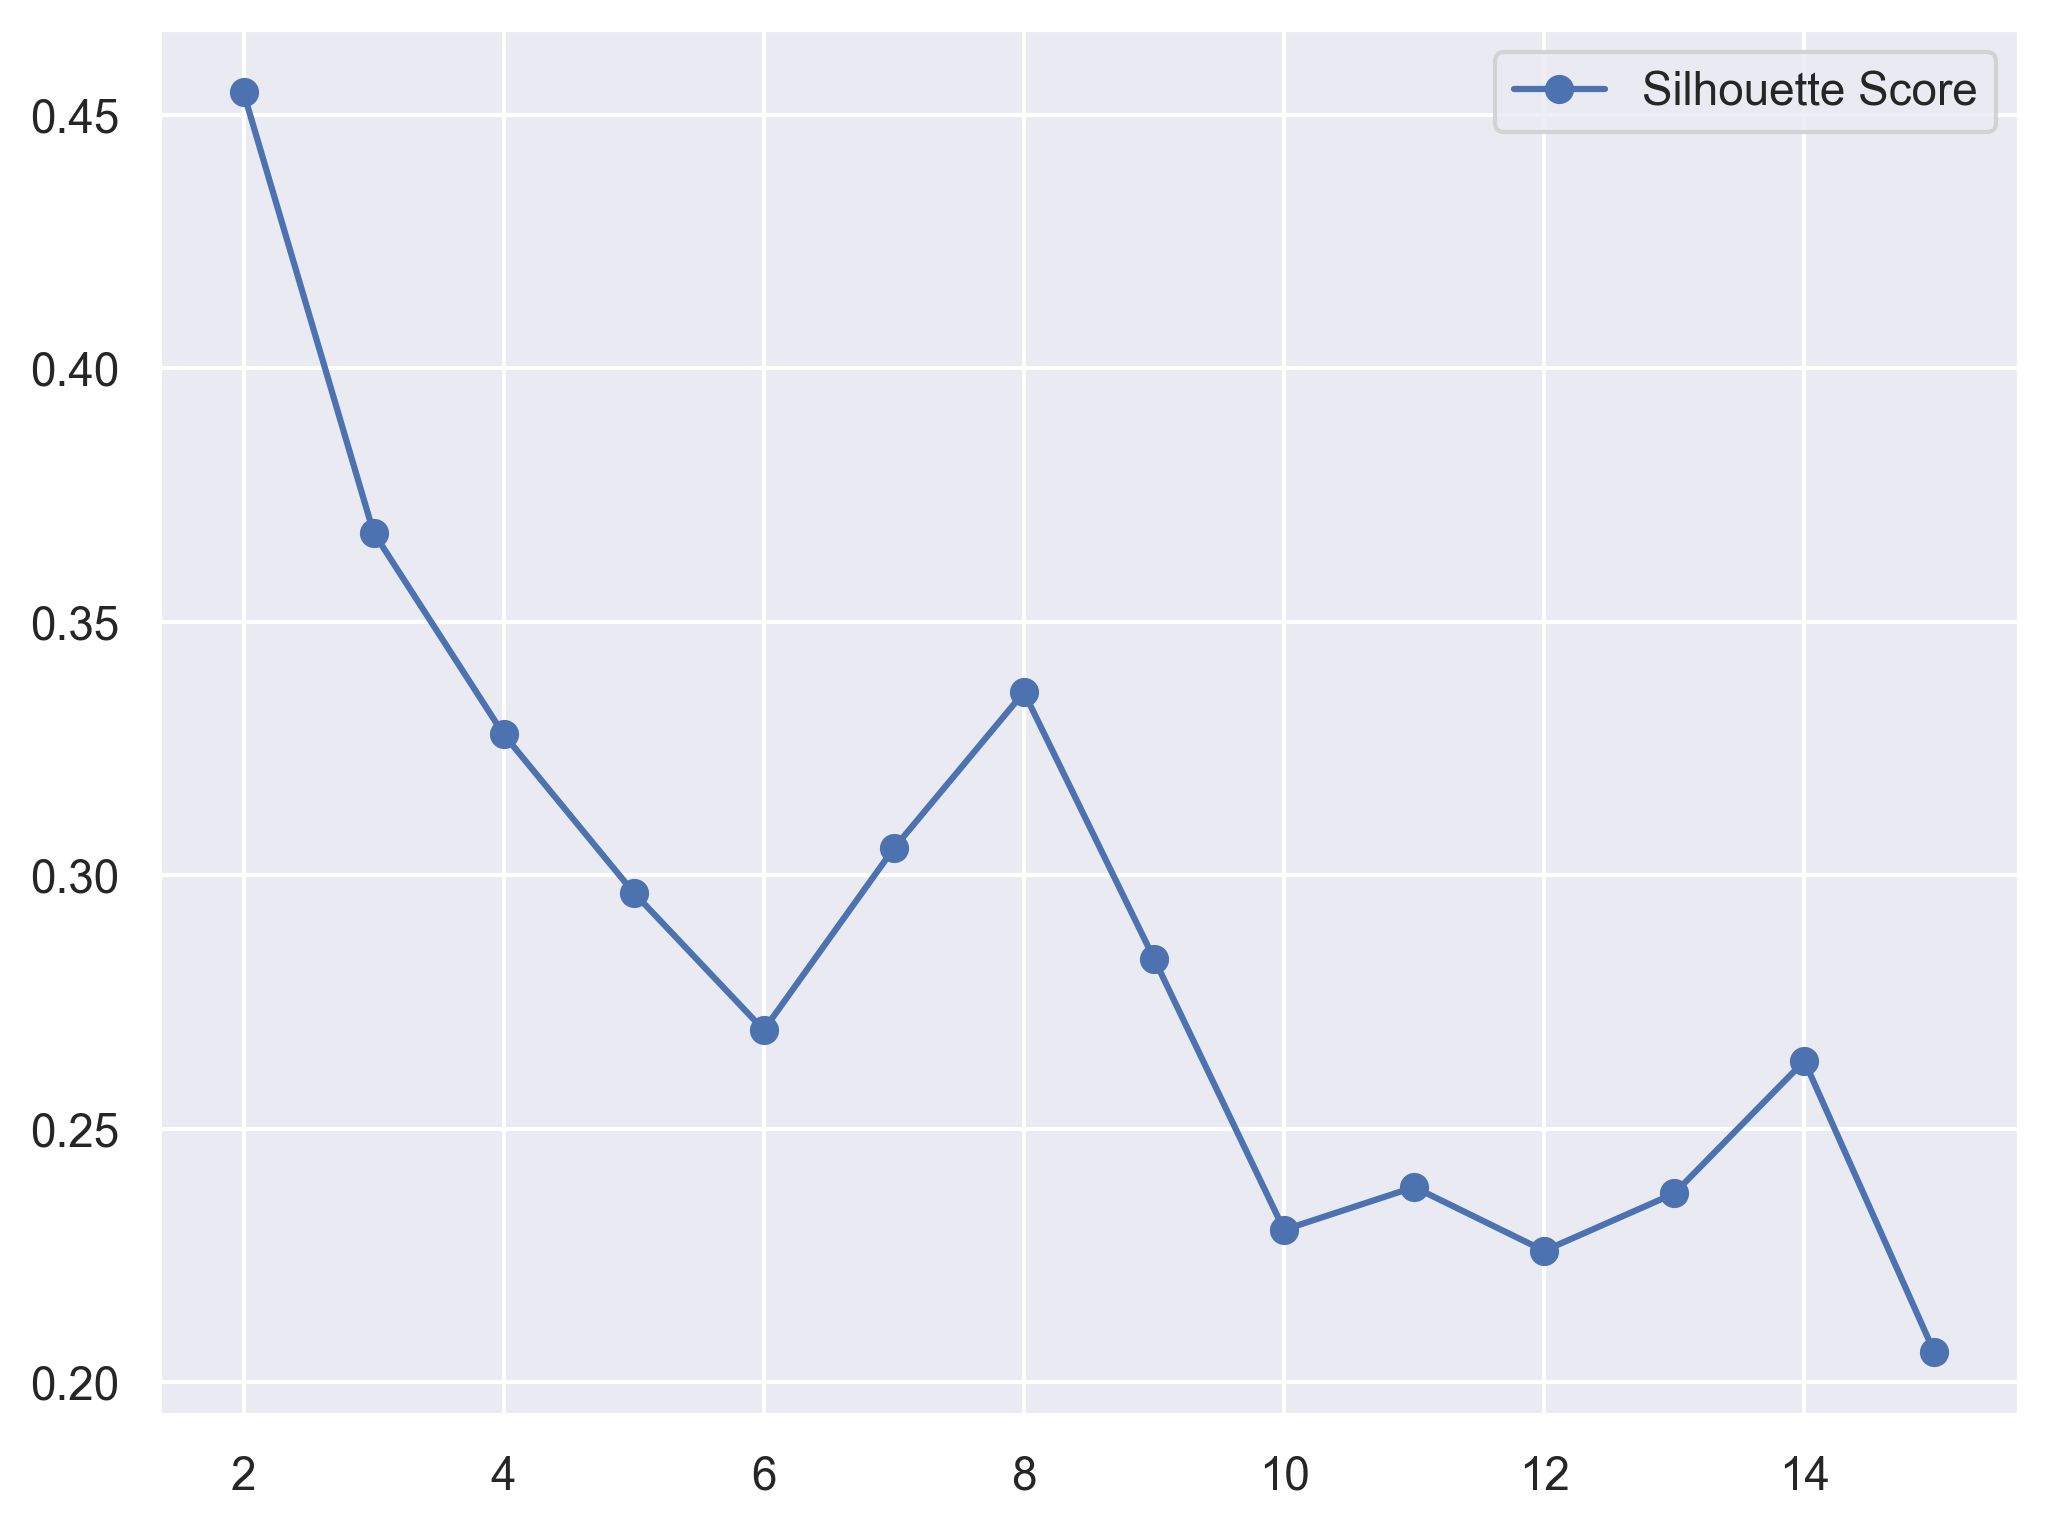

In [57]:
## 3.5 Spectral clustering
# 轮廓系数
silhouette_scores = []
ks=range (2, 16)
for k in ks:
    kc = SpectralClustering(n_clusters=k, random_state=1, affinity='rbf')
    kc.fit(RFM_BC_normalized)
    score = silhouette_score(RFM_BC_normalized, kc.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6), dpi=300)
plt.plot(ks, silhouette_scores, marker='o', label='Silhouette Score')
plt.legend(loc='upper right')
plt.savefig(fname='SpectralClustering轮廓系数.png')

#### 3.5.2 确定K值并聚类

In [58]:
# 聚类
model =  SpectralClustering(n_clusters=8, random_state=1, affinity='rbf')
model.fit(RFM_BC_normalized)
cluster_labels = model.labels_
RDM_kmeans = RFM.assign(cluster=cluster_labels)
print(RDM_kmeans.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R      F         M                  
           mean   mean      mean         sum count
cluster                                           
0        187.27   2.92   1063.77   539329.12   507
1         76.74   1.00    445.85   295597.54   663
2         43.96   3.03   1031.13  1162084.77  1127
3          3.44  28.38  19898.32  3004646.66   151
4        273.25   1.00    414.84   275040.24   663
5         18.24   1.20    290.14    48742.99   168
6          5.63   4.52   1916.16   827781.51   432
7         33.71   9.36   4360.42  2733986.06   627


#### 3.5.3 聚类结果可视化

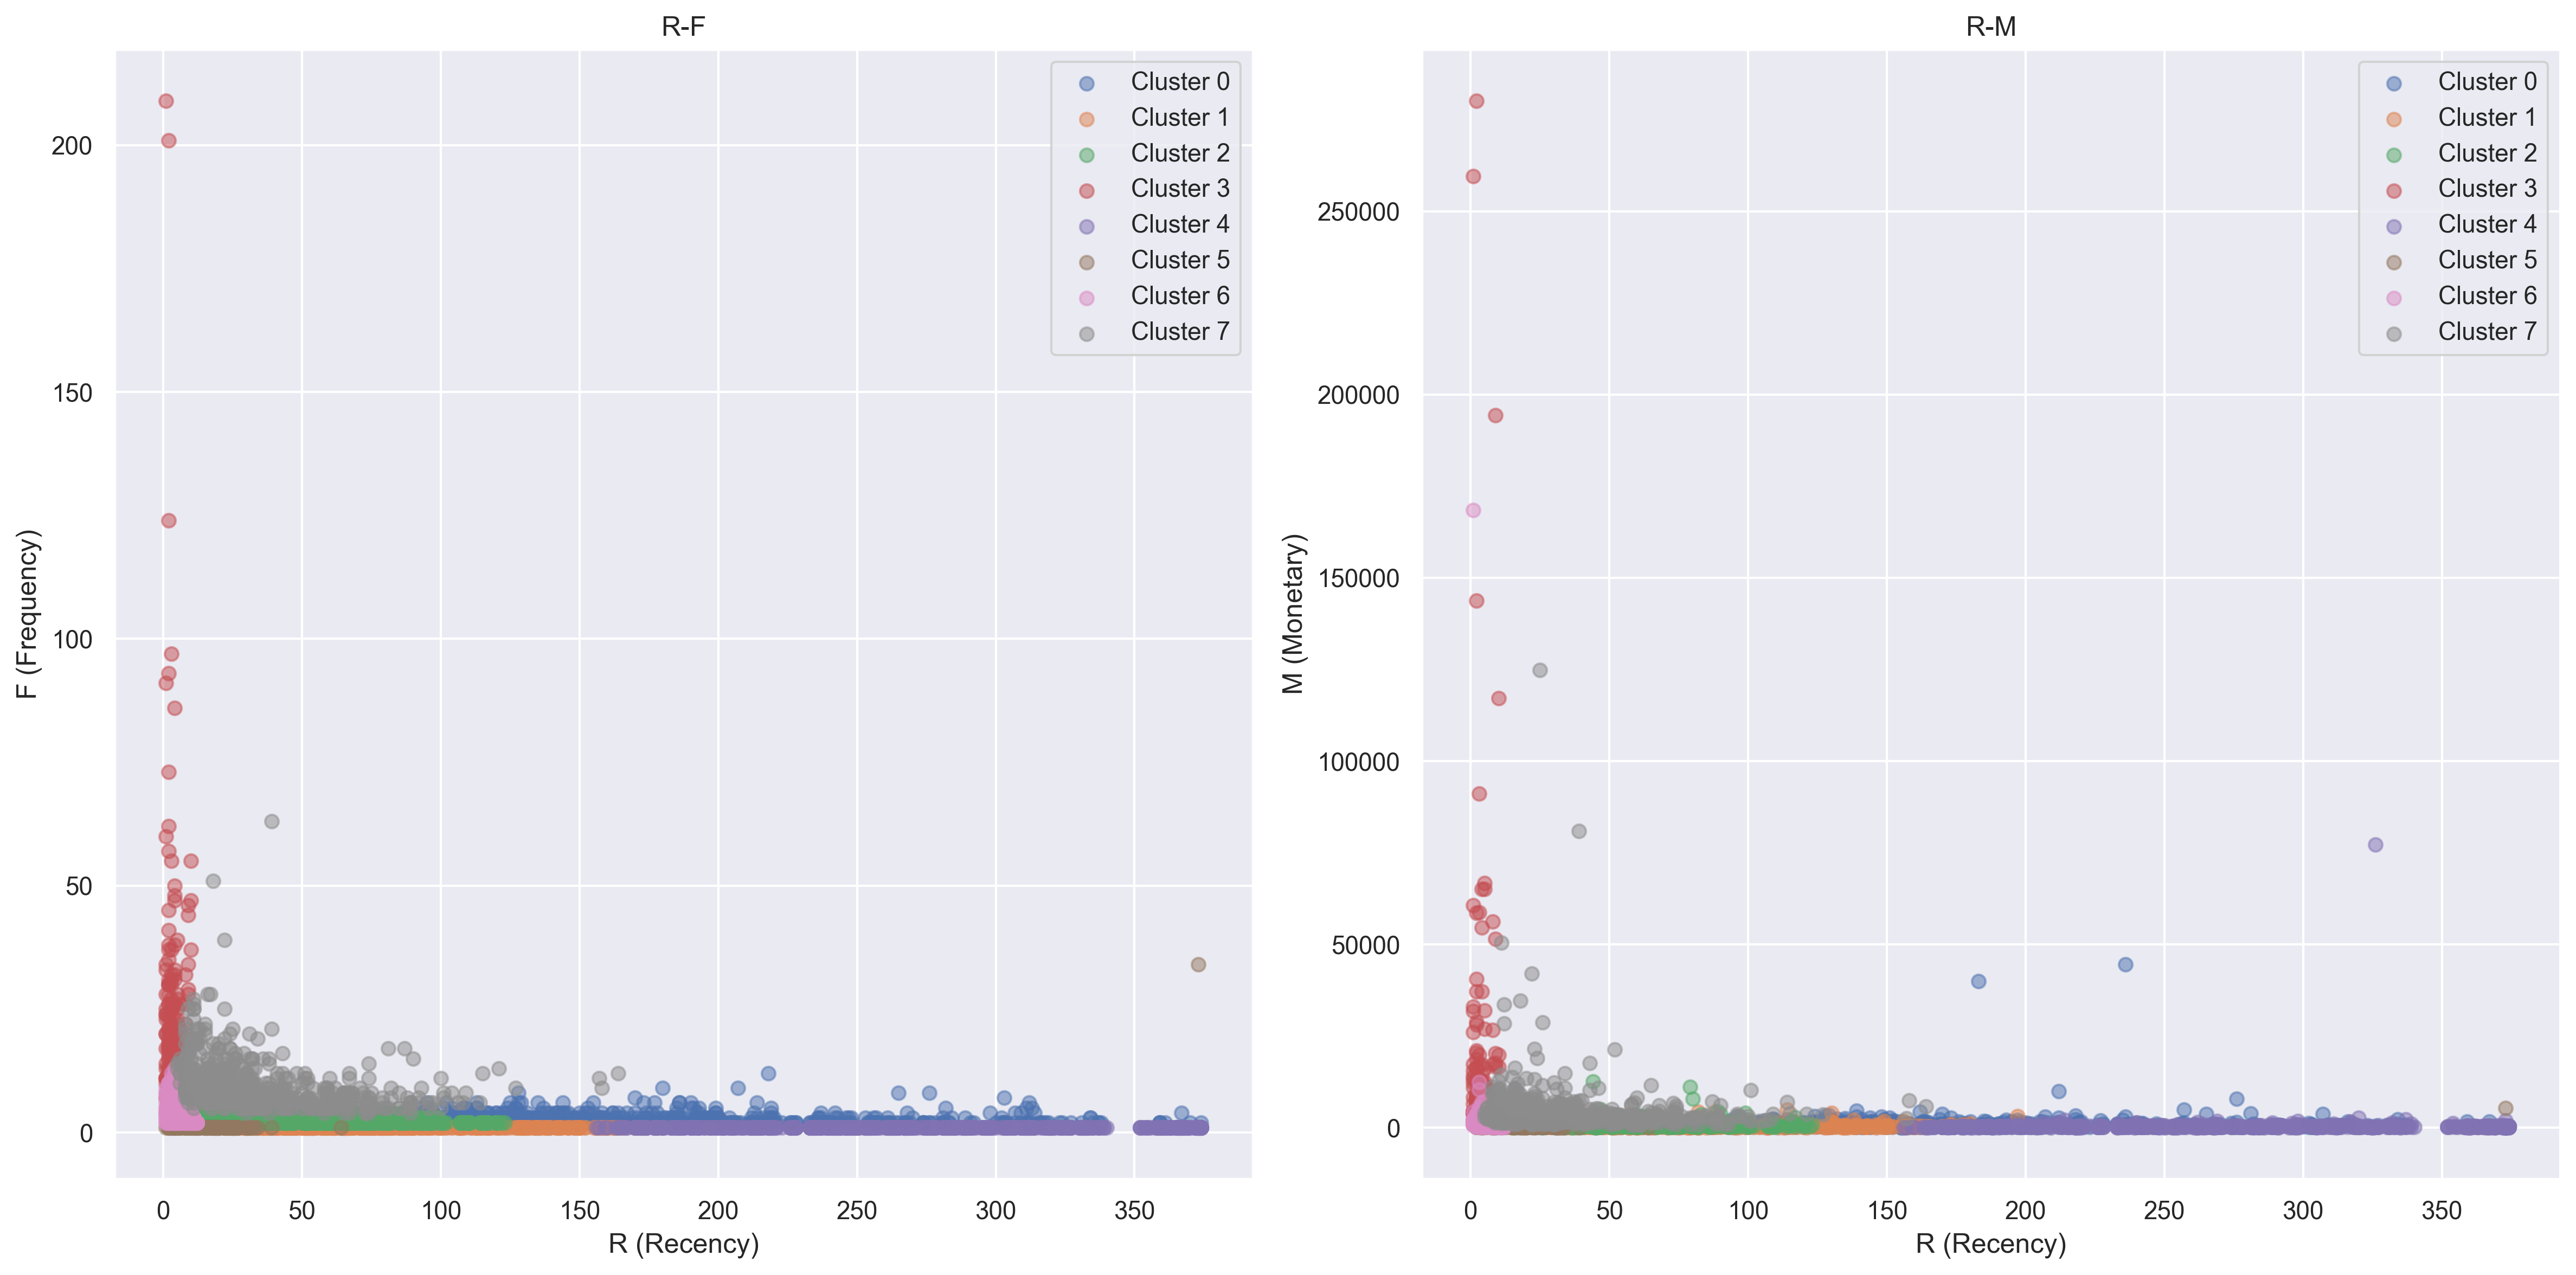

In [59]:
# 聚类结果可视化
R = RDM_kmeans['R']
F = RDM_kmeans['F']
M = RDM_kmeans['M']
clusters = RDM_kmeans['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()
# 绘制 R-F 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[0].scatter(R[mask], F[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters):
    mask = (clusters == cluster)
    axes[1].scatter(R[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='Spectral Clustering聚类结果.png')

#### 3.5.4 三维可视化

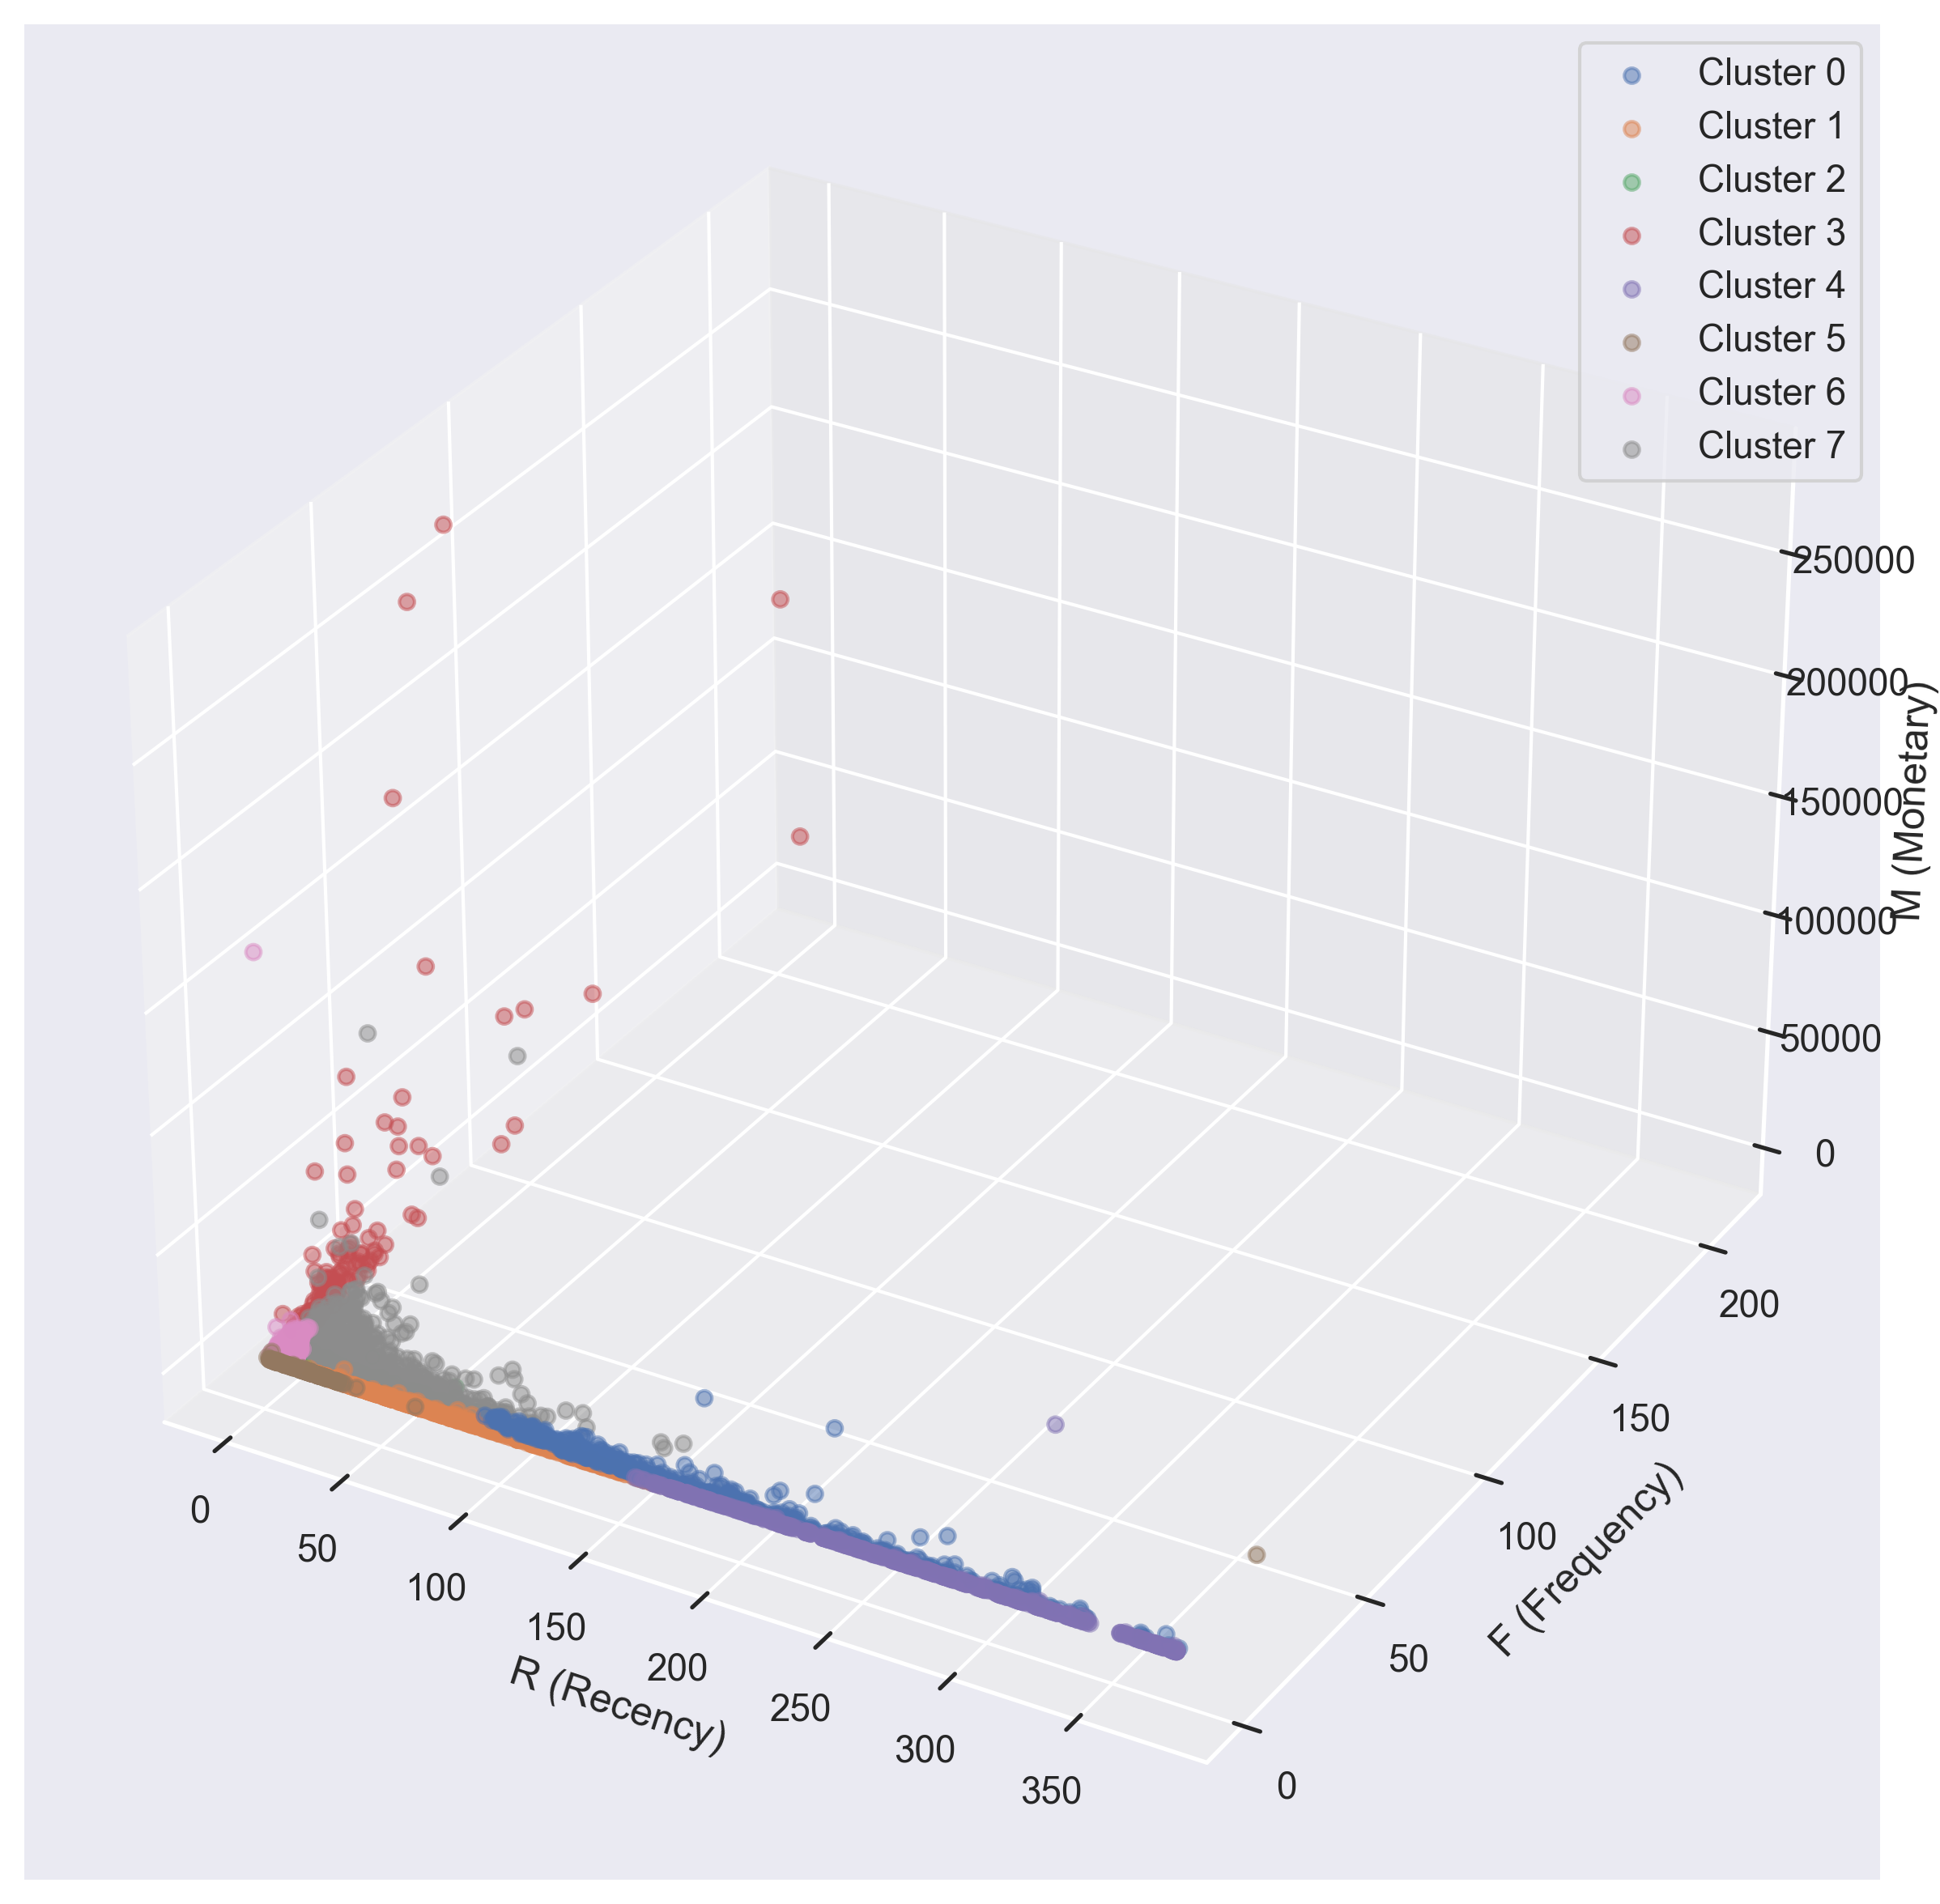

In [60]:
# 三维可视化
fig = plt.figure(figsize=(10, 8), dpi = 300)
ax = fig.add_subplot(111, projection='3d')

for cluster in set(clusters):
    mask = (clusters == cluster)
    ax.scatter(R[mask], F[mask], M[mask], label=f'Cluster {cluster}', alpha=0.5)

ax.set_xlabel('R (Recency)')
ax.set_ylabel('F (Frequency)')
ax.set_zlabel('M (Monetary)')
ax.legend()

plt.tight_layout()
plt.savefig(fname='Spectral Clustering聚类三维结果.png')

### 3.6 DBSCAN
#### 3.6.1 确定最佳eps_values和min_samples_values
仅展示部分  不然太长了

In [61]:
## 3.6 DBSCAN
eps_values = [0.11,0.12,0.13]
min_samples_values = [2,3,4,5]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_model.fit(RFM_BC_normalized)
        cluster_labels = dbscan_model.labels_
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        print(f"eps={eps}, min_samples={min_samples} 时的聚类情况：")
        print(f"聚类数量: {n_clusters}")

        RDM_dbscan = RFM.assign(cluster=cluster_labels)

        if n_clusters > 0:
            print(RDM_dbscan.groupby('cluster').agg({'R': ['mean'], 'F': ['mean'], 'M': ['mean','sum', 'count']}).round(2))
        else:
            print("所有数据被标记为噪声点，无有效聚类。")

eps=0.11, min_samples=2 时的聚类情况：
聚类数量: 4
              R      F         M                  
           mean   mean      mean         sum count
cluster                                           
-1       120.82  13.91  31776.01   349536.16    11
 0        44.45   7.60   3670.15  7351302.57  2003
 1       157.18   1.00    357.91   532935.01  1489
 2        94.67   2.00    683.05   568984.35   833
 3       209.50   3.00  42225.40    84450.80     2
eps=0.11, min_samples=3 时的聚类情况：
聚类数量: 3
              R      F         M                  
           mean   mean      mean         sum count
cluster                                           
-1       134.46  12.23  33383.61   433986.96    13
 0        44.45   7.60   3670.15  7351302.57  2003
 1       157.18   1.00    357.91   532935.01  1489
 2        94.67   2.00    683.05   568984.35   833
eps=0.11, min_samples=4 时的聚类情况：
聚类数量: 3
              R      F         M                  
           mean   mean      mean         sum count
cluster      

#### 3.6.2 确定参数并聚类
eps=0.12, min_samples=2

In [62]:
# 聚类
final_dbscan_model = DBSCAN(eps=0.12, min_samples=2)
final_dbscan_model.fit(RFM_BC_normalized)
final_cluster_labels = final_dbscan_model.labels_
RDM_final_dbscan = RFM.assign(cluster=final_cluster_labels)
print(RDM_final_dbscan.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R      F         M                  
           mean   mean      mean         sum count
cluster                                           
-1       140.22  16.56  37459.58   337136.26     9
 0        44.43   7.60   3674.50  7363696.27  2004
 1       157.12   1.00    357.68   532941.21  1490
 2        94.67   2.00    683.05   568984.35   833
 3       209.50   3.00  42225.40    84450.80     2


### 3.6.3 聚类结果可视化

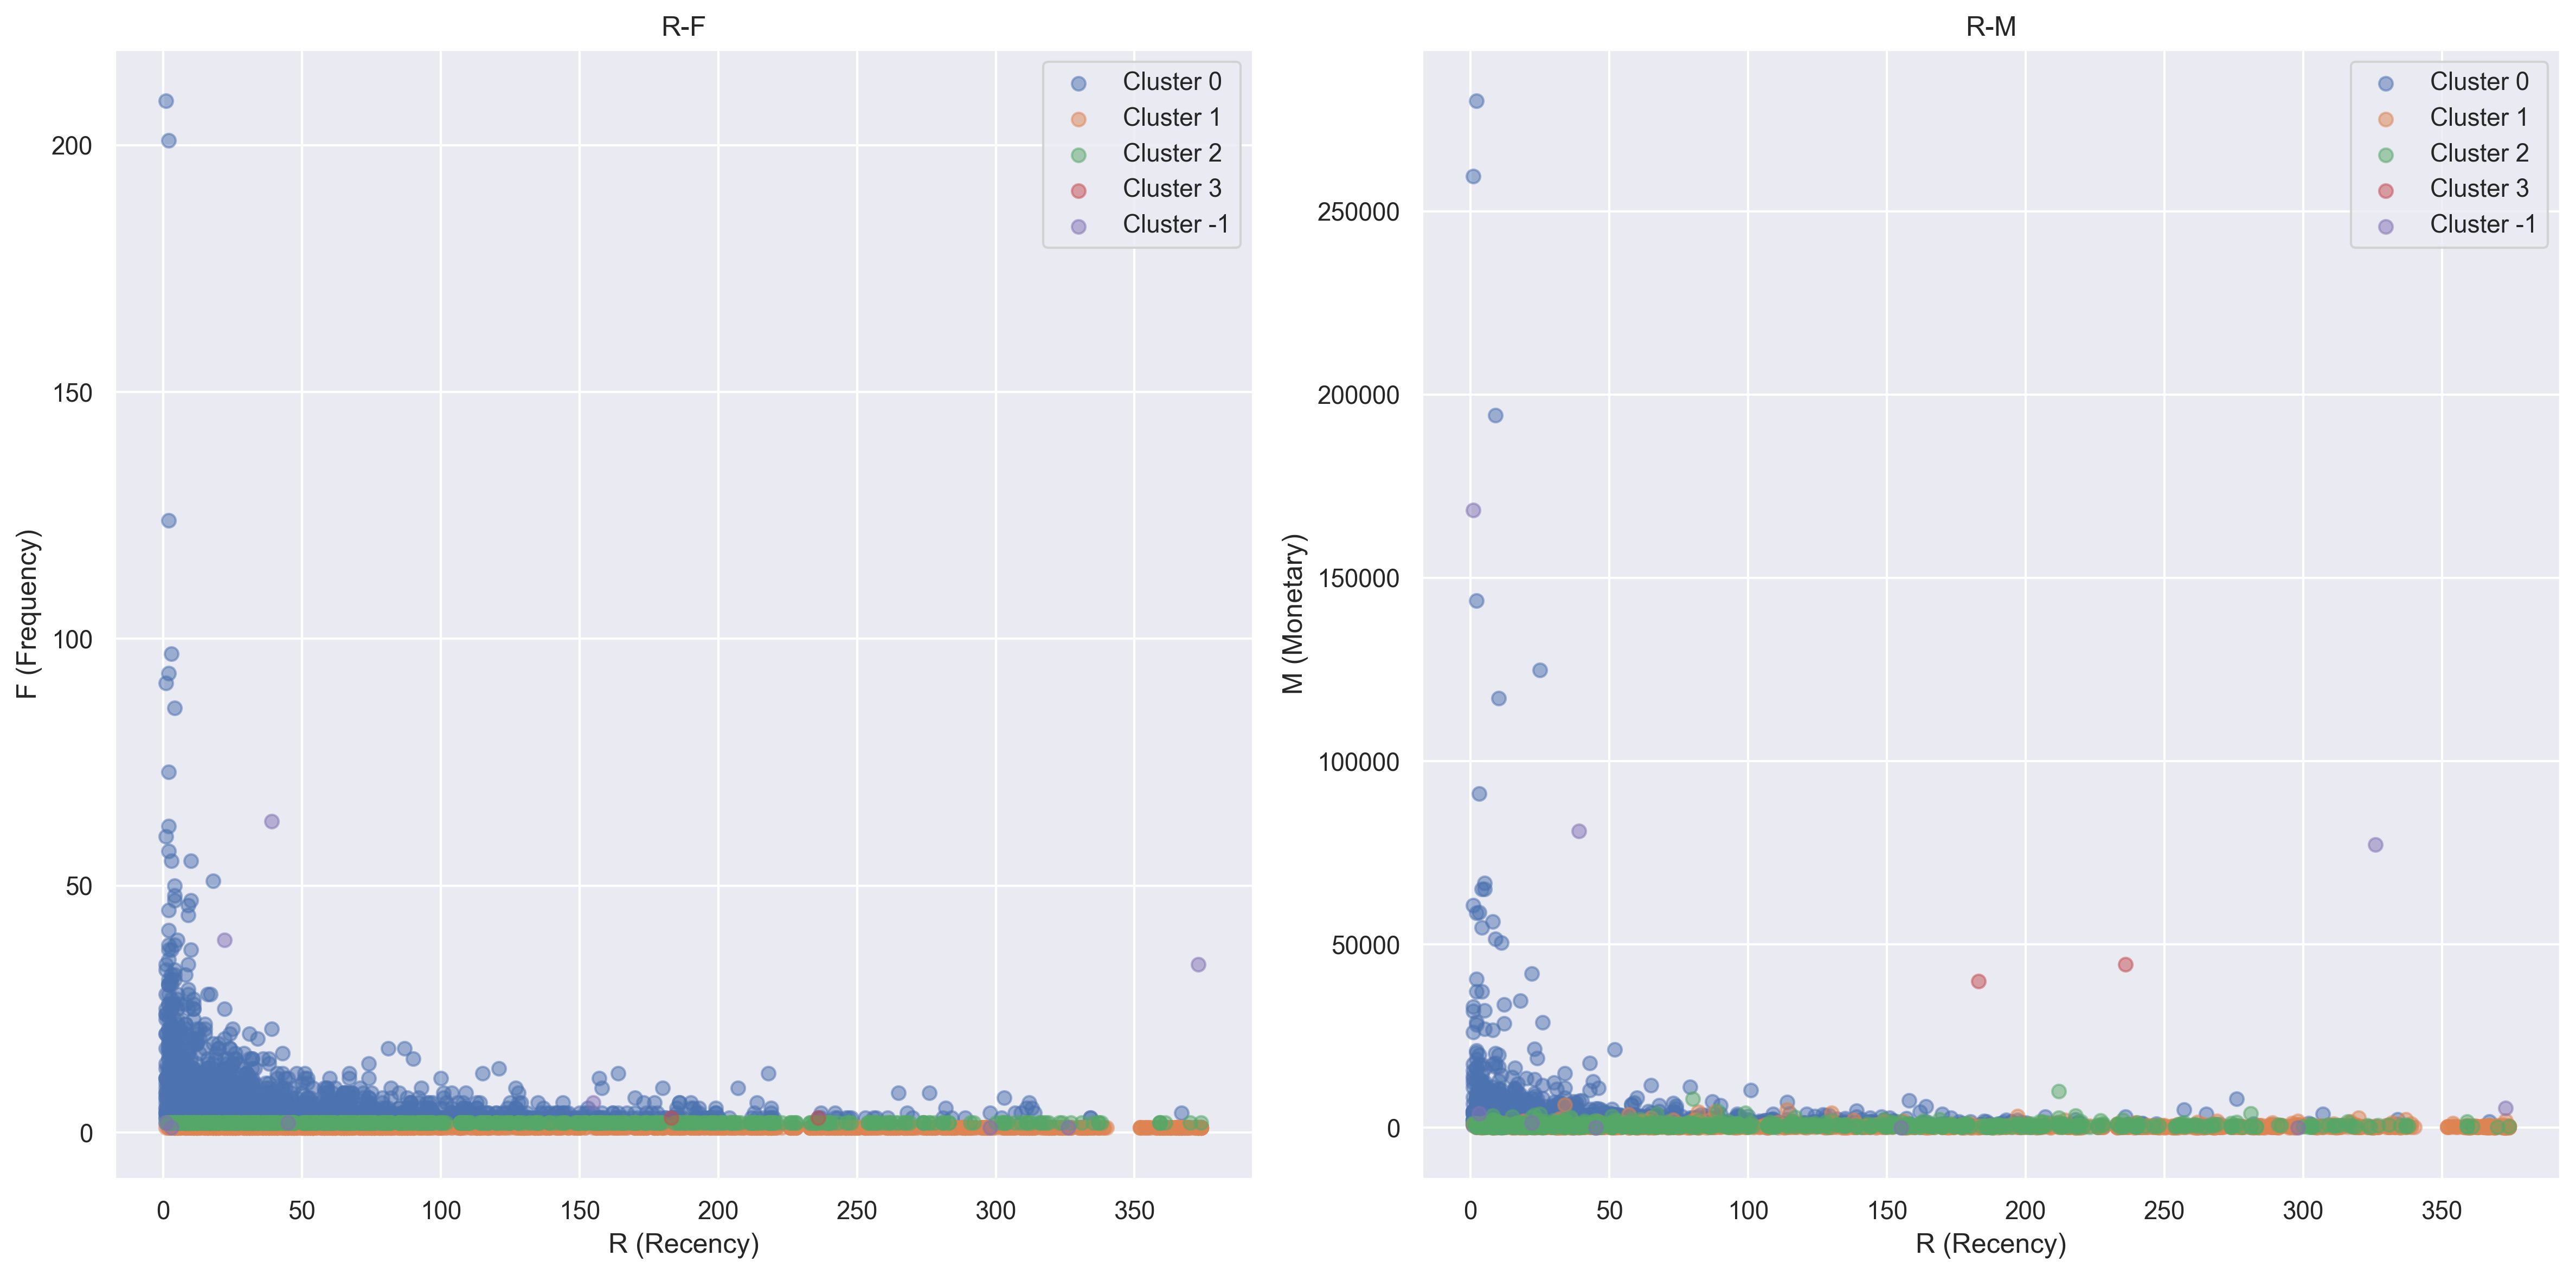

In [63]:
# 聚类结果可视化
R_dbscan = RDM_final_dbscan['R']
F_dbscan = RDM_final_dbscan['F']
M_dbscan = RDM_final_dbscan['M']
clusters_dbscan = RDM_final_dbscan['cluster']

fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
axes = axes.flatten()

# 绘制 R-F 图
for cluster in set(clusters_dbscan):
    mask = (clusters_dbscan == cluster)
    axes[0].scatter(R_dbscan[mask], F_dbscan[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[0].set_xlabel('R (Recency)')
axes[0].set_ylabel('F (Frequency)')
axes[0].set_title('R-F')
axes[0].legend()

# 绘制 R-M 图
for cluster in set(clusters_dbscan):
    mask = (clusters_dbscan == cluster)
    axes[1].scatter(R_dbscan[mask], M_dbscan[mask], label=f'Cluster {cluster}', alpha=0.5)
axes[1].set_xlabel('R (Recency)')
axes[1].set_ylabel('M (Monetary)')
axes[1].set_title('R-M')
axes[1].legend()

plt.tight_layout()
plt.savefig(fname='DBSCAN聚类结果.png')

#### 3.6.4 三维可视化

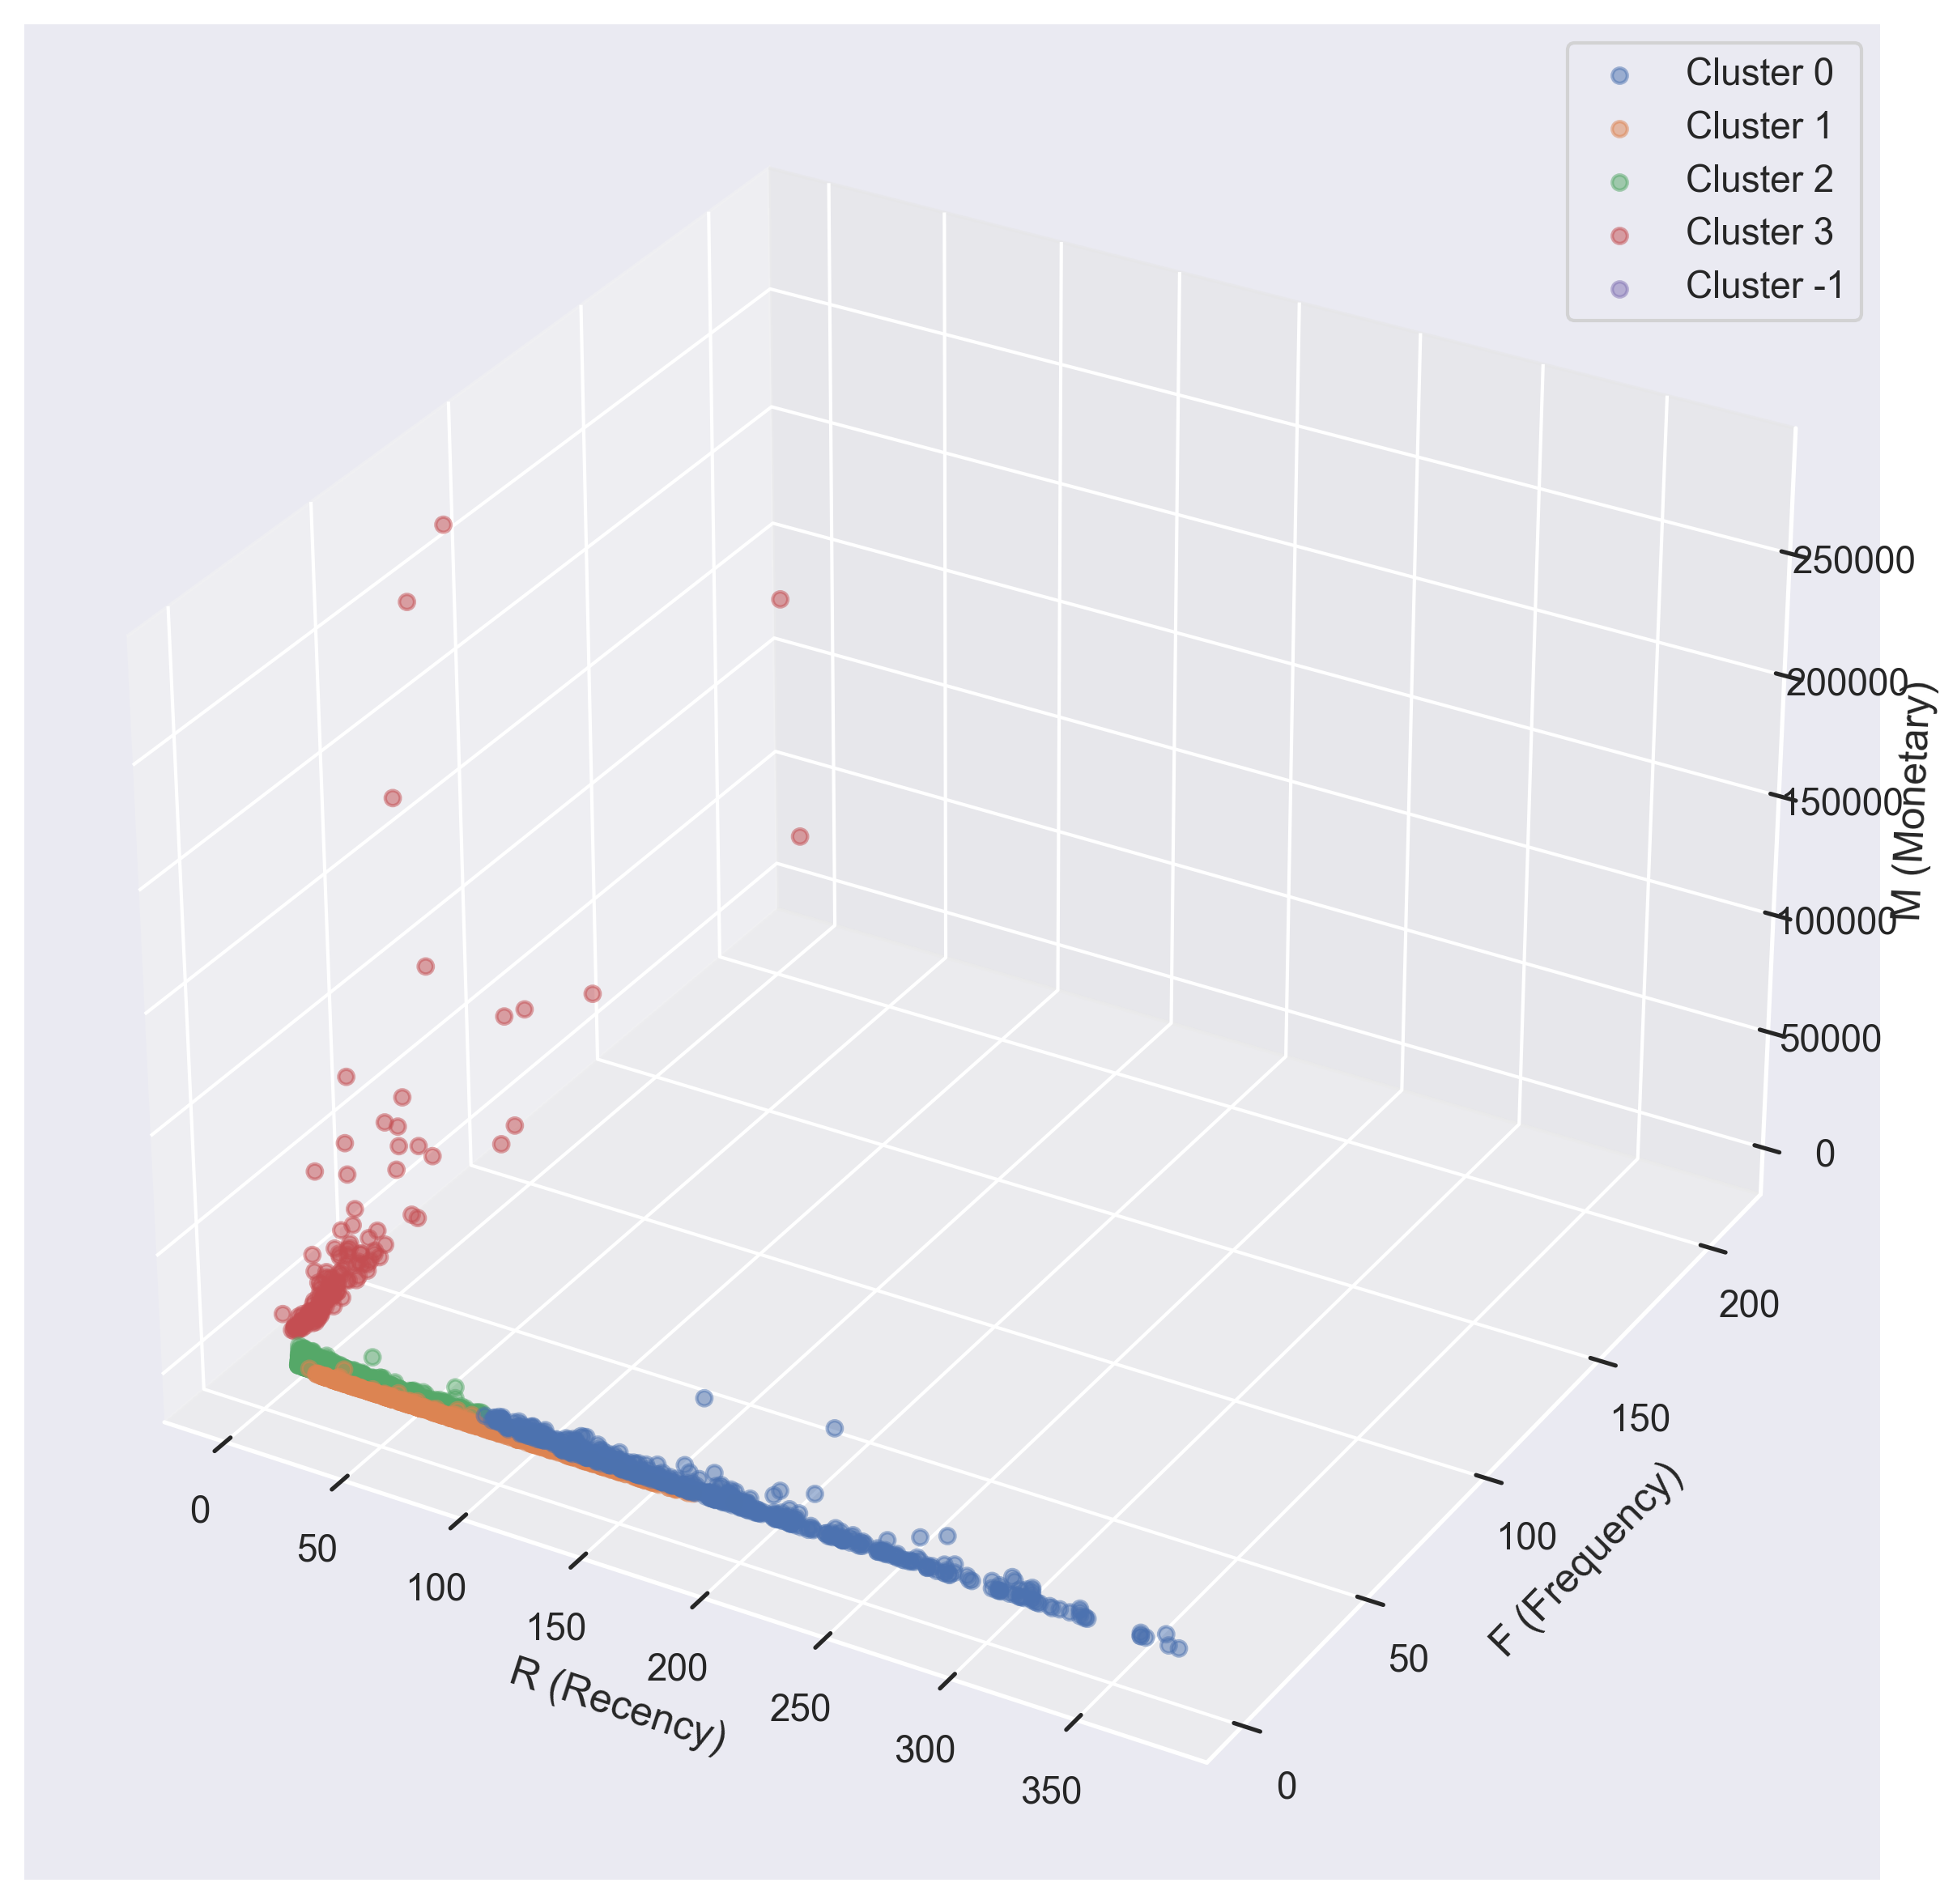

In [64]:
# 三维可视化
fig = plt.figure(figsize=(10, 8), dpi = 300)
ax = fig.add_subplot(111, projection='3d')

for cluster in set(clusters_dbscan):
    mask = (clusters == cluster)
    ax.scatter(R_dbscan[mask], F_dbscan[mask], M_dbscan[mask], label=f'Cluster {cluster}', alpha=0.5)

ax.set_xlabel('R (Recency)')
ax.set_ylabel('F (Frequency)')
ax.set_zlabel('M (Monetary)')
ax.legend()

plt.tight_layout()
plt.savefig(fname='DBSCAN聚类三维结果.png')

## 四、模型选择与用户分群
### 4.1 模型选择
根据可视化结果，认为划分最清楚的是：Spectral Clustering

In [65]:
# 聚类
model =  SpectralClustering(n_clusters=8, random_state=1, affinity='rbf')
model.fit(RFM_BC_normalized)
cluster_labels = model.labels_
RDM_kmeans = RFM.assign(cluster=cluster_labels)
print(RDM_kmeans.groupby('cluster').agg({'R':['mean'], 'F':['mean'], 'M':['mean', 'sum', 'count']}).round(2))

              R      F         M                  
           mean   mean      mean         sum count
cluster                                           
0        187.27   2.92   1063.77   539329.12   507
1         76.74   1.00    445.85   295597.54   663
2         43.96   3.03   1031.13  1162084.77  1127
3          3.44  28.38  19898.32  3004646.66   151
4        273.25   1.00    414.84   275040.24   663
5         18.24   1.20    290.14    48742.99   168
6          5.63   4.52   1916.16   827781.51   432
7         33.71   9.36   4360.42  2733986.06   627


### 4.2 RFM用户分群：
重要价值客户（高 R、高 F、高 M）  
重要保持客户（低 R、高 F、高 M）  
重要发展客户（高 R、低 F、高 M）  
重要挽留客户（低 R、低 F、高 M）  
一般价值客户（高 R、高 F、低 M）  
一般保持客户（低 R、高 F、低 M）  
一般发展客户（高 R、低 F、低 M）  
一般挽留客户（低 R、低 F、低 M）  
根据聚类结果分析：  
##### cluster 0：一般价值客户（高 R、高 F、低 M）
特征分析：平均最近一次消费间隔（R）为 187.27，购买频率（F）平均是 2.92 次，平均消费金额（M）为 1063.77 元，整体消费金额总和达到 539329.12 元，包含 507 个样本。这类群体近期消费不算特别近，但购买频率尚可，且单次消费金额较高，说明他们是有一定消费实力且相对活跃的客户群体。  
营销策略建议：可以继续通过个性化推荐、专属优惠活动等方式维持他们的购买频率，进一步挖掘其消费潜力，比如针对他们过往购买偏好推荐相关高价值商品，提供会员积分加倍等激励措施，促使他们更多、更频繁地消费。  
##### cluster 1：一般保持客户（低 R、高 F、低 M）
特征分析：R 值为 76.74 相对较小，意味着最近有过消费，不过 F 值仅 1.00，购买频率很低，M 值为 445.85 元也不算高，总消费金额 295597.54 元，样本数有 663 个。这表明该群体虽然最近有购买行为，但整体购买活跃度不足，消费金额也较为普通。
营销策略建议：重点在于提高其购买频率，可发送定期的新品提醒、组合购买优惠套餐等，鼓励他们再次购买，例如推出买二送一或者满减等活动，吸引他们增加购买次数。
##### cluster 2：重要保持客户（低 R、高 F、高 M）
特征分析：R 值 43.96 显示近期有消费行为，F 值 3.03 说明购买频率较高，M 值 1031.13 元表示单次消费金额也不错，总消费金额高达 1162084.77 元，样本数为 1127 个。整体来看，这是一个活跃度和消费实力都较好的群体，对业务贡献较大。  
营销策略建议：持续保持良好的互动，提供优质的客户服务，例如优先售后、专属客服等，同时可以给予忠诚度奖励，如达到一定累计消费额度赠送礼品或者升级会员等级享受更多特权等，巩固他们的忠诚度。  
##### cluster 3：重要价值客户（高 R、高 F、高 M）
特征分析：R 值仅 3.44，说明最近刚消费过，F 值高达 28.38，购买频率非常高，M 值更是达到 19898.32 元，单次消费金额极大，总消费金额 3004646.66 元，不过样本数只有 151 个。显然这是一个高价值、高活跃度的核心客户群体，虽然数量少，但对业绩贡献极大。  
营销策略建议：给予顶级的专属服务待遇，像私人定制化服务、限量版商品优先购买权、高端会员俱乐部权益等，不遗余力地维护好与他们的关系，确保他们持续保持高消费、高频率的购买状态。  
##### cluster 4：一般挽留客户（低 R、低 F、低 M）
特征分析：R 值 273.25 表明很久没有消费了，F 值为 1.00 购买频率低，M 值 414.84 元不算高，总消费金额 275040.24 元，样本数 663 个。这一群体处于较不活跃且消费能力普通的状态，有流失风险。    
营销策略建议：需要采取激活策略，比如发送大额优惠券、回访了解不购买原因并针对性解决问题，推出老客户回归专属优惠活动等，尽力挽回他们，提高其再次购买的可能性。  
##### cluster 5：一般发展客户（高 R、低 F、低 M）
特征分析：R 值 18.24 说明近期有消费，F 值 1.20 购买频率较低，M 值 290.14 元消费金额也较低，总消费金额 48742.99 元，样本数 168 个。属于活跃度和消费能力都相对较弱的群体。  
营销策略建议：可以通过小额优惠刺激、推荐性价比高的入门产品等方式，慢慢培养他们的购买习惯，增加购买频率和消费金额，比如发放满 100 减 20 的优惠券，引导他们尝试更多商品。  
##### cluster 6：重要发展客户（高 R、低 F、高 M）
特征分析：R 值 5.63 表示近期有消费，F 值 4.52 购买频率较高，M 值 1916.16 元单次消费金额较高，总消费金额 827781.51 元，样本数 432 个。这是一个较活跃且单次消费能力不错的群体，有较大的提升空间。  
营销策略建议：一方面继续通过多样化的营销活动维持其购买频率，另一方面可以尝试引导他们提高单次消费金额，比如推荐配套的高价值商品，开展满额升级赠品等活动，促使他们消费更多。  
##### cluster 7：重要挽留客户（低 R、低 F、高 M）
特征分析：R 值 33.71 显示近期有消费，F 值 9.36 购买频率较高，M 值 4360.42 元单次消费金额很高，总消费金额 2733986.06 元，样本数 627 个。是一个活跃度高且消费实力强的优质群体。  
营销策略建议：为他们提供更个性化的服务体验，如根据其购买历史提供定制化商品推荐，定期举办专属答谢活动，加强情感联系，进一步巩固他们与品牌的关系，使其持续稳定地为业务贡献价值。  